import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import interpolate

In [2]:
def make_batch_grids(x, y, z, batch_size, train_DM_size, DM_size):
    # x,y,z range are coordinates ranges of each training cube
    x_range = ((x.reshape(batch_size,-1)+(np.arange(train_DM_size[0])-(train_DM_size[0]-1)/2)+DM_size)%DM_size).astype('int')
    y_range = ((y.reshape(batch_size,-1)+(np.arange(train_DM_size[1])-(train_DM_size[1]-1)/2)+DM_size)%DM_size).astype('int')
    z_range = ((z.reshape(batch_size,-1)+(np.arange(train_DM_size[2])-(train_DM_size[2]-1)/2)+DM_size)%DM_size).astype('int')
    
    # cx,cy,cz are coordinates of every points of each training cube, together forming a meshgrid
    ci = np.array([0,1,2,3]).repeat(train_DM_size.prod()*batch_size).reshape(4,batch_size,train_DM_size[0],train_DM_size[1],train_DM_size[2]).transpose(1,0,2,3,4)
    cx = x_range.repeat(train_DM_size[[1,2]].prod()).reshape(batch_size,1,train_DM_size[1],train_DM_size[0],train_DM_size[2]).transpose(0,1,2,3,4).repeat(4, axis=1)
    cy = y_range.repeat(train_DM_size[[2,0]].prod()).reshape(batch_size,1,train_DM_size[0],train_DM_size[2],train_DM_size[1]).transpose(0,1,4,2,3).repeat(4, axis=1)
    cz = z_range.repeat(train_DM_size[[0,1]].prod()).reshape(batch_size,1,train_DM_size[2],train_DM_size[1],train_DM_size[0]).transpose(0,1,3,4,2).repeat(4, axis=1)
    
    return tuple([ci, cx, cy, cz])

In [3]:
def generate_block(train_ske_size, DM_size):
    nx, ny, nz = (DM_size / train_ske_size).astype('int')
    x1 = (np.arange(nx)*(train_ske_size[0]) + (train_ske_size[0]-1)/2) * DM_reso
    x2 = (np.arange(ny)*(train_ske_size[1]) + (train_ske_size[1]-1)/2) * DM_reso
    x3 = (np.arange(nz)*(train_ske_size[2]) + (train_ske_size[2]-1)/2) * DM_reso
    
    cx = x1.repeat(ny*nz).reshape(nx,ny,nz).transpose(0,1,2).flatten()
    cy = x2.repeat(nz*nx).reshape(ny,nz,nx).transpose(2,0,1).flatten()
    cz = x3.repeat(nx*ny).reshape(nz,nx,ny).transpose(1,2,0).flatten()
    block = np.array([cx, cy, cz]).T
    
    return block

In [4]:
# read in DM cube
DM_fits = fits.open('../Illustris3/DMdelta_Illustris3_L75_N600.fits')
DM = DM_fits[0].data + 1
DM_fits.close(); del DM_fits
DM_len  = 75*1000 # in kpc/h
DM_reso = DM_len / 600 # in kpc/h
DM_size = 600

DM_vx_fits = fits.open('../Illustris3/vx_cic_Illustris3_L75_N600.fits')
DM_vx = DM_vx_fits[0].data
DM_vx_fits.close(); del DM_vx_fits

DM_vy_fits = fits.open('../Illustris3/vy_cic_Illustris3_L75_N600.fits')
DM_vy = DM_vy_fits[0].data
DM_vy_fits.close(); del DM_vy_fits

DM_vz_fits = fits.open('../Illustris3/vz_cic_Illustris3_L75_N600.fits')
DM_vz = DM_vz_fits[0].data
DM_vz_fits.close(); del DM_vz_fits

DM_general = np.array([DM, DM_vx, DM_vy, DM_vz])
del DM, DM_vx, DM_vy, DM_vz

In [5]:
# read in skewers
ske = np.loadtxt('../Illustris3/spectra_Illustris3_N600.dat')

In [6]:
train_ske_size = np.array([5,5,5], dtype='int') # x, y, z respctively, please pick 3, 5, 9, 15, 25, 75
train_DM_size  = np.array([25,25,33], dtype='int') # train_ske_size + np.array([x,y,z])
batch_size = 10
if DM_general.shape[1]<train_DM_size.min():
    raise ValueError('DarkMatter cube size', DM_general.shape, 'is too small for train size', train_DM_size, '.')
if ~(train_DM_size%2).all():
    raise ValueError('train size scannot be even.')

In [7]:
block = generate_block(train_ske_size, DM_size)

In [8]:
ske = ske.reshape(int(DM_size/train_ske_size[0]), train_ske_size[0],\
                  int(DM_size/train_ske_size[1]), train_ske_size[1], ske.shape[1]).transpose(0,2,1,3,4)\
                .reshape(-1, train_ske_size[[0,1]].prod(), int(DM_size/train_ske_size[2]), train_ske_size[2])
ske = ske.transpose(0,2,1,3).reshape(-1,train_ske_size[0], train_ske_size[1], train_ske_size[2])

In [9]:
#ske.reshape(600, 600, 600).reshape(120,5,120,5,40,15).transpose(0,1,2,3,4,5).shape

In [10]:
# set length of training set and test set
all_len    = int((DM_size/train_ske_size).prod())
train_len  = 1000000
xtrain_len = all_len - train_len

# randomly selet the training set and test set
boolean_seperate = np.append( np.ones(train_len, dtype='bool'), np.zeros(xtrain_len, dtype='bool') ) 
train_block = block[boolean_seperate]
train_ske   = ske[boolean_seperate]
'''
# shuffle the training set
np.random.seed(50)
state = np.random.get_state()
np.random.shuffle( train_block )
np.random.set_state(state)
np.random.shuffle( train_ske )
'''

'\n# shuffle the training set\nnp.random.seed(50)\nstate = np.random.get_state()\nnp.random.shuffle( train_block )\nnp.random.set_state(state)\nnp.random.shuffle( train_ske )\n'

In [11]:
# flatten the optical depth data in batches
from more_itertools import chunked
import torch
train_ske   = torch.FloatTensor( list(chunked( train_ske, batch_size )) )
train_block = np.array( list(chunked( train_block, batch_size )) )

In [9]:
#imports for model
import os
import time
#import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn

def narrow_tensor(tensorA, tensorB):
    '''
    to narrow tensorA to be like tensorB by deleting border elments 
    '''
    Ashape = np.array(tensorA.shape[2:5])
    Bshape = np.array(tensorB.shape[2:5])
    dx, dy, dz = ((Ashape-Bshape)//2)
    tensorA = tensorA[:,:,dx:Ashape[0]-dx,dy:Ashape[1]-dy,dz:Ashape[2]-dz]
    #print(tensorA.shape, tensorB.shape)
    return tensorA

#basic convolutional block
def conv3x3(in_channels, out_channels, stride=1, kernel_size=(3,3,3)):
    print(kernel_size, stride)
    return nn.Conv3d(in_channels, out_channels, kernel_size, 
                     stride=stride, padding=0, bias=False)

#basic residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels, kernel_size=kernel_size)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        
        residual = narrow_tensor(residual, out)
        out += residual
        
        return out
    

#The HYPHY network!
def get_residual_network() -> torch.nn.Module:
    layers= [2, 2, 2]
    class ResNet(torch.nn.Module):
        def __init__(self, block, layers = layers, num_classes=1):
            super(ResNet, self).__init__()
            self.in_channels = 16
            self.conv1 = conv3x3(4, 16)
            self.conv2 = conv3x3(32, 1)
            self.bn = torch.nn.BatchNorm3d(16)
            self.relu = torch.nn.ReLU(inplace=True)
            self.layer1 = self.make_layer(block, 16, layers[0])
            self.layer2 = self.make_layer(block, 32, layers[1], stride=1)
            #self.layer3 = self.make_layer(block, 64, layers[2], 2)
            self.avg_pool = nn.AvgPool3d(4)
            self.fc = nn.Linear(64, 15)
            self.drop_layer = nn.Dropout(p=0.1)
            self.fc2 = nn.Linear(15, 5)
            self.fc3 = nn.Linear(5, 1)
            self.fc_dense = nn.Linear(9**3, 1)

        def make_layer(self, block, out_channels, blocks, stride=1):
            downsample = None
            kernel_size = (3,3,7)
            if (stride != 1) or (self.in_channels != out_channels):
                kernel_size=(3,3,3)
                downsample = torch.nn.Sequential(
                    conv3x3(self.in_channels, out_channels, stride=stride, kernel_size=kernel_size),
                    torch.nn.BatchNorm3d(out_channels))
            layers = []
            layers.append(block(self.in_channels, out_channels, kernel_size, stride, downsample))
            self.in_channels = out_channels
            for i in range(1, blocks):
                layers.append(block(out_channels, out_channels, kernel_size))
            return nn.Sequential(*layers)

        def forward(self, x):
            if True:
                #x = x.unsqueeze(1)
                out = self.conv1(x)
                #print(torch.typename(out))
                out = self.bn(out)
                out = self.relu(out)
                out = self.layer1(out) #residual layer 1
                out = self.drop_layer(out)
                out = self.layer2(out) #residual layer 2
                out = self.conv2(out)
                
                #out = self.avg_pool(out)
            
          #  out = self.drop_layer(out)
           # out = self.log_std(out)

            return out.squeeze(1)
    return ResNet(ResidualBlock,layers=[2,2,2])

In [10]:
#using GPU, comment out if on CPU
#os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'


device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

Using device: cuda:1


In [14]:
from torch.utils.data import DataLoader, TensorDataset

# Hyper-parameters
num_epochs = 40
learning_rate = 0.0001

model = get_residual_network().float().to(device)
#model.load_state_dict(torch.load('params_Ben_2_logtau_DMx21y21z33_skex5y5z5_MSE.pkl'))


# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train the model
#total_step = 5000#len(train_loader)
curr_lr = learning_rate
start_time = time.time()

#train_dataset = TensorDataset(torch.DoubleTensor(train), torch.DoubleTensor(train_y))
#params = {'batch_size': 50}
#trainloader = DataLoader(train_dataset, **params)

#DM.to(device); DM_vx.to(device); DM_vy.to(device); DM_vz.to(device)

(3, 3, 3) 1
(3, 3, 3) 1
(3, 3, 3) 1
(3, 3, 7) 1
(3, 3, 3) 1
(3, 3, 7) 1
(3, 3, 3) 1
(3, 3, 3) 1
(3, 3, 3) 1
(3, 3, 3) 1
(3, 3, 3) 1


In [15]:
DM_general = torch.tensor(DM_general).float()

In [16]:
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, train_data in enumerate(train_ske, 0):
        # get the inputs; data each batch of train_ske
        targets = torch.log(train_ske[i]).to(device)
        # x,y,z are the central coordinates of each training DM cube
        x = (train_block[i, :, 0])/DM_reso
        y = (train_block[i, :, 1])/DM_reso
        z = (train_block[i, :, 2])/DM_reso
        batch_grids = make_batch_grids(x, y, z, batch_size, train_DM_size, DM_general.shape[1])
        inputs = DM_general[batch_grids].to(device)
        
        #print(inputs.shape)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ("Epoch [{:2d}/{:2d}], Step [{:6d}/{:6d}] Loss: {:.4f},Time: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, train_ske.shape[0], loss.item(),time.time()-start_time))
        if (i+1) % train_ske.shape[0] ==0:
            print ("SAVING MODEL!")
            torch.save(model.state_dict(), "./params_Ben_2_t.pkl")

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

Epoch [ 1/40], Step [   100/100000] Loss: 4.9382,Time: 15.5760
Epoch [ 1/40], Step [   200/100000] Loss: 7.3248,Time: 21.4217
Epoch [ 1/40], Step [   300/100000] Loss: 2.1525,Time: 26.9662
Epoch [ 1/40], Step [   400/100000] Loss: 2.2448,Time: 32.4429
Epoch [ 1/40], Step [   500/100000] Loss: 1.5894,Time: 38.1903
Epoch [ 1/40], Step [   600/100000] Loss: 1.6807,Time: 43.6681
Epoch [ 1/40], Step [   700/100000] Loss: 3.2906,Time: 49.1424
Epoch [ 1/40], Step [   800/100000] Loss: 1.7280,Time: 54.6924
Epoch [ 1/40], Step [   900/100000] Loss: 1.8384,Time: 60.4172
Epoch [ 1/40], Step [  1000/100000] Loss: 1.3462,Time: 66.1823
Epoch [ 1/40], Step [  1100/100000] Loss: 1.9175,Time: 72.0515
Epoch [ 1/40], Step [  1200/100000] Loss: 1.6289,Time: 77.5555
Epoch [ 1/40], Step [  1300/100000] Loss: 1.8718,Time: 82.9772
Epoch [ 1/40], Step [  1400/100000] Loss: 2.1921,Time: 88.6842
Epoch [ 1/40], Step [  1500/100000] Loss: 0.6217,Time: 94.2871
Epoch [ 1/40], Step [  1600/100000] Loss: 3.7769,Time: 

Epoch [ 1/40], Step [ 13000/100000] Loss: 0.6917,Time: 729.2182
Epoch [ 1/40], Step [ 13100/100000] Loss: 2.0476,Time: 734.4532
Epoch [ 1/40], Step [ 13200/100000] Loss: 4.9787,Time: 739.6401
Epoch [ 1/40], Step [ 13300/100000] Loss: 3.9826,Time: 744.8837
Epoch [ 1/40], Step [ 13400/100000] Loss: 0.3896,Time: 750.3573
Epoch [ 1/40], Step [ 13500/100000] Loss: 0.9048,Time: 756.0339
Epoch [ 1/40], Step [ 13600/100000] Loss: 2.7223,Time: 761.2348
Epoch [ 1/40], Step [ 13700/100000] Loss: 0.8072,Time: 766.6073
Epoch [ 1/40], Step [ 13800/100000] Loss: 2.2940,Time: 771.9615
Epoch [ 1/40], Step [ 13900/100000] Loss: 2.3152,Time: 777.6353
Epoch [ 1/40], Step [ 14000/100000] Loss: 2.7412,Time: 783.3090
Epoch [ 1/40], Step [ 14100/100000] Loss: 2.5509,Time: 788.6477
Epoch [ 1/40], Step [ 14200/100000] Loss: 1.3924,Time: 793.9207
Epoch [ 1/40], Step [ 14300/100000] Loss: 0.8417,Time: 799.7203
Epoch [ 1/40], Step [ 14400/100000] Loss: 0.7008,Time: 805.5000
Epoch [ 1/40], Step [ 14500/100000] Loss

Epoch [ 1/40], Step [ 25700/100000] Loss: 1.1112,Time: 1438.3155
Epoch [ 1/40], Step [ 25800/100000] Loss: 1.3125,Time: 1443.8643
Epoch [ 1/40], Step [ 25900/100000] Loss: 0.7692,Time: 1449.5774
Epoch [ 1/40], Step [ 26000/100000] Loss: 0.9123,Time: 1455.2792
Epoch [ 1/40], Step [ 26100/100000] Loss: 0.6666,Time: 1461.0062
Epoch [ 1/40], Step [ 26200/100000] Loss: 1.1408,Time: 1466.5945
Epoch [ 1/40], Step [ 26300/100000] Loss: 0.3085,Time: 1472.3356
Epoch [ 1/40], Step [ 26400/100000] Loss: 1.3283,Time: 1478.1055
Epoch [ 1/40], Step [ 26500/100000] Loss: 1.9174,Time: 1483.7551
Epoch [ 1/40], Step [ 26600/100000] Loss: 0.4084,Time: 1489.3783
Epoch [ 1/40], Step [ 26700/100000] Loss: 0.6293,Time: 1495.0262
Epoch [ 1/40], Step [ 26800/100000] Loss: 3.1907,Time: 1500.6827
Epoch [ 1/40], Step [ 26900/100000] Loss: 7.6717,Time: 1506.3223
Epoch [ 1/40], Step [ 27000/100000] Loss: 2.6896,Time: 1512.0601
Epoch [ 1/40], Step [ 27100/100000] Loss: 0.9274,Time: 1517.5715
Epoch [ 1/40], Step [ 272

Epoch [ 1/40], Step [ 38400/100000] Loss: 1.5467,Time: 2143.4455
Epoch [ 1/40], Step [ 38500/100000] Loss: 1.8546,Time: 2149.0610
Epoch [ 1/40], Step [ 38600/100000] Loss: 2.8269,Time: 2154.7145
Epoch [ 1/40], Step [ 38700/100000] Loss: 0.7235,Time: 2160.2709
Epoch [ 1/40], Step [ 38800/100000] Loss: 1.1038,Time: 2165.8502
Epoch [ 1/40], Step [ 38900/100000] Loss: 0.9015,Time: 2171.5694
Epoch [ 1/40], Step [ 39000/100000] Loss: 0.5924,Time: 2177.3294
Epoch [ 1/40], Step [ 39100/100000] Loss: 2.9291,Time: 2182.9974
Epoch [ 1/40], Step [ 39200/100000] Loss: 1.1667,Time: 2188.7232
Epoch [ 1/40], Step [ 39300/100000] Loss: 0.9458,Time: 2194.5004
Epoch [ 1/40], Step [ 39400/100000] Loss: 0.3115,Time: 2200.2805
Epoch [ 1/40], Step [ 39500/100000] Loss: 0.3188,Time: 2206.0616
Epoch [ 1/40], Step [ 39600/100000] Loss: 0.7534,Time: 2211.7648
Epoch [ 1/40], Step [ 39700/100000] Loss: 1.3020,Time: 2217.1605
Epoch [ 1/40], Step [ 39800/100000] Loss: 2.7915,Time: 2222.6938
Epoch [ 1/40], Step [ 399

Epoch [ 1/40], Step [ 51100/100000] Loss: 0.6939,Time: 2857.1154
Epoch [ 1/40], Step [ 51200/100000] Loss: 6.2997,Time: 2862.5607
Epoch [ 1/40], Step [ 51300/100000] Loss: 0.5889,Time: 2868.1079
Epoch [ 1/40], Step [ 51400/100000] Loss: 1.0931,Time: 2873.6799
Epoch [ 1/40], Step [ 51500/100000] Loss: 0.9451,Time: 2879.3575
Epoch [ 1/40], Step [ 51600/100000] Loss: 1.7179,Time: 2884.6982
Epoch [ 1/40], Step [ 51700/100000] Loss: 1.5922,Time: 2889.9242
Epoch [ 1/40], Step [ 51800/100000] Loss: 0.9435,Time: 2895.6455
Epoch [ 1/40], Step [ 51900/100000] Loss: 0.6073,Time: 2901.4617
Epoch [ 1/40], Step [ 52000/100000] Loss: 1.5224,Time: 2907.1060
Epoch [ 1/40], Step [ 52100/100000] Loss: 3.6622,Time: 2912.8260
Epoch [ 1/40], Step [ 52200/100000] Loss: 1.2021,Time: 2918.2802
Epoch [ 1/40], Step [ 52300/100000] Loss: 0.4139,Time: 2923.7686
Epoch [ 1/40], Step [ 52400/100000] Loss: 1.7719,Time: 2929.4846
Epoch [ 1/40], Step [ 52500/100000] Loss: 0.8968,Time: 2935.1304
Epoch [ 1/40], Step [ 526

Epoch [ 1/40], Step [ 63800/100000] Loss: 0.6731,Time: 3568.3353
Epoch [ 1/40], Step [ 63900/100000] Loss: 0.4111,Time: 3573.9656
Epoch [ 1/40], Step [ 64000/100000] Loss: 0.4832,Time: 3579.6959
Epoch [ 1/40], Step [ 64100/100000] Loss: 2.5981,Time: 3585.1538
Epoch [ 1/40], Step [ 64200/100000] Loss: 0.4309,Time: 3590.7605
Epoch [ 1/40], Step [ 64300/100000] Loss: 1.0360,Time: 3596.5795
Epoch [ 1/40], Step [ 64400/100000] Loss: 2.2138,Time: 3602.0851
Epoch [ 1/40], Step [ 64500/100000] Loss: 0.5923,Time: 3607.8447
Epoch [ 1/40], Step [ 64600/100000] Loss: 0.6195,Time: 3613.4369
Epoch [ 1/40], Step [ 64700/100000] Loss: 0.9898,Time: 3619.0886
Epoch [ 1/40], Step [ 64800/100000] Loss: 9.8239,Time: 3624.6116
Epoch [ 1/40], Step [ 64900/100000] Loss: 0.2749,Time: 3630.1687
Epoch [ 1/40], Step [ 65000/100000] Loss: 1.6069,Time: 3635.9526
Epoch [ 1/40], Step [ 65100/100000] Loss: 0.2031,Time: 3641.8312
Epoch [ 1/40], Step [ 65200/100000] Loss: 1.0322,Time: 3647.7039
Epoch [ 1/40], Step [ 653

Epoch [ 1/40], Step [ 76500/100000] Loss: 1.1568,Time: 4279.0374
Epoch [ 1/40], Step [ 76600/100000] Loss: 0.9487,Time: 4284.7569
Epoch [ 1/40], Step [ 76700/100000] Loss: 1.7276,Time: 4290.3564
Epoch [ 1/40], Step [ 76800/100000] Loss: 0.7294,Time: 4295.8016
Epoch [ 1/40], Step [ 76900/100000] Loss: 0.8386,Time: 4301.4609
Epoch [ 1/40], Step [ 77000/100000] Loss: 1.0590,Time: 4307.0742
Epoch [ 1/40], Step [ 77100/100000] Loss: 0.5339,Time: 4312.6811
Epoch [ 1/40], Step [ 77200/100000] Loss: 1.4094,Time: 4317.9998
Epoch [ 1/40], Step [ 77300/100000] Loss: 0.8626,Time: 4323.3320
Epoch [ 1/40], Step [ 77400/100000] Loss: 0.8046,Time: 4329.0363
Epoch [ 1/40], Step [ 77500/100000] Loss: 0.7183,Time: 4334.6046
Epoch [ 1/40], Step [ 77600/100000] Loss: 3.1331,Time: 4339.9902
Epoch [ 1/40], Step [ 77700/100000] Loss: 8.0754,Time: 4345.6705
Epoch [ 1/40], Step [ 77800/100000] Loss: 0.3361,Time: 4351.1256
Epoch [ 1/40], Step [ 77900/100000] Loss: 4.8904,Time: 4356.8716
Epoch [ 1/40], Step [ 780

Epoch [ 1/40], Step [ 89200/100000] Loss: 1.5644,Time: 4976.8160
Epoch [ 1/40], Step [ 89300/100000] Loss: 1.3260,Time: 4982.2568
Epoch [ 1/40], Step [ 89400/100000] Loss: 4.4860,Time: 4987.5715
Epoch [ 1/40], Step [ 89500/100000] Loss: 0.3276,Time: 4993.1527
Epoch [ 1/40], Step [ 89600/100000] Loss: 0.4534,Time: 4998.8036
Epoch [ 1/40], Step [ 89700/100000] Loss: 0.5228,Time: 5004.2241
Epoch [ 1/40], Step [ 89800/100000] Loss: 0.1920,Time: 5009.6020
Epoch [ 1/40], Step [ 89900/100000] Loss: 0.3554,Time: 5015.2732
Epoch [ 1/40], Step [ 90000/100000] Loss: 4.5427,Time: 5020.9722
Epoch [ 1/40], Step [ 90100/100000] Loss: 0.9391,Time: 5026.2780
Epoch [ 1/40], Step [ 90200/100000] Loss: 0.4442,Time: 5031.8781
Epoch [ 1/40], Step [ 90300/100000] Loss: 0.3962,Time: 5037.5029
Epoch [ 1/40], Step [ 90400/100000] Loss: 1.4368,Time: 5043.1831
Epoch [ 1/40], Step [ 90500/100000] Loss: 2.1985,Time: 5048.9759
Epoch [ 1/40], Step [ 90600/100000] Loss: 1.3622,Time: 5054.6611
Epoch [ 1/40], Step [ 907

Epoch [ 2/40], Step [  1800/100000] Loss: 0.5841,Time: 5671.0235
Epoch [ 2/40], Step [  1900/100000] Loss: 2.6492,Time: 5676.3882
Epoch [ 2/40], Step [  2000/100000] Loss: 1.0735,Time: 5681.8270
Epoch [ 2/40], Step [  2100/100000] Loss: 3.1722,Time: 5687.4279
Epoch [ 2/40], Step [  2200/100000] Loss: 1.0930,Time: 5693.1054
Epoch [ 2/40], Step [  2300/100000] Loss: 1.4111,Time: 5698.7359
Epoch [ 2/40], Step [  2400/100000] Loss: 1.5064,Time: 5704.2158
Epoch [ 2/40], Step [  2500/100000] Loss: 0.4381,Time: 5709.3929
Epoch [ 2/40], Step [  2600/100000] Loss: 0.3826,Time: 5714.7818
Epoch [ 2/40], Step [  2700/100000] Loss: 0.5874,Time: 5720.1656
Epoch [ 2/40], Step [  2800/100000] Loss: 1.5231,Time: 5725.9124
Epoch [ 2/40], Step [  2900/100000] Loss: 3.0160,Time: 5731.5973
Epoch [ 2/40], Step [  3000/100000] Loss: 0.3135,Time: 5737.2506
Epoch [ 2/40], Step [  3100/100000] Loss: 2.8344,Time: 5742.5849
Epoch [ 2/40], Step [  3200/100000] Loss: 0.4506,Time: 5747.9256
Epoch [ 2/40], Step [  33

Epoch [ 2/40], Step [ 14500/100000] Loss: 0.7584,Time: 6381.0900
Epoch [ 2/40], Step [ 14600/100000] Loss: 1.0857,Time: 6386.8248
Epoch [ 2/40], Step [ 14700/100000] Loss: 0.2932,Time: 6392.5520
Epoch [ 2/40], Step [ 14800/100000] Loss: 2.6065,Time: 6398.1265
Epoch [ 2/40], Step [ 14900/100000] Loss: 0.9550,Time: 6403.8629
Epoch [ 2/40], Step [ 15000/100000] Loss: 0.7643,Time: 6409.4224
Epoch [ 2/40], Step [ 15100/100000] Loss: 0.9094,Time: 6414.7885
Epoch [ 2/40], Step [ 15200/100000] Loss: 0.4408,Time: 6420.3983
Epoch [ 2/40], Step [ 15300/100000] Loss: 1.4088,Time: 6426.1901
Epoch [ 2/40], Step [ 15400/100000] Loss: 1.0912,Time: 6431.8983
Epoch [ 2/40], Step [ 15500/100000] Loss: 0.5497,Time: 6437.3744
Epoch [ 2/40], Step [ 15600/100000] Loss: 0.4698,Time: 6442.7402
Epoch [ 2/40], Step [ 15700/100000] Loss: 0.3584,Time: 6448.4473
Epoch [ 2/40], Step [ 15800/100000] Loss: 0.3565,Time: 6453.7499
Epoch [ 2/40], Step [ 15900/100000] Loss: 0.7676,Time: 6459.3118
Epoch [ 2/40], Step [ 160

Epoch [ 2/40], Step [ 27200/100000] Loss: 0.9680,Time: 7087.9152
Epoch [ 2/40], Step [ 27300/100000] Loss: 1.2115,Time: 7093.6604
Epoch [ 2/40], Step [ 27400/100000] Loss: 0.6948,Time: 7099.4218
Epoch [ 2/40], Step [ 27500/100000] Loss: 0.7279,Time: 7105.2132
Epoch [ 2/40], Step [ 27600/100000] Loss: 0.2202,Time: 7110.9636
Epoch [ 2/40], Step [ 27700/100000] Loss: 4.9968,Time: 7116.7582
Epoch [ 2/40], Step [ 27800/100000] Loss: 0.2109,Time: 7122.4720
Epoch [ 2/40], Step [ 27900/100000] Loss: 0.4133,Time: 7128.2553
Epoch [ 2/40], Step [ 28000/100000] Loss: 0.7734,Time: 7133.5374
Epoch [ 2/40], Step [ 28100/100000] Loss: 0.3242,Time: 7139.0905
Epoch [ 2/40], Step [ 28200/100000] Loss: 0.4109,Time: 7144.6895
Epoch [ 2/40], Step [ 28300/100000] Loss: 0.7615,Time: 7150.3655
Epoch [ 2/40], Step [ 28400/100000] Loss: 4.1365,Time: 7156.0349
Epoch [ 2/40], Step [ 28500/100000] Loss: 1.5921,Time: 7161.5897
Epoch [ 2/40], Step [ 28600/100000] Loss: 0.2394,Time: 7167.2306
Epoch [ 2/40], Step [ 287

Epoch [ 2/40], Step [ 39900/100000] Loss: 1.5268,Time: 7797.4467
Epoch [ 2/40], Step [ 40000/100000] Loss: 0.5353,Time: 7802.7554
Epoch [ 2/40], Step [ 40100/100000] Loss: 0.9297,Time: 7808.1071
Epoch [ 2/40], Step [ 40200/100000] Loss: 2.2696,Time: 7813.7194
Epoch [ 2/40], Step [ 40300/100000] Loss: 1.9852,Time: 7818.9151
Epoch [ 2/40], Step [ 40400/100000] Loss: 0.3368,Time: 7824.3003
Epoch [ 2/40], Step [ 40500/100000] Loss: 0.3172,Time: 7829.9217
Epoch [ 2/40], Step [ 40600/100000] Loss: 0.5773,Time: 7835.5056
Epoch [ 2/40], Step [ 40700/100000] Loss: 1.1838,Time: 7840.9772
Epoch [ 2/40], Step [ 40800/100000] Loss: 0.6947,Time: 7846.3163
Epoch [ 2/40], Step [ 40900/100000] Loss: 1.2320,Time: 7851.9966
Epoch [ 2/40], Step [ 41000/100000] Loss: 0.1548,Time: 7857.5877
Epoch [ 2/40], Step [ 41100/100000] Loss: 0.9067,Time: 7863.1607
Epoch [ 2/40], Step [ 41200/100000] Loss: 1.9095,Time: 7868.5175
Epoch [ 2/40], Step [ 41300/100000] Loss: 1.5205,Time: 7873.8617
Epoch [ 2/40], Step [ 414

Epoch [ 2/40], Step [ 52600/100000] Loss: 0.6138,Time: 8502.8633
Epoch [ 2/40], Step [ 52700/100000] Loss: 9.9136,Time: 8508.7088
Epoch [ 2/40], Step [ 52800/100000] Loss: 3.1603,Time: 8514.4207
Epoch [ 2/40], Step [ 52900/100000] Loss: 1.0272,Time: 8520.1190
Epoch [ 2/40], Step [ 53000/100000] Loss: 0.3594,Time: 8525.7703
Epoch [ 2/40], Step [ 53100/100000] Loss: 1.3903,Time: 8531.0198
Epoch [ 2/40], Step [ 53200/100000] Loss: 0.7463,Time: 8536.3223
Epoch [ 2/40], Step [ 53300/100000] Loss: 0.2419,Time: 8541.6932
Epoch [ 2/40], Step [ 53400/100000] Loss: 0.4442,Time: 8547.1837
Epoch [ 2/40], Step [ 53500/100000] Loss: 0.5880,Time: 8552.8517
Epoch [ 2/40], Step [ 53600/100000] Loss: 1.0553,Time: 8558.4255
Epoch [ 2/40], Step [ 53700/100000] Loss: 0.5022,Time: 8564.0657
Epoch [ 2/40], Step [ 53800/100000] Loss: 0.8631,Time: 8569.5888
Epoch [ 2/40], Step [ 53900/100000] Loss: 1.7484,Time: 8574.7635
Epoch [ 2/40], Step [ 54000/100000] Loss: 0.5409,Time: 8579.9509
Epoch [ 2/40], Step [ 541

Epoch [ 2/40], Step [ 65300/100000] Loss: 1.0361,Time: 9199.0981
Epoch [ 2/40], Step [ 65400/100000] Loss: 0.3751,Time: 9204.3534
Epoch [ 2/40], Step [ 65500/100000] Loss: 0.3603,Time: 9209.9429
Epoch [ 2/40], Step [ 65600/100000] Loss: 3.3025,Time: 9215.5362
Epoch [ 2/40], Step [ 65700/100000] Loss: 2.3114,Time: 9221.1061
Epoch [ 2/40], Step [ 65800/100000] Loss: 0.4439,Time: 9226.2749
Epoch [ 2/40], Step [ 65900/100000] Loss: 1.3348,Time: 9231.6973
Epoch [ 2/40], Step [ 66000/100000] Loss: 0.4253,Time: 9237.3160
Epoch [ 2/40], Step [ 66100/100000] Loss: 0.2772,Time: 9242.5828
Epoch [ 2/40], Step [ 66200/100000] Loss: 0.1835,Time: 9247.9470
Epoch [ 2/40], Step [ 66300/100000] Loss: 5.9704,Time: 9253.5458
Epoch [ 2/40], Step [ 66400/100000] Loss: 0.1854,Time: 9259.2469
Epoch [ 2/40], Step [ 66500/100000] Loss: 0.4485,Time: 9264.9242
Epoch [ 2/40], Step [ 66600/100000] Loss: 0.3201,Time: 9270.5633
Epoch [ 2/40], Step [ 66700/100000] Loss: 0.9873,Time: 9275.7111
Epoch [ 2/40], Step [ 668

Epoch [ 2/40], Step [ 78000/100000] Loss: 0.5230,Time: 9890.0549
Epoch [ 2/40], Step [ 78100/100000] Loss: 0.6370,Time: 9895.5479
Epoch [ 2/40], Step [ 78200/100000] Loss: 1.8277,Time: 9901.0751
Epoch [ 2/40], Step [ 78300/100000] Loss: 0.8657,Time: 9906.7680
Epoch [ 2/40], Step [ 78400/100000] Loss: 0.5182,Time: 9912.3937
Epoch [ 2/40], Step [ 78500/100000] Loss: 0.7203,Time: 9917.9967
Epoch [ 2/40], Step [ 78600/100000] Loss: 0.7010,Time: 9923.2947
Epoch [ 2/40], Step [ 78700/100000] Loss: 0.3631,Time: 9928.7204
Epoch [ 2/40], Step [ 78800/100000] Loss: 2.5887,Time: 9934.3243
Epoch [ 2/40], Step [ 78900/100000] Loss: 1.0864,Time: 9939.9671
Epoch [ 2/40], Step [ 79000/100000] Loss: 0.5095,Time: 9945.6304
Epoch [ 2/40], Step [ 79100/100000] Loss: 0.5607,Time: 9951.2354
Epoch [ 2/40], Step [ 79200/100000] Loss: 1.9266,Time: 9956.9870
Epoch [ 2/40], Step [ 79300/100000] Loss: 1.0329,Time: 9962.7051
Epoch [ 2/40], Step [ 79400/100000] Loss: 0.1970,Time: 9968.3199
Epoch [ 2/40], Step [ 795

Epoch [ 2/40], Step [ 90500/100000] Loss: 2.0242,Time: 10580.1114
Epoch [ 2/40], Step [ 90600/100000] Loss: 1.1423,Time: 10585.8050
Epoch [ 2/40], Step [ 90700/100000] Loss: 0.1799,Time: 10591.4740
Epoch [ 2/40], Step [ 90800/100000] Loss: 1.0844,Time: 10596.9640
Epoch [ 2/40], Step [ 90900/100000] Loss: 1.4244,Time: 10602.1517
Epoch [ 2/40], Step [ 91000/100000] Loss: 0.1337,Time: 10607.4576
Epoch [ 2/40], Step [ 91100/100000] Loss: 1.9097,Time: 10613.1335
Epoch [ 2/40], Step [ 91200/100000] Loss: 0.7098,Time: 10618.2819
Epoch [ 2/40], Step [ 91300/100000] Loss: 0.2830,Time: 10623.6386
Epoch [ 2/40], Step [ 91400/100000] Loss: 0.2711,Time: 10629.1632
Epoch [ 2/40], Step [ 91500/100000] Loss: 4.5138,Time: 10634.7688
Epoch [ 2/40], Step [ 91600/100000] Loss: 1.4440,Time: 10640.4125
Epoch [ 2/40], Step [ 91700/100000] Loss: 0.2500,Time: 10646.0103
Epoch [ 2/40], Step [ 91800/100000] Loss: 0.5045,Time: 10651.6686
Epoch [ 2/40], Step [ 91900/100000] Loss: 1.1361,Time: 10657.3030
Epoch [ 2/

Epoch [ 3/40], Step [  2900/100000] Loss: 2.9558,Time: 11266.1010
Epoch [ 3/40], Step [  3000/100000] Loss: 0.2277,Time: 11271.7201
Epoch [ 3/40], Step [  3100/100000] Loss: 2.5803,Time: 11277.3728
Epoch [ 3/40], Step [  3200/100000] Loss: 0.5598,Time: 11283.0101
Epoch [ 3/40], Step [  3300/100000] Loss: 1.3793,Time: 11288.3887
Epoch [ 3/40], Step [  3400/100000] Loss: 1.9043,Time: 11293.8790
Epoch [ 3/40], Step [  3500/100000] Loss: 0.5581,Time: 11299.5361
Epoch [ 3/40], Step [  3600/100000] Loss: 0.4846,Time: 11305.0570
Epoch [ 3/40], Step [  3700/100000] Loss: 0.3200,Time: 11310.4418
Epoch [ 3/40], Step [  3800/100000] Loss: 0.6078,Time: 11315.7601
Epoch [ 3/40], Step [  3900/100000] Loss: 0.6526,Time: 11321.1130
Epoch [ 3/40], Step [  4000/100000] Loss: 0.8850,Time: 11326.6981
Epoch [ 3/40], Step [  4100/100000] Loss: 0.3753,Time: 11332.3930
Epoch [ 3/40], Step [  4200/100000] Loss: 0.7045,Time: 11338.0669
Epoch [ 3/40], Step [  4300/100000] Loss: 1.4878,Time: 11343.7365
Epoch [ 3/

Epoch [ 3/40], Step [ 15400/100000] Loss: 0.9951,Time: 11955.1951
Epoch [ 3/40], Step [ 15500/100000] Loss: 0.3894,Time: 11960.8195
Epoch [ 3/40], Step [ 15600/100000] Loss: 0.3617,Time: 11966.4496
Epoch [ 3/40], Step [ 15700/100000] Loss: 0.3664,Time: 11972.1835
Epoch [ 3/40], Step [ 15800/100000] Loss: 0.2539,Time: 11978.0663
Epoch [ 3/40], Step [ 15900/100000] Loss: 0.6684,Time: 11983.7939
Epoch [ 3/40], Step [ 16000/100000] Loss: 4.2446,Time: 11989.2287
Epoch [ 3/40], Step [ 16100/100000] Loss: 2.3783,Time: 11994.9801
Epoch [ 3/40], Step [ 16200/100000] Loss: 0.3522,Time: 12000.8234
Epoch [ 3/40], Step [ 16300/100000] Loss: 1.3130,Time: 12006.6383
Epoch [ 3/40], Step [ 16400/100000] Loss: 0.9968,Time: 12012.4717
Epoch [ 3/40], Step [ 16500/100000] Loss: 0.2649,Time: 12018.0237
Epoch [ 3/40], Step [ 16600/100000] Loss: 1.3941,Time: 12023.5898
Epoch [ 3/40], Step [ 16700/100000] Loss: 0.3692,Time: 12028.9803
Epoch [ 3/40], Step [ 16800/100000] Loss: 1.6603,Time: 12034.3459
Epoch [ 3/

Epoch [ 3/40], Step [ 27900/100000] Loss: 0.3724,Time: 12654.5203
Epoch [ 3/40], Step [ 28000/100000] Loss: 0.5146,Time: 12660.0487
Epoch [ 3/40], Step [ 28100/100000] Loss: 0.2837,Time: 12665.3986
Epoch [ 3/40], Step [ 28200/100000] Loss: 0.2817,Time: 12670.7571
Epoch [ 3/40], Step [ 28300/100000] Loss: 0.8590,Time: 12676.3532
Epoch [ 3/40], Step [ 28400/100000] Loss: 3.8964,Time: 12681.8724
Epoch [ 3/40], Step [ 28500/100000] Loss: 1.3192,Time: 12687.4036
Epoch [ 3/40], Step [ 28600/100000] Loss: 0.1722,Time: 12692.9678
Epoch [ 3/40], Step [ 28700/100000] Loss: 1.3682,Time: 12698.5034
Epoch [ 3/40], Step [ 28800/100000] Loss: 0.5656,Time: 12704.0869
Epoch [ 3/40], Step [ 28900/100000] Loss: 1.8170,Time: 12709.6737
Epoch [ 3/40], Step [ 29000/100000] Loss: 1.1607,Time: 12715.1787
Epoch [ 3/40], Step [ 29100/100000] Loss: 0.5232,Time: 12720.7586
Epoch [ 3/40], Step [ 29200/100000] Loss: 1.1914,Time: 12726.2552
Epoch [ 3/40], Step [ 29300/100000] Loss: 0.2140,Time: 12731.8184
Epoch [ 3/

Epoch [ 3/40], Step [ 40400/100000] Loss: 0.4361,Time: 13344.2320
Epoch [ 3/40], Step [ 40500/100000] Loss: 0.2089,Time: 13349.6571
Epoch [ 3/40], Step [ 40600/100000] Loss: 0.4998,Time: 13355.2009
Epoch [ 3/40], Step [ 40700/100000] Loss: 1.0221,Time: 13360.5554
Epoch [ 3/40], Step [ 40800/100000] Loss: 0.6352,Time: 13365.8879
Epoch [ 3/40], Step [ 40900/100000] Loss: 1.2566,Time: 13371.4039
Epoch [ 3/40], Step [ 41000/100000] Loss: 0.1596,Time: 13376.8987
Epoch [ 3/40], Step [ 41100/100000] Loss: 0.6916,Time: 13382.3607
Epoch [ 3/40], Step [ 41200/100000] Loss: 1.3435,Time: 13387.7696
Epoch [ 3/40], Step [ 41300/100000] Loss: 1.7887,Time: 13393.1105
Epoch [ 3/40], Step [ 41400/100000] Loss: 1.6196,Time: 13398.4439
Epoch [ 3/40], Step [ 41500/100000] Loss: 0.3440,Time: 13403.7912
Epoch [ 3/40], Step [ 41600/100000] Loss: 0.3103,Time: 13409.2560
Epoch [ 3/40], Step [ 41700/100000] Loss: 0.7751,Time: 13414.9500
Epoch [ 3/40], Step [ 41800/100000] Loss: 0.1631,Time: 13420.4720
Epoch [ 3/

Epoch [ 3/40], Step [ 52900/100000] Loss: 0.8873,Time: 14032.6398
Epoch [ 3/40], Step [ 53000/100000] Loss: 0.3793,Time: 14038.1990
Epoch [ 3/40], Step [ 53100/100000] Loss: 1.3454,Time: 14043.7556
Epoch [ 3/40], Step [ 53200/100000] Loss: 0.6437,Time: 14049.0241
Epoch [ 3/40], Step [ 53300/100000] Loss: 0.3461,Time: 14054.6261
Epoch [ 3/40], Step [ 53400/100000] Loss: 0.4013,Time: 14060.1176
Epoch [ 3/40], Step [ 53500/100000] Loss: 0.6100,Time: 14065.5608
Epoch [ 3/40], Step [ 53600/100000] Loss: 1.0739,Time: 14071.1487
Epoch [ 3/40], Step [ 53700/100000] Loss: 0.3949,Time: 14076.4632
Epoch [ 3/40], Step [ 53800/100000] Loss: 0.8037,Time: 14081.8334
Epoch [ 3/40], Step [ 53900/100000] Loss: 1.6448,Time: 14087.2456
Epoch [ 3/40], Step [ 54000/100000] Loss: 0.5378,Time: 14092.5496
Epoch [ 3/40], Step [ 54100/100000] Loss: 0.5636,Time: 14098.1234
Epoch [ 3/40], Step [ 54200/100000] Loss: 0.9193,Time: 14103.4238
Epoch [ 3/40], Step [ 54300/100000] Loss: 0.9621,Time: 14108.7194
Epoch [ 3/

Epoch [ 3/40], Step [ 65400/100000] Loss: 0.2361,Time: 14716.5361
Epoch [ 3/40], Step [ 65500/100000] Loss: 0.2533,Time: 14721.6571
Epoch [ 3/40], Step [ 65600/100000] Loss: 2.9745,Time: 14727.1713
Epoch [ 3/40], Step [ 65700/100000] Loss: 2.3676,Time: 14732.4028
Epoch [ 3/40], Step [ 65800/100000] Loss: 0.3981,Time: 14737.9086
Epoch [ 3/40], Step [ 65900/100000] Loss: 1.2418,Time: 14743.3951
Epoch [ 3/40], Step [ 66000/100000] Loss: 0.3664,Time: 14748.9832
Epoch [ 3/40], Step [ 66100/100000] Loss: 0.2724,Time: 14754.2895
Epoch [ 3/40], Step [ 66200/100000] Loss: 0.1811,Time: 14759.7922
Epoch [ 3/40], Step [ 66300/100000] Loss: 5.2669,Time: 14765.4427
Epoch [ 3/40], Step [ 66400/100000] Loss: 0.1590,Time: 14771.0886
Epoch [ 3/40], Step [ 66500/100000] Loss: 0.4864,Time: 14776.7482
Epoch [ 3/40], Step [ 66600/100000] Loss: 0.3576,Time: 14782.1477
Epoch [ 3/40], Step [ 66700/100000] Loss: 0.8077,Time: 14787.4455
Epoch [ 3/40], Step [ 66800/100000] Loss: 2.8454,Time: 14792.7824
Epoch [ 3/

Epoch [ 3/40], Step [ 77900/100000] Loss: 2.9426,Time: 15395.4606
Epoch [ 3/40], Step [ 78000/100000] Loss: 0.4049,Time: 15400.7545
Epoch [ 3/40], Step [ 78100/100000] Loss: 0.5313,Time: 15405.9987
Epoch [ 3/40], Step [ 78200/100000] Loss: 1.4959,Time: 15411.3177
Epoch [ 3/40], Step [ 78300/100000] Loss: 0.8173,Time: 15416.6318
Epoch [ 3/40], Step [ 78400/100000] Loss: 0.3947,Time: 15422.2156
Epoch [ 3/40], Step [ 78500/100000] Loss: 0.6402,Time: 15427.8152
Epoch [ 3/40], Step [ 78600/100000] Loss: 0.6851,Time: 15433.4388
Epoch [ 3/40], Step [ 78700/100000] Loss: 0.3772,Time: 15438.8262
Epoch [ 3/40], Step [ 78800/100000] Loss: 2.3658,Time: 15444.1677
Epoch [ 3/40], Step [ 78900/100000] Loss: 0.9845,Time: 15449.8541
Epoch [ 3/40], Step [ 79000/100000] Loss: 0.4906,Time: 15455.4308
Epoch [ 3/40], Step [ 79100/100000] Loss: 0.5491,Time: 15460.6956
Epoch [ 3/40], Step [ 79200/100000] Loss: 1.6777,Time: 15466.1469
Epoch [ 3/40], Step [ 79300/100000] Loss: 0.8129,Time: 15471.8247
Epoch [ 3/

Epoch [ 3/40], Step [ 90400/100000] Loss: 1.2859,Time: 16079.5158
Epoch [ 3/40], Step [ 90500/100000] Loss: 1.9336,Time: 16084.9777
Epoch [ 3/40], Step [ 90600/100000] Loss: 1.1115,Time: 16090.2001
Epoch [ 3/40], Step [ 90700/100000] Loss: 0.1723,Time: 16095.4513
Epoch [ 3/40], Step [ 90800/100000] Loss: 0.9505,Time: 16100.7838
Epoch [ 3/40], Step [ 90900/100000] Loss: 1.0327,Time: 16106.1888
Epoch [ 3/40], Step [ 91000/100000] Loss: 0.1558,Time: 16111.8381
Epoch [ 3/40], Step [ 91100/100000] Loss: 1.6810,Time: 16117.4769
Epoch [ 3/40], Step [ 91200/100000] Loss: 0.6192,Time: 16123.1064
Epoch [ 3/40], Step [ 91300/100000] Loss: 0.1939,Time: 16128.4580
Epoch [ 3/40], Step [ 91400/100000] Loss: 0.1984,Time: 16133.6028
Epoch [ 3/40], Step [ 91500/100000] Loss: 4.4246,Time: 16138.9205
Epoch [ 3/40], Step [ 91600/100000] Loss: 1.2882,Time: 16144.1764
Epoch [ 3/40], Step [ 91700/100000] Loss: 0.2235,Time: 16149.7361
Epoch [ 3/40], Step [ 91800/100000] Loss: 0.4846,Time: 16155.0314
Epoch [ 3/

Epoch [ 4/40], Step [  2800/100000] Loss: 1.4456,Time: 16759.5003
Epoch [ 4/40], Step [  2900/100000] Loss: 2.8346,Time: 16764.8023
Epoch [ 4/40], Step [  3000/100000] Loss: 0.2077,Time: 16770.1804
Epoch [ 4/40], Step [  3100/100000] Loss: 2.6251,Time: 16775.7312
Epoch [ 4/40], Step [  3200/100000] Loss: 0.5867,Time: 16781.3782
Epoch [ 4/40], Step [  3300/100000] Loss: 1.4224,Time: 16786.9330
Epoch [ 4/40], Step [  3400/100000] Loss: 1.9803,Time: 16792.3914
Epoch [ 4/40], Step [  3500/100000] Loss: 0.5961,Time: 16797.9782
Epoch [ 4/40], Step [  3600/100000] Loss: 0.4495,Time: 16803.1758
Epoch [ 4/40], Step [  3700/100000] Loss: 0.2475,Time: 16808.4755
Epoch [ 4/40], Step [  3800/100000] Loss: 0.5641,Time: 16813.8744
Epoch [ 4/40], Step [  3900/100000] Loss: 0.7014,Time: 16819.4998
Epoch [ 4/40], Step [  4000/100000] Loss: 0.8002,Time: 16824.8457
Epoch [ 4/40], Step [  4100/100000] Loss: 0.2584,Time: 16830.4606
Epoch [ 4/40], Step [  4200/100000] Loss: 0.6107,Time: 16836.1229
Epoch [ 4/

Epoch [ 4/40], Step [ 15300/100000] Loss: 1.2743,Time: 17443.2988
Epoch [ 4/40], Step [ 15400/100000] Loss: 1.0788,Time: 17448.6396
Epoch [ 4/40], Step [ 15500/100000] Loss: 0.3668,Time: 17454.0597
Epoch [ 4/40], Step [ 15600/100000] Loss: 0.3597,Time: 17459.5560
Epoch [ 4/40], Step [ 15700/100000] Loss: 0.3745,Time: 17464.7520
Epoch [ 4/40], Step [ 15800/100000] Loss: 0.2515,Time: 17469.9888
Epoch [ 4/40], Step [ 15900/100000] Loss: 0.6113,Time: 17475.1209
Epoch [ 4/40], Step [ 16000/100000] Loss: 4.3503,Time: 17480.2556
Epoch [ 4/40], Step [ 16100/100000] Loss: 2.1060,Time: 17485.5435
Epoch [ 4/40], Step [ 16200/100000] Loss: 0.2367,Time: 17490.8719
Epoch [ 4/40], Step [ 16300/100000] Loss: 1.3251,Time: 17496.4430
Epoch [ 4/40], Step [ 16400/100000] Loss: 0.8456,Time: 17502.0360
Epoch [ 4/40], Step [ 16500/100000] Loss: 0.2368,Time: 17507.3477
Epoch [ 4/40], Step [ 16600/100000] Loss: 1.2033,Time: 17512.6511
Epoch [ 4/40], Step [ 16700/100000] Loss: 0.3701,Time: 17517.8524
Epoch [ 4/

Epoch [ 4/40], Step [ 27800/100000] Loss: 0.2103,Time: 18128.8669
Epoch [ 4/40], Step [ 27900/100000] Loss: 0.3362,Time: 18134.5477
Epoch [ 4/40], Step [ 28000/100000] Loss: 0.4210,Time: 18139.7186
Epoch [ 4/40], Step [ 28100/100000] Loss: 0.2375,Time: 18145.0522
Epoch [ 4/40], Step [ 28200/100000] Loss: 0.2603,Time: 18150.6397
Epoch [ 4/40], Step [ 28300/100000] Loss: 0.8392,Time: 18156.1935
Epoch [ 4/40], Step [ 28400/100000] Loss: 4.0043,Time: 18161.3752
Epoch [ 4/40], Step [ 28500/100000] Loss: 1.3201,Time: 18166.6733
Epoch [ 4/40], Step [ 28600/100000] Loss: 0.1775,Time: 18172.1893
Epoch [ 4/40], Step [ 28700/100000] Loss: 1.1178,Time: 18177.7764
Epoch [ 4/40], Step [ 28800/100000] Loss: 0.5401,Time: 18183.5251
Epoch [ 4/40], Step [ 28900/100000] Loss: 1.8073,Time: 18188.9999
Epoch [ 4/40], Step [ 29000/100000] Loss: 1.0812,Time: 18194.6267
Epoch [ 4/40], Step [ 29100/100000] Loss: 0.5163,Time: 18200.0738
Epoch [ 4/40], Step [ 29200/100000] Loss: 1.1602,Time: 18205.6684
Epoch [ 4/

Epoch [ 4/40], Step [ 40300/100000] Loss: 1.1307,Time: 18817.8280
Epoch [ 4/40], Step [ 40400/100000] Loss: 0.3138,Time: 18823.3186
Epoch [ 4/40], Step [ 40500/100000] Loss: 0.1775,Time: 18828.8784
Epoch [ 4/40], Step [ 40600/100000] Loss: 0.4831,Time: 18834.4710
Epoch [ 4/40], Step [ 40700/100000] Loss: 0.9161,Time: 18840.0393
Epoch [ 4/40], Step [ 40800/100000] Loss: 0.5645,Time: 18845.7097
Epoch [ 4/40], Step [ 40900/100000] Loss: 1.0884,Time: 18851.3750
Epoch [ 4/40], Step [ 41000/100000] Loss: 0.1494,Time: 18856.9426
Epoch [ 4/40], Step [ 41100/100000] Loss: 0.5309,Time: 18862.5861
Epoch [ 4/40], Step [ 41200/100000] Loss: 1.1217,Time: 18868.1579
Epoch [ 4/40], Step [ 41300/100000] Loss: 1.7281,Time: 18873.4645
Epoch [ 4/40], Step [ 41400/100000] Loss: 1.4615,Time: 18878.8314
Epoch [ 4/40], Step [ 41500/100000] Loss: 0.3359,Time: 18884.4117
Epoch [ 4/40], Step [ 41600/100000] Loss: 0.2330,Time: 18889.6341
Epoch [ 4/40], Step [ 41700/100000] Loss: 0.6979,Time: 18895.1801
Epoch [ 4/

Epoch [ 4/40], Step [ 52800/100000] Loss: 2.7690,Time: 19510.7310
Epoch [ 4/40], Step [ 52900/100000] Loss: 0.8017,Time: 19516.4008
Epoch [ 4/40], Step [ 53000/100000] Loss: 0.3630,Time: 19522.0889
Epoch [ 4/40], Step [ 53100/100000] Loss: 1.3557,Time: 19527.6630
Epoch [ 4/40], Step [ 53200/100000] Loss: 0.6191,Time: 19533.2403
Epoch [ 4/40], Step [ 53300/100000] Loss: 0.2966,Time: 19538.5766
Epoch [ 4/40], Step [ 53400/100000] Loss: 0.3431,Time: 19544.0150
Epoch [ 4/40], Step [ 53500/100000] Loss: 0.5979,Time: 19549.5645
Epoch [ 4/40], Step [ 53600/100000] Loss: 1.2942,Time: 19554.8164
Epoch [ 4/40], Step [ 53700/100000] Loss: 0.3144,Time: 19560.2636
Epoch [ 4/40], Step [ 53800/100000] Loss: 0.7129,Time: 19565.8051
Epoch [ 4/40], Step [ 53900/100000] Loss: 1.7906,Time: 19571.5071
Epoch [ 4/40], Step [ 54000/100000] Loss: 0.5224,Time: 19577.2030
Epoch [ 4/40], Step [ 54100/100000] Loss: 0.6095,Time: 19582.8873
Epoch [ 4/40], Step [ 54200/100000] Loss: 0.8211,Time: 19588.5479
Epoch [ 4/

Epoch [ 4/40], Step [ 65300/100000] Loss: 0.9108,Time: 20193.2959
Epoch [ 4/40], Step [ 65400/100000] Loss: 0.1842,Time: 20198.4842
Epoch [ 4/40], Step [ 65500/100000] Loss: 0.2418,Time: 20203.6954
Epoch [ 4/40], Step [ 65600/100000] Loss: 3.1159,Time: 20208.8782
Epoch [ 4/40], Step [ 65700/100000] Loss: 1.8973,Time: 20214.4531
Epoch [ 4/40], Step [ 65800/100000] Loss: 0.4198,Time: 20220.0314
Epoch [ 4/40], Step [ 65900/100000] Loss: 1.3567,Time: 20225.3862
Epoch [ 4/40], Step [ 66000/100000] Loss: 0.3529,Time: 20230.6872
Epoch [ 4/40], Step [ 66100/100000] Loss: 0.2053,Time: 20235.9916
Epoch [ 4/40], Step [ 66200/100000] Loss: 0.1666,Time: 20241.5919
Epoch [ 4/40], Step [ 66300/100000] Loss: 5.2869,Time: 20246.7962
Epoch [ 4/40], Step [ 66400/100000] Loss: 0.1673,Time: 20252.1217
Epoch [ 4/40], Step [ 66500/100000] Loss: 0.4268,Time: 20257.4416
Epoch [ 4/40], Step [ 66600/100000] Loss: 0.3223,Time: 20262.7477
Epoch [ 4/40], Step [ 66700/100000] Loss: 0.8002,Time: 20268.0551
Epoch [ 4/

Epoch [ 4/40], Step [ 77800/100000] Loss: 0.2604,Time: 20875.2178
Epoch [ 4/40], Step [ 77900/100000] Loss: 3.1247,Time: 20880.8065
Epoch [ 4/40], Step [ 78000/100000] Loss: 0.3427,Time: 20886.4268
Epoch [ 4/40], Step [ 78100/100000] Loss: 0.5227,Time: 20892.0089
Epoch [ 4/40], Step [ 78200/100000] Loss: 1.3000,Time: 20897.6634
Epoch [ 4/40], Step [ 78300/100000] Loss: 0.7782,Time: 20903.2688
Epoch [ 4/40], Step [ 78400/100000] Loss: 0.4126,Time: 20908.7392
Epoch [ 4/40], Step [ 78500/100000] Loss: 0.5422,Time: 20914.3104
Epoch [ 4/40], Step [ 78600/100000] Loss: 0.6385,Time: 20919.9366
Epoch [ 4/40], Step [ 78700/100000] Loss: 0.3579,Time: 20925.2753
Epoch [ 4/40], Step [ 78800/100000] Loss: 2.2977,Time: 20930.7305
Epoch [ 4/40], Step [ 78900/100000] Loss: 0.9643,Time: 20936.3758
Epoch [ 4/40], Step [ 79000/100000] Loss: 0.4696,Time: 20941.9910
Epoch [ 4/40], Step [ 79100/100000] Loss: 0.5346,Time: 20947.6313
Epoch [ 4/40], Step [ 79200/100000] Loss: 1.7049,Time: 20953.2034
Epoch [ 4/

Epoch [ 4/40], Step [ 90300/100000] Loss: 0.3400,Time: 21565.0729
Epoch [ 4/40], Step [ 90400/100000] Loss: 1.1176,Time: 21570.4591
Epoch [ 4/40], Step [ 90500/100000] Loss: 2.1125,Time: 21575.8219
Epoch [ 4/40], Step [ 90600/100000] Loss: 1.0305,Time: 21581.4176
Epoch [ 4/40], Step [ 90700/100000] Loss: 0.2057,Time: 21586.8130
Epoch [ 4/40], Step [ 90800/100000] Loss: 0.9446,Time: 21592.1897
Epoch [ 4/40], Step [ 90900/100000] Loss: 0.8700,Time: 21597.3168
Epoch [ 4/40], Step [ 91000/100000] Loss: 0.1547,Time: 21602.6219
Epoch [ 4/40], Step [ 91100/100000] Loss: 1.6730,Time: 21607.9352
Epoch [ 4/40], Step [ 91200/100000] Loss: 0.5811,Time: 21613.2948
Epoch [ 4/40], Step [ 91300/100000] Loss: 0.2043,Time: 21618.9114
Epoch [ 4/40], Step [ 91400/100000] Loss: 0.1822,Time: 21624.1143
Epoch [ 4/40], Step [ 91500/100000] Loss: 4.2709,Time: 21629.5321
Epoch [ 4/40], Step [ 91600/100000] Loss: 1.2800,Time: 21634.6874
Epoch [ 4/40], Step [ 91700/100000] Loss: 0.2196,Time: 21639.8169
Epoch [ 4/

Epoch [ 5/40], Step [  2700/100000] Loss: 0.4880,Time: 22240.8900
Epoch [ 5/40], Step [  2800/100000] Loss: 1.3056,Time: 22246.4921
Epoch [ 5/40], Step [  2900/100000] Loss: 2.9878,Time: 22252.0971
Epoch [ 5/40], Step [  3000/100000] Loss: 0.2086,Time: 22257.7403
Epoch [ 5/40], Step [  3100/100000] Loss: 2.5872,Time: 22263.2962
Epoch [ 5/40], Step [  3200/100000] Loss: 0.5289,Time: 22268.9407
Epoch [ 5/40], Step [  3300/100000] Loss: 1.4833,Time: 22274.5792
Epoch [ 5/40], Step [  3400/100000] Loss: 2.0101,Time: 22279.9934
Epoch [ 5/40], Step [  3500/100000] Loss: 0.5290,Time: 22285.5355
Epoch [ 5/40], Step [  3600/100000] Loss: 0.4079,Time: 22291.1799
Epoch [ 5/40], Step [  3700/100000] Loss: 0.2155,Time: 22296.7908
Epoch [ 5/40], Step [  3800/100000] Loss: 0.5409,Time: 22302.4432
Epoch [ 5/40], Step [  3900/100000] Loss: 0.7571,Time: 22308.1504
Epoch [ 5/40], Step [  4000/100000] Loss: 0.7764,Time: 22313.7085
Epoch [ 5/40], Step [  4100/100000] Loss: 0.2154,Time: 22319.3460
Epoch [ 5/

Epoch [ 5/40], Step [ 15200/100000] Loss: 0.1850,Time: 22928.5305
Epoch [ 5/40], Step [ 15300/100000] Loss: 1.2333,Time: 22933.8450
Epoch [ 5/40], Step [ 15400/100000] Loss: 1.0915,Time: 22939.2944
Epoch [ 5/40], Step [ 15500/100000] Loss: 0.3183,Time: 22944.4599
Epoch [ 5/40], Step [ 15600/100000] Loss: 0.3551,Time: 22949.9392
Epoch [ 5/40], Step [ 15700/100000] Loss: 0.3421,Time: 22955.1150
Epoch [ 5/40], Step [ 15800/100000] Loss: 0.2680,Time: 22960.5886
Epoch [ 5/40], Step [ 15900/100000] Loss: 0.5883,Time: 22966.2935
Epoch [ 5/40], Step [ 16000/100000] Loss: 4.2574,Time: 22971.9033
Epoch [ 5/40], Step [ 16100/100000] Loss: 2.0053,Time: 22977.5609
Epoch [ 5/40], Step [ 16200/100000] Loss: 0.1928,Time: 22983.2860
Epoch [ 5/40], Step [ 16300/100000] Loss: 1.3371,Time: 22988.9443
Epoch [ 5/40], Step [ 16400/100000] Loss: 0.7527,Time: 22994.4562
Epoch [ 5/40], Step [ 16500/100000] Loss: 0.2262,Time: 23000.0845
Epoch [ 5/40], Step [ 16600/100000] Loss: 0.9811,Time: 23005.7284
Epoch [ 5/

Epoch [ 5/40], Step [ 27700/100000] Loss: 4.4251,Time: 23616.5473
Epoch [ 5/40], Step [ 27800/100000] Loss: 0.2075,Time: 23622.1123
Epoch [ 5/40], Step [ 27900/100000] Loss: 0.2701,Time: 23627.4538
Epoch [ 5/40], Step [ 28000/100000] Loss: 0.3314,Time: 23633.0763
Epoch [ 5/40], Step [ 28100/100000] Loss: 0.2273,Time: 23638.5056
Epoch [ 5/40], Step [ 28200/100000] Loss: 0.2345,Time: 23644.1439
Epoch [ 5/40], Step [ 28300/100000] Loss: 0.7554,Time: 23649.8146
Epoch [ 5/40], Step [ 28400/100000] Loss: 4.0014,Time: 23655.3774
Epoch [ 5/40], Step [ 28500/100000] Loss: 1.3306,Time: 23660.7517
Epoch [ 5/40], Step [ 28600/100000] Loss: 0.1749,Time: 23666.1431
Epoch [ 5/40], Step [ 28700/100000] Loss: 0.9922,Time: 23671.6009
Epoch [ 5/40], Step [ 28800/100000] Loss: 0.4956,Time: 23677.2757
Epoch [ 5/40], Step [ 28900/100000] Loss: 1.6887,Time: 23682.6607
Epoch [ 5/40], Step [ 29000/100000] Loss: 1.0791,Time: 23688.1889
Epoch [ 5/40], Step [ 29100/100000] Loss: 0.4962,Time: 23693.6979
Epoch [ 5/

Epoch [ 5/40], Step [ 40200/100000] Loss: 2.0790,Time: 24302.3744
Epoch [ 5/40], Step [ 40300/100000] Loss: 0.9993,Time: 24308.0870
Epoch [ 5/40], Step [ 40400/100000] Loss: 0.2474,Time: 24313.5114
Epoch [ 5/40], Step [ 40500/100000] Loss: 0.1814,Time: 24318.9709
Epoch [ 5/40], Step [ 40600/100000] Loss: 0.4353,Time: 24324.4880
Epoch [ 5/40], Step [ 40700/100000] Loss: 0.8208,Time: 24330.1692
Epoch [ 5/40], Step [ 40800/100000] Loss: 0.5031,Time: 24335.7719
Epoch [ 5/40], Step [ 40900/100000] Loss: 0.9304,Time: 24341.3476
Epoch [ 5/40], Step [ 41000/100000] Loss: 0.1361,Time: 24347.0859
Epoch [ 5/40], Step [ 41100/100000] Loss: 0.5965,Time: 24352.7819
Epoch [ 5/40], Step [ 41200/100000] Loss: 0.9639,Time: 24358.1284
Epoch [ 5/40], Step [ 41300/100000] Loss: 1.7932,Time: 24363.8646
Epoch [ 5/40], Step [ 41400/100000] Loss: 1.3974,Time: 24369.3341
Epoch [ 5/40], Step [ 41500/100000] Loss: 0.3486,Time: 24374.8618
Epoch [ 5/40], Step [ 41600/100000] Loss: 0.2060,Time: 24380.3915
Epoch [ 5/

Epoch [ 5/40], Step [ 52700/100000] Loss: 9.7225,Time: 24990.5796
Epoch [ 5/40], Step [ 52800/100000] Loss: 2.3347,Time: 24995.8189
Epoch [ 5/40], Step [ 52900/100000] Loss: 0.7713,Time: 25001.1751
Epoch [ 5/40], Step [ 53000/100000] Loss: 0.3371,Time: 25006.5347
Epoch [ 5/40], Step [ 53100/100000] Loss: 1.2550,Time: 25012.1679
Epoch [ 5/40], Step [ 53200/100000] Loss: 0.5480,Time: 25017.7033
Epoch [ 5/40], Step [ 53300/100000] Loss: 0.2737,Time: 25023.0673
Epoch [ 5/40], Step [ 53400/100000] Loss: 0.2760,Time: 25028.5625
Epoch [ 5/40], Step [ 53500/100000] Loss: 0.4763,Time: 25034.2387
Epoch [ 5/40], Step [ 53600/100000] Loss: 1.1387,Time: 25039.7401
Epoch [ 5/40], Step [ 53700/100000] Loss: 0.2591,Time: 25045.3649
Epoch [ 5/40], Step [ 53800/100000] Loss: 0.6265,Time: 25050.7664
Epoch [ 5/40], Step [ 53900/100000] Loss: 1.7189,Time: 25056.2538
Epoch [ 5/40], Step [ 54000/100000] Loss: 0.5666,Time: 25062.0299
Epoch [ 5/40], Step [ 54100/100000] Loss: 0.5820,Time: 25067.7274
Epoch [ 5/

Epoch [ 5/40], Step [ 65200/100000] Loss: 0.6723,Time: 25687.1722
Epoch [ 5/40], Step [ 65300/100000] Loss: 0.8925,Time: 25692.4580
Epoch [ 5/40], Step [ 65400/100000] Loss: 0.1336,Time: 25697.8183
Epoch [ 5/40], Step [ 65500/100000] Loss: 0.2373,Time: 25703.2957
Epoch [ 5/40], Step [ 65600/100000] Loss: 2.7959,Time: 25708.6112
Epoch [ 5/40], Step [ 65700/100000] Loss: 1.8469,Time: 25713.9465
Epoch [ 5/40], Step [ 65800/100000] Loss: 0.3514,Time: 25719.4296
Epoch [ 5/40], Step [ 65900/100000] Loss: 1.2600,Time: 25725.0879
Epoch [ 5/40], Step [ 66000/100000] Loss: 0.3539,Time: 25730.7511
Epoch [ 5/40], Step [ 66100/100000] Loss: 0.1891,Time: 25736.4463
Epoch [ 5/40], Step [ 66200/100000] Loss: 0.1521,Time: 25742.1387
Epoch [ 5/40], Step [ 66300/100000] Loss: 5.0028,Time: 25747.6925
Epoch [ 5/40], Step [ 66400/100000] Loss: 0.1683,Time: 25752.9159
Epoch [ 5/40], Step [ 66500/100000] Loss: 0.3845,Time: 25758.0986
Epoch [ 5/40], Step [ 66600/100000] Loss: 0.2988,Time: 25763.5138
Epoch [ 5/

Epoch [ 5/40], Step [ 77700/100000] Loss: 7.4872,Time: 26383.0828
Epoch [ 5/40], Step [ 77800/100000] Loss: 0.2487,Time: 26388.7164
Epoch [ 5/40], Step [ 77900/100000] Loss: 3.1644,Time: 26394.2007
Epoch [ 5/40], Step [ 78000/100000] Loss: 0.2925,Time: 26399.8912
Epoch [ 5/40], Step [ 78100/100000] Loss: 0.5400,Time: 26405.3023
Epoch [ 5/40], Step [ 78200/100000] Loss: 1.2344,Time: 26410.9510
Epoch [ 5/40], Step [ 78300/100000] Loss: 0.7067,Time: 26416.3686
Epoch [ 5/40], Step [ 78400/100000] Loss: 0.3898,Time: 26421.9095
Epoch [ 5/40], Step [ 78500/100000] Loss: 0.4920,Time: 26427.4501
Epoch [ 5/40], Step [ 78600/100000] Loss: 0.6554,Time: 26433.1466
Epoch [ 5/40], Step [ 78700/100000] Loss: 0.2978,Time: 26438.7554
Epoch [ 5/40], Step [ 78800/100000] Loss: 2.2419,Time: 26444.5045
Epoch [ 5/40], Step [ 78900/100000] Loss: 0.9033,Time: 26449.9978
Epoch [ 5/40], Step [ 79000/100000] Loss: 0.4834,Time: 26455.5770
Epoch [ 5/40], Step [ 79100/100000] Loss: 0.5119,Time: 26460.8552
Epoch [ 5/

Epoch [ 5/40], Step [ 90200/100000] Loss: 0.1876,Time: 27066.7720
Epoch [ 5/40], Step [ 90300/100000] Loss: 0.4102,Time: 27072.4147
Epoch [ 5/40], Step [ 90400/100000] Loss: 1.0949,Time: 27077.8525
Epoch [ 5/40], Step [ 90500/100000] Loss: 2.3726,Time: 27083.1716
Epoch [ 5/40], Step [ 90600/100000] Loss: 0.9395,Time: 27088.7652
Epoch [ 5/40], Step [ 90700/100000] Loss: 0.2036,Time: 27094.0176
Epoch [ 5/40], Step [ 90800/100000] Loss: 0.8864,Time: 27099.4213
Epoch [ 5/40], Step [ 90900/100000] Loss: 0.8029,Time: 27104.6563
Epoch [ 5/40], Step [ 91000/100000] Loss: 0.1531,Time: 27110.0986
Epoch [ 5/40], Step [ 91100/100000] Loss: 1.6699,Time: 27115.6801
Epoch [ 5/40], Step [ 91200/100000] Loss: 0.5549,Time: 27121.0746
Epoch [ 5/40], Step [ 91300/100000] Loss: 0.2313,Time: 27126.7842
Epoch [ 5/40], Step [ 91400/100000] Loss: 0.1926,Time: 27132.3592
Epoch [ 5/40], Step [ 91500/100000] Loss: 4.3326,Time: 27137.9024
Epoch [ 5/40], Step [ 91600/100000] Loss: 1.3338,Time: 27143.5462
Epoch [ 5/

Epoch [ 6/40], Step [  2600/100000] Loss: 0.2562,Time: 27745.3012
Epoch [ 6/40], Step [  2700/100000] Loss: 0.3892,Time: 27750.9617
Epoch [ 6/40], Step [  2800/100000] Loss: 1.1583,Time: 27756.5424
Epoch [ 6/40], Step [  2900/100000] Loss: 2.8860,Time: 27762.1249
Epoch [ 6/40], Step [  3000/100000] Loss: 0.2035,Time: 27767.6717
Epoch [ 6/40], Step [  3100/100000] Loss: 2.5986,Time: 27773.3025
Epoch [ 6/40], Step [  3200/100000] Loss: 0.4466,Time: 27778.7822
Epoch [ 6/40], Step [  3300/100000] Loss: 1.4923,Time: 27784.4969
Epoch [ 6/40], Step [  3400/100000] Loss: 2.0037,Time: 27790.1427
Epoch [ 6/40], Step [  3500/100000] Loss: 0.5220,Time: 27795.4783
Epoch [ 6/40], Step [  3600/100000] Loss: 0.4553,Time: 27800.9305
Epoch [ 6/40], Step [  3700/100000] Loss: 0.1895,Time: 27806.6358
Epoch [ 6/40], Step [  3800/100000] Loss: 0.5318,Time: 27812.3693
Epoch [ 6/40], Step [  3900/100000] Loss: 0.7602,Time: 27817.6851
Epoch [ 6/40], Step [  4000/100000] Loss: 0.7690,Time: 27823.1338
Epoch [ 6/

Epoch [ 6/40], Step [ 15100/100000] Loss: 0.6776,Time: 28431.8314
Epoch [ 6/40], Step [ 15200/100000] Loss: 0.1778,Time: 28437.4042
Epoch [ 6/40], Step [ 15300/100000] Loss: 1.1926,Time: 28443.0850
Epoch [ 6/40], Step [ 15400/100000] Loss: 1.0661,Time: 28448.7977
Epoch [ 6/40], Step [ 15500/100000] Loss: 0.3051,Time: 28454.1408
Epoch [ 6/40], Step [ 15600/100000] Loss: 0.3170,Time: 28459.4426
Epoch [ 6/40], Step [ 15700/100000] Loss: 0.3309,Time: 28464.8912
Epoch [ 6/40], Step [ 15800/100000] Loss: 0.2532,Time: 28470.2916
Epoch [ 6/40], Step [ 15900/100000] Loss: 0.5657,Time: 28475.5335
Epoch [ 6/40], Step [ 16000/100000] Loss: 4.2337,Time: 28481.1849
Epoch [ 6/40], Step [ 16100/100000] Loss: 1.9960,Time: 28486.8034
Epoch [ 6/40], Step [ 16200/100000] Loss: 0.1921,Time: 28492.2066
Epoch [ 6/40], Step [ 16300/100000] Loss: 1.2870,Time: 28497.8638
Epoch [ 6/40], Step [ 16400/100000] Loss: 0.6935,Time: 28503.2074
Epoch [ 6/40], Step [ 16500/100000] Loss: 0.1955,Time: 28508.8777
Epoch [ 6/

Epoch [ 6/40], Step [ 27600/100000] Loss: 0.1504,Time: 29118.5152
Epoch [ 6/40], Step [ 27700/100000] Loss: 4.2914,Time: 29123.9540
Epoch [ 6/40], Step [ 27800/100000] Loss: 0.1817,Time: 29129.4884
Epoch [ 6/40], Step [ 27900/100000] Loss: 0.2227,Time: 29135.1543
Epoch [ 6/40], Step [ 28000/100000] Loss: 0.3121,Time: 29140.5934
Epoch [ 6/40], Step [ 28100/100000] Loss: 0.2299,Time: 29146.0582
Epoch [ 6/40], Step [ 28200/100000] Loss: 0.1925,Time: 29151.2268
Epoch [ 6/40], Step [ 28300/100000] Loss: 0.6811,Time: 29156.5628
Epoch [ 6/40], Step [ 28400/100000] Loss: 4.0032,Time: 29161.8600
Epoch [ 6/40], Step [ 28500/100000] Loss: 1.2991,Time: 29167.2430
Epoch [ 6/40], Step [ 28600/100000] Loss: 0.1741,Time: 29172.7951
Epoch [ 6/40], Step [ 28700/100000] Loss: 0.9120,Time: 29178.4118
Epoch [ 6/40], Step [ 28800/100000] Loss: 0.4952,Time: 29183.8071
Epoch [ 6/40], Step [ 28900/100000] Loss: 1.7300,Time: 29189.0311
Epoch [ 6/40], Step [ 29000/100000] Loss: 1.0853,Time: 29194.5210
Epoch [ 6/

Epoch [ 6/40], Step [ 40100/100000] Loss: 0.5704,Time: 29809.0720
Epoch [ 6/40], Step [ 40200/100000] Loss: 2.1026,Time: 29814.6535
Epoch [ 6/40], Step [ 40300/100000] Loss: 1.0147,Time: 29820.2188
Epoch [ 6/40], Step [ 40400/100000] Loss: 0.1798,Time: 29825.9908
Epoch [ 6/40], Step [ 40500/100000] Loss: 0.1860,Time: 29831.6461
Epoch [ 6/40], Step [ 40600/100000] Loss: 0.4272,Time: 29836.9430
Epoch [ 6/40], Step [ 40700/100000] Loss: 0.7881,Time: 29842.3776
Epoch [ 6/40], Step [ 40800/100000] Loss: 0.4894,Time: 29848.0737
Epoch [ 6/40], Step [ 40900/100000] Loss: 0.8364,Time: 29853.7183
Epoch [ 6/40], Step [ 41000/100000] Loss: 0.1383,Time: 29859.4489
Epoch [ 6/40], Step [ 41100/100000] Loss: 0.4823,Time: 29864.7803
Epoch [ 6/40], Step [ 41200/100000] Loss: 0.7122,Time: 29870.1520
Epoch [ 6/40], Step [ 41300/100000] Loss: 1.8611,Time: 29875.7161
Epoch [ 6/40], Step [ 41400/100000] Loss: 1.3520,Time: 29881.3418
Epoch [ 6/40], Step [ 41500/100000] Loss: 0.3562,Time: 29886.8846
Epoch [ 6/

Epoch [ 6/40], Step [ 52600/100000] Loss: 0.6126,Time: 30498.8158
Epoch [ 6/40], Step [ 52700/100000] Loss: 9.8173,Time: 30504.1955
Epoch [ 6/40], Step [ 52800/100000] Loss: 2.1701,Time: 30509.6023
Epoch [ 6/40], Step [ 52900/100000] Loss: 0.7355,Time: 30515.1816
Epoch [ 6/40], Step [ 53000/100000] Loss: 0.2895,Time: 30520.6578
Epoch [ 6/40], Step [ 53100/100000] Loss: 1.2376,Time: 30526.0253
Epoch [ 6/40], Step [ 53200/100000] Loss: 0.5476,Time: 30531.6082
Epoch [ 6/40], Step [ 53300/100000] Loss: 0.2406,Time: 30537.2152
Epoch [ 6/40], Step [ 53400/100000] Loss: 0.2507,Time: 30542.6547
Epoch [ 6/40], Step [ 53500/100000] Loss: 0.4415,Time: 30548.2795
Epoch [ 6/40], Step [ 53600/100000] Loss: 1.0025,Time: 30553.4879
Epoch [ 6/40], Step [ 53700/100000] Loss: 0.2394,Time: 30558.8114
Epoch [ 6/40], Step [ 53800/100000] Loss: 0.5641,Time: 30564.1899
Epoch [ 6/40], Step [ 53900/100000] Loss: 1.7178,Time: 30569.7147
Epoch [ 6/40], Step [ 54000/100000] Loss: 0.6329,Time: 30575.2274
Epoch [ 6/

Epoch [ 6/40], Step [ 65100/100000] Loss: 0.1277,Time: 31182.4817
Epoch [ 6/40], Step [ 65200/100000] Loss: 0.6525,Time: 31187.9738
Epoch [ 6/40], Step [ 65300/100000] Loss: 0.8720,Time: 31193.5891
Epoch [ 6/40], Step [ 65400/100000] Loss: 0.1175,Time: 31198.8077
Epoch [ 6/40], Step [ 65500/100000] Loss: 0.2241,Time: 31204.1752
Epoch [ 6/40], Step [ 65600/100000] Loss: 2.6721,Time: 31209.5199
Epoch [ 6/40], Step [ 65700/100000] Loss: 1.9295,Time: 31214.8786
Epoch [ 6/40], Step [ 65800/100000] Loss: 0.3315,Time: 31220.2039
Epoch [ 6/40], Step [ 65900/100000] Loss: 1.1104,Time: 31225.6402
Epoch [ 6/40], Step [ 66000/100000] Loss: 0.3500,Time: 31230.9763
Epoch [ 6/40], Step [ 66100/100000] Loss: 0.1761,Time: 31236.5057
Epoch [ 6/40], Step [ 66200/100000] Loss: 0.1539,Time: 31242.0197
Epoch [ 6/40], Step [ 66300/100000] Loss: 5.0404,Time: 31247.2777
Epoch [ 6/40], Step [ 66400/100000] Loss: 0.1633,Time: 31252.8460
Epoch [ 6/40], Step [ 66500/100000] Loss: 0.3340,Time: 31258.3265
Epoch [ 6/

Epoch [ 6/40], Step [ 77600/100000] Loss: 2.2562,Time: 31866.9040
Epoch [ 6/40], Step [ 77700/100000] Loss: 7.2322,Time: 31872.6154
Epoch [ 6/40], Step [ 77800/100000] Loss: 0.2402,Time: 31878.0106
Epoch [ 6/40], Step [ 77900/100000] Loss: 3.1892,Time: 31883.6762
Epoch [ 6/40], Step [ 78000/100000] Loss: 0.2841,Time: 31889.3418
Epoch [ 6/40], Step [ 78100/100000] Loss: 0.5477,Time: 31894.5841
Epoch [ 6/40], Step [ 78200/100000] Loss: 1.2416,Time: 31899.8982
Epoch [ 6/40], Step [ 78300/100000] Loss: 0.6752,Time: 31905.2534
Epoch [ 6/40], Step [ 78400/100000] Loss: 0.3488,Time: 31910.5624
Epoch [ 6/40], Step [ 78500/100000] Loss: 0.4560,Time: 31915.9876
Epoch [ 6/40], Step [ 78600/100000] Loss: 0.7279,Time: 31921.6372
Epoch [ 6/40], Step [ 78700/100000] Loss: 0.2821,Time: 31927.2764
Epoch [ 6/40], Step [ 78800/100000] Loss: 2.1602,Time: 31932.8931
Epoch [ 6/40], Step [ 78900/100000] Loss: 0.8552,Time: 31938.3997
Epoch [ 6/40], Step [ 79000/100000] Loss: 0.4946,Time: 31944.0537
Epoch [ 6/

Epoch [ 6/40], Step [ 90100/100000] Loss: 0.4870,Time: 32560.8552
Epoch [ 6/40], Step [ 90200/100000] Loss: 0.1861,Time: 32566.2570
Epoch [ 6/40], Step [ 90300/100000] Loss: 0.4204,Time: 32571.8253
Epoch [ 6/40], Step [ 90400/100000] Loss: 1.0513,Time: 32577.4343
Epoch [ 6/40], Step [ 90500/100000] Loss: 2.4110,Time: 32583.1892
Epoch [ 6/40], Step [ 90600/100000] Loss: 0.8752,Time: 32588.8967
Epoch [ 6/40], Step [ 90700/100000] Loss: 0.1774,Time: 32594.6260
Epoch [ 6/40], Step [ 90800/100000] Loss: 0.8405,Time: 32600.0335
Epoch [ 6/40], Step [ 90900/100000] Loss: 0.7980,Time: 32605.6593
Epoch [ 6/40], Step [ 91000/100000] Loss: 0.1786,Time: 32611.1291
Epoch [ 6/40], Step [ 91100/100000] Loss: 1.6196,Time: 32616.3774
Epoch [ 6/40], Step [ 91200/100000] Loss: 0.4797,Time: 32621.7437
Epoch [ 6/40], Step [ 91300/100000] Loss: 0.2659,Time: 32627.2125
Epoch [ 6/40], Step [ 91400/100000] Loss: 0.1805,Time: 32632.7997
Epoch [ 6/40], Step [ 91500/100000] Loss: 4.3194,Time: 32638.5082
Epoch [ 6/

Epoch [ 7/40], Step [  2500/100000] Loss: 0.4269,Time: 33245.1826
Epoch [ 7/40], Step [  2600/100000] Loss: 0.2532,Time: 33250.5285
Epoch [ 7/40], Step [  2700/100000] Loss: 0.3381,Time: 33255.8904
Epoch [ 7/40], Step [  2800/100000] Loss: 1.1489,Time: 33261.4669
Epoch [ 7/40], Step [  2900/100000] Loss: 3.0006,Time: 33267.0898
Epoch [ 7/40], Step [  3000/100000] Loss: 0.1973,Time: 33272.6875
Epoch [ 7/40], Step [  3100/100000] Loss: 2.4983,Time: 33278.1189
Epoch [ 7/40], Step [  3200/100000] Loss: 0.4386,Time: 33283.7860
Epoch [ 7/40], Step [  3300/100000] Loss: 1.4587,Time: 33289.4426
Epoch [ 7/40], Step [  3400/100000] Loss: 1.8728,Time: 33294.9038
Epoch [ 7/40], Step [  3500/100000] Loss: 0.5050,Time: 33300.2651
Epoch [ 7/40], Step [  3600/100000] Loss: 0.4339,Time: 33305.9004
Epoch [ 7/40], Step [  3700/100000] Loss: 0.1697,Time: 33311.5276
Epoch [ 7/40], Step [  3800/100000] Loss: 0.5212,Time: 33317.0302
Epoch [ 7/40], Step [  3900/100000] Loss: 0.6970,Time: 33322.3553
Epoch [ 7/

Epoch [ 7/40], Step [ 15000/100000] Loss: 0.6814,Time: 33932.4251
Epoch [ 7/40], Step [ 15100/100000] Loss: 0.7301,Time: 33937.9688
Epoch [ 7/40], Step [ 15200/100000] Loss: 0.1823,Time: 33943.2935
Epoch [ 7/40], Step [ 15300/100000] Loss: 1.1269,Time: 33948.6879
Epoch [ 7/40], Step [ 15400/100000] Loss: 1.0669,Time: 33954.2871
Epoch [ 7/40], Step [ 15500/100000] Loss: 0.3252,Time: 33960.0318
Epoch [ 7/40], Step [ 15600/100000] Loss: 0.3159,Time: 33965.7641
Epoch [ 7/40], Step [ 15700/100000] Loss: 0.3169,Time: 33971.3818
Epoch [ 7/40], Step [ 15800/100000] Loss: 0.2196,Time: 33976.8875
Epoch [ 7/40], Step [ 15900/100000] Loss: 0.5345,Time: 33982.6395
Epoch [ 7/40], Step [ 16000/100000] Loss: 4.2025,Time: 33988.3179
Epoch [ 7/40], Step [ 16100/100000] Loss: 2.0143,Time: 33993.6586
Epoch [ 7/40], Step [ 16200/100000] Loss: 0.1717,Time: 33999.0588
Epoch [ 7/40], Step [ 16300/100000] Loss: 1.1980,Time: 34004.5018
Epoch [ 7/40], Step [ 16400/100000] Loss: 0.6461,Time: 34009.9388
Epoch [ 7/

Epoch [ 7/40], Step [ 27500/100000] Loss: 0.6732,Time: 34622.7125
Epoch [ 7/40], Step [ 27600/100000] Loss: 0.1587,Time: 34628.0053
Epoch [ 7/40], Step [ 27700/100000] Loss: 4.2876,Time: 34633.3658
Epoch [ 7/40], Step [ 27800/100000] Loss: 0.1672,Time: 34638.9939
Epoch [ 7/40], Step [ 27900/100000] Loss: 0.2125,Time: 34644.6149
Epoch [ 7/40], Step [ 28000/100000] Loss: 0.3238,Time: 34650.1065
Epoch [ 7/40], Step [ 28100/100000] Loss: 0.2316,Time: 34655.7242
Epoch [ 7/40], Step [ 28200/100000] Loss: 0.1910,Time: 34661.3397
Epoch [ 7/40], Step [ 28300/100000] Loss: 0.6517,Time: 34666.7925
Epoch [ 7/40], Step [ 28400/100000] Loss: 4.0530,Time: 34672.1229
Epoch [ 7/40], Step [ 28500/100000] Loss: 1.2639,Time: 34677.6615
Epoch [ 7/40], Step [ 28600/100000] Loss: 0.1855,Time: 34682.9616
Epoch [ 7/40], Step [ 28700/100000] Loss: 0.8609,Time: 34688.3418
Epoch [ 7/40], Step [ 28800/100000] Loss: 0.4867,Time: 34694.0050
Epoch [ 7/40], Step [ 28900/100000] Loss: 1.6627,Time: 34699.6698
Epoch [ 7/

Epoch [ 7/40], Step [ 40000/100000] Loss: 0.5128,Time: 35310.2546
Epoch [ 7/40], Step [ 40100/100000] Loss: 0.5571,Time: 35315.6242
Epoch [ 7/40], Step [ 40200/100000] Loss: 2.0539,Time: 35321.2689
Epoch [ 7/40], Step [ 40300/100000] Loss: 0.9867,Time: 35326.9403
Epoch [ 7/40], Step [ 40400/100000] Loss: 0.1567,Time: 35332.1958
Epoch [ 7/40], Step [ 40500/100000] Loss: 0.1677,Time: 35337.3898
Epoch [ 7/40], Step [ 40600/100000] Loss: 0.3893,Time: 35342.7995
Epoch [ 7/40], Step [ 40700/100000] Loss: 0.7760,Time: 35348.2002
Epoch [ 7/40], Step [ 40800/100000] Loss: 0.5034,Time: 35353.8340
Epoch [ 7/40], Step [ 40900/100000] Loss: 0.7918,Time: 35359.2166
Epoch [ 7/40], Step [ 41000/100000] Loss: 0.1396,Time: 35364.8776
Epoch [ 7/40], Step [ 41100/100000] Loss: 0.4070,Time: 35370.5771
Epoch [ 7/40], Step [ 41200/100000] Loss: 0.6601,Time: 35376.2747
Epoch [ 7/40], Step [ 41300/100000] Loss: 1.8158,Time: 35382.0139
Epoch [ 7/40], Step [ 41400/100000] Loss: 1.3481,Time: 35387.3063
Epoch [ 7/

Epoch [ 7/40], Step [ 52500/100000] Loss: 0.3677,Time: 35998.7996
Epoch [ 7/40], Step [ 52600/100000] Loss: 0.5653,Time: 36004.4587
Epoch [ 7/40], Step [ 52700/100000] Loss: 9.9390,Time: 36010.0235
Epoch [ 7/40], Step [ 52800/100000] Loss: 1.9930,Time: 36015.5998
Epoch [ 7/40], Step [ 52900/100000] Loss: 0.7140,Time: 36021.3867
Epoch [ 7/40], Step [ 53000/100000] Loss: 0.2702,Time: 36027.0187
Epoch [ 7/40], Step [ 53100/100000] Loss: 1.1391,Time: 36032.3968
Epoch [ 7/40], Step [ 53200/100000] Loss: 0.5641,Time: 36037.6201
Epoch [ 7/40], Step [ 53300/100000] Loss: 0.2274,Time: 36042.9920
Epoch [ 7/40], Step [ 53400/100000] Loss: 0.2513,Time: 36048.4564
Epoch [ 7/40], Step [ 53500/100000] Loss: 0.4466,Time: 36053.7920
Epoch [ 7/40], Step [ 53600/100000] Loss: 0.8111,Time: 36059.0207
Epoch [ 7/40], Step [ 53700/100000] Loss: 0.2225,Time: 36064.7090
Epoch [ 7/40], Step [ 53800/100000] Loss: 0.5253,Time: 36070.3533
Epoch [ 7/40], Step [ 53900/100000] Loss: 1.5768,Time: 36076.0145
Epoch [ 7/

Epoch [ 7/40], Step [ 65000/100000] Loss: 1.2664,Time: 36684.7105
Epoch [ 7/40], Step [ 65100/100000] Loss: 0.1190,Time: 36690.3573
Epoch [ 7/40], Step [ 65200/100000] Loss: 0.6413,Time: 36696.0420
Epoch [ 7/40], Step [ 65300/100000] Loss: 0.8684,Time: 36701.5571
Epoch [ 7/40], Step [ 65400/100000] Loss: 0.1112,Time: 36707.2330
Epoch [ 7/40], Step [ 65500/100000] Loss: 0.2061,Time: 36712.7842
Epoch [ 7/40], Step [ 65600/100000] Loss: 2.5588,Time: 36717.9689
Epoch [ 7/40], Step [ 65700/100000] Loss: 1.8706,Time: 36723.3204
Epoch [ 7/40], Step [ 65800/100000] Loss: 0.3236,Time: 36728.6679
Epoch [ 7/40], Step [ 65900/100000] Loss: 1.0621,Time: 36734.0189
Epoch [ 7/40], Step [ 66000/100000] Loss: 0.3671,Time: 36739.3698
Epoch [ 7/40], Step [ 66100/100000] Loss: 0.1588,Time: 36745.0106
Epoch [ 7/40], Step [ 66200/100000] Loss: 0.1444,Time: 36750.3549
Epoch [ 7/40], Step [ 66300/100000] Loss: 4.9182,Time: 36755.7741
Epoch [ 7/40], Step [ 66400/100000] Loss: 0.1696,Time: 36761.1694
Epoch [ 7/

Epoch [ 7/40], Step [ 77500/100000] Loss: 0.5649,Time: 37377.7093
Epoch [ 7/40], Step [ 77600/100000] Loss: 2.1143,Time: 37382.9144
Epoch [ 7/40], Step [ 77700/100000] Loss: 7.0356,Time: 37388.2529
Epoch [ 7/40], Step [ 77800/100000] Loss: 0.2249,Time: 37393.8821
Epoch [ 7/40], Step [ 77900/100000] Loss: 3.2226,Time: 37399.5487
Epoch [ 7/40], Step [ 78000/100000] Loss: 0.2885,Time: 37405.2281
Epoch [ 7/40], Step [ 78100/100000] Loss: 0.5748,Time: 37410.6051
Epoch [ 7/40], Step [ 78200/100000] Loss: 1.2890,Time: 37416.0595
Epoch [ 7/40], Step [ 78300/100000] Loss: 0.6515,Time: 37421.6127
Epoch [ 7/40], Step [ 78400/100000] Loss: 0.3194,Time: 37427.1978
Epoch [ 7/40], Step [ 78500/100000] Loss: 0.4316,Time: 37432.8502
Epoch [ 7/40], Step [ 78600/100000] Loss: 0.7458,Time: 37438.2776
Epoch [ 7/40], Step [ 78700/100000] Loss: 0.2503,Time: 37443.7606
Epoch [ 7/40], Step [ 78800/100000] Loss: 2.1182,Time: 37449.0069
Epoch [ 7/40], Step [ 78900/100000] Loss: 0.8249,Time: 37454.3495
Epoch [ 7/

Epoch [ 7/40], Step [ 90000/100000] Loss: 3.4577,Time: 38065.4960
Epoch [ 7/40], Step [ 90100/100000] Loss: 0.5161,Time: 38071.1004
Epoch [ 7/40], Step [ 90200/100000] Loss: 0.1775,Time: 38076.5852
Epoch [ 7/40], Step [ 90300/100000] Loss: 0.4247,Time: 38082.1759
Epoch [ 7/40], Step [ 90400/100000] Loss: 1.0174,Time: 38087.3576
Epoch [ 7/40], Step [ 90500/100000] Loss: 2.3359,Time: 38092.6145
Epoch [ 7/40], Step [ 90600/100000] Loss: 0.8465,Time: 38097.9551
Epoch [ 7/40], Step [ 90700/100000] Loss: 0.1852,Time: 38103.3174
Epoch [ 7/40], Step [ 90800/100000] Loss: 0.7873,Time: 38108.6300
Epoch [ 7/40], Step [ 90900/100000] Loss: 0.7318,Time: 38113.9612
Epoch [ 7/40], Step [ 91000/100000] Loss: 0.1932,Time: 38119.3193
Epoch [ 7/40], Step [ 91100/100000] Loss: 1.5682,Time: 38124.9660
Epoch [ 7/40], Step [ 91200/100000] Loss: 0.4822,Time: 38130.6773
Epoch [ 7/40], Step [ 91300/100000] Loss: 0.2560,Time: 38136.1634
Epoch [ 7/40], Step [ 91400/100000] Loss: 0.1822,Time: 38141.8360
Epoch [ 7/

Epoch [ 8/40], Step [  2400/100000] Loss: 1.3077,Time: 38742.4835
Epoch [ 8/40], Step [  2500/100000] Loss: 0.4322,Time: 38748.0323
Epoch [ 8/40], Step [  2600/100000] Loss: 0.2752,Time: 38753.7200
Epoch [ 8/40], Step [  2700/100000] Loss: 0.2981,Time: 38759.2568
Epoch [ 8/40], Step [  2800/100000] Loss: 1.1478,Time: 38764.4962
Epoch [ 8/40], Step [  2900/100000] Loss: 2.8888,Time: 38769.6568
Epoch [ 8/40], Step [  3000/100000] Loss: 0.2012,Time: 38774.8524
Epoch [ 8/40], Step [  3100/100000] Loss: 2.3772,Time: 38780.0419
Epoch [ 8/40], Step [  3200/100000] Loss: 0.4037,Time: 38785.4302
Epoch [ 8/40], Step [  3300/100000] Loss: 1.4379,Time: 38790.9412
Epoch [ 8/40], Step [  3400/100000] Loss: 1.8545,Time: 38796.2129
Epoch [ 8/40], Step [  3500/100000] Loss: 0.4829,Time: 38801.6942
Epoch [ 8/40], Step [  3600/100000] Loss: 0.4523,Time: 38807.3918
Epoch [ 8/40], Step [  3700/100000] Loss: 0.1614,Time: 38812.7399
Epoch [ 8/40], Step [  3800/100000] Loss: 0.4568,Time: 38817.9505
Epoch [ 8/

Epoch [ 8/40], Step [ 14900/100000] Loss: 0.5893,Time: 39424.8231
Epoch [ 8/40], Step [ 15000/100000] Loss: 0.6644,Time: 39430.0691
Epoch [ 8/40], Step [ 15100/100000] Loss: 0.7690,Time: 39435.4101
Epoch [ 8/40], Step [ 15200/100000] Loss: 0.1974,Time: 39440.8182
Epoch [ 8/40], Step [ 15300/100000] Loss: 1.1072,Time: 39446.4710
Epoch [ 8/40], Step [ 15400/100000] Loss: 1.0381,Time: 39451.8949
Epoch [ 8/40], Step [ 15500/100000] Loss: 0.3446,Time: 39457.3886
Epoch [ 8/40], Step [ 15600/100000] Loss: 0.3033,Time: 39462.5681
Epoch [ 8/40], Step [ 15700/100000] Loss: 0.3003,Time: 39467.9714
Epoch [ 8/40], Step [ 15800/100000] Loss: 0.2184,Time: 39473.1002
Epoch [ 8/40], Step [ 15900/100000] Loss: 0.4882,Time: 39478.4086
Epoch [ 8/40], Step [ 16000/100000] Loss: 4.1546,Time: 39483.5676
Epoch [ 8/40], Step [ 16100/100000] Loss: 1.9892,Time: 39488.7634
Epoch [ 8/40], Step [ 16200/100000] Loss: 0.1627,Time: 39494.1254
Epoch [ 8/40], Step [ 16300/100000] Loss: 1.1469,Time: 39499.8006
Epoch [ 8/

Epoch [ 8/40], Step [ 27400/100000] Loss: 0.6369,Time: 40112.1751
Epoch [ 8/40], Step [ 27500/100000] Loss: 0.6648,Time: 40117.7522
Epoch [ 8/40], Step [ 27600/100000] Loss: 0.1762,Time: 40123.3932
Epoch [ 8/40], Step [ 27700/100000] Loss: 4.0143,Time: 40128.8585
Epoch [ 8/40], Step [ 27800/100000] Loss: 0.1478,Time: 40134.1450
Epoch [ 8/40], Step [ 27900/100000] Loss: 0.2075,Time: 40139.5211
Epoch [ 8/40], Step [ 28000/100000] Loss: 0.3292,Time: 40145.0617
Epoch [ 8/40], Step [ 28100/100000] Loss: 0.2255,Time: 40150.4740
Epoch [ 8/40], Step [ 28200/100000] Loss: 0.1890,Time: 40156.0033
Epoch [ 8/40], Step [ 28300/100000] Loss: 0.6630,Time: 40161.3843
Epoch [ 8/40], Step [ 28400/100000] Loss: 4.1341,Time: 40167.0347
Epoch [ 8/40], Step [ 28500/100000] Loss: 1.2260,Time: 40172.5714
Epoch [ 8/40], Step [ 28600/100000] Loss: 0.2091,Time: 40178.2573
Epoch [ 8/40], Step [ 28700/100000] Loss: 0.8617,Time: 40183.7297
Epoch [ 8/40], Step [ 28800/100000] Loss: 0.4690,Time: 40189.4391
Epoch [ 8/

Epoch [ 8/40], Step [ 39900/100000] Loss: 1.3359,Time: 40800.2437
Epoch [ 8/40], Step [ 40000/100000] Loss: 0.4713,Time: 40805.6323
Epoch [ 8/40], Step [ 40100/100000] Loss: 0.5157,Time: 40811.0329
Epoch [ 8/40], Step [ 40200/100000] Loss: 2.0893,Time: 40816.3504
Epoch [ 8/40], Step [ 40300/100000] Loss: 0.9529,Time: 40821.9111
Epoch [ 8/40], Step [ 40400/100000] Loss: 0.1538,Time: 40827.5538
Epoch [ 8/40], Step [ 40500/100000] Loss: 0.1540,Time: 40833.1110
Epoch [ 8/40], Step [ 40600/100000] Loss: 0.3736,Time: 40838.6141
Epoch [ 8/40], Step [ 40700/100000] Loss: 0.7235,Time: 40844.1926
Epoch [ 8/40], Step [ 40800/100000] Loss: 0.5598,Time: 40849.7808
Epoch [ 8/40], Step [ 40900/100000] Loss: 0.7682,Time: 40855.2287
Epoch [ 8/40], Step [ 41000/100000] Loss: 0.1404,Time: 40860.8129
Epoch [ 8/40], Step [ 41100/100000] Loss: 0.3981,Time: 40866.3171
Epoch [ 8/40], Step [ 41200/100000] Loss: 0.6978,Time: 40872.0141
Epoch [ 8/40], Step [ 41300/100000] Loss: 1.8954,Time: 40877.3205
Epoch [ 8/

Epoch [ 8/40], Step [ 52400/100000] Loss: 1.3318,Time: 41482.3477
Epoch [ 8/40], Step [ 52500/100000] Loss: 0.3004,Time: 41487.9171
Epoch [ 8/40], Step [ 52600/100000] Loss: 0.5469,Time: 41493.4669
Epoch [ 8/40], Step [ 52700/100000] Loss: 9.8869,Time: 41499.0497
Epoch [ 8/40], Step [ 52800/100000] Loss: 1.9329,Time: 41504.6712
Epoch [ 8/40], Step [ 52900/100000] Loss: 0.6947,Time: 41510.3249
Epoch [ 8/40], Step [ 53000/100000] Loss: 0.2855,Time: 41515.9473
Epoch [ 8/40], Step [ 53100/100000] Loss: 1.1473,Time: 41521.5254
Epoch [ 8/40], Step [ 53200/100000] Loss: 0.5709,Time: 41527.0410
Epoch [ 8/40], Step [ 53300/100000] Loss: 0.2196,Time: 41532.3905
Epoch [ 8/40], Step [ 53400/100000] Loss: 0.2348,Time: 41537.8128
Epoch [ 8/40], Step [ 53500/100000] Loss: 0.4462,Time: 41543.2572
Epoch [ 8/40], Step [ 53600/100000] Loss: 0.6724,Time: 41548.8541
Epoch [ 8/40], Step [ 53700/100000] Loss: 0.2196,Time: 41554.3111
Epoch [ 8/40], Step [ 53800/100000] Loss: 0.5131,Time: 41559.7739
Epoch [ 8/

Epoch [ 8/40], Step [ 64900/100000] Loss: 0.1568,Time: 42159.9156
Epoch [ 8/40], Step [ 65000/100000] Loss: 1.2537,Time: 42165.0435
Epoch [ 8/40], Step [ 65100/100000] Loss: 0.1138,Time: 42170.6918
Epoch [ 8/40], Step [ 65200/100000] Loss: 0.6200,Time: 42176.1829
Epoch [ 8/40], Step [ 65300/100000] Loss: 0.8734,Time: 42181.8324
Epoch [ 8/40], Step [ 65400/100000] Loss: 0.1044,Time: 42187.4546
Epoch [ 8/40], Step [ 65500/100000] Loss: 0.1973,Time: 42193.1060
Epoch [ 8/40], Step [ 65600/100000] Loss: 2.4823,Time: 42198.6440
Epoch [ 8/40], Step [ 65700/100000] Loss: 1.8492,Time: 42204.2956
Epoch [ 8/40], Step [ 65800/100000] Loss: 0.3089,Time: 42209.9091
Epoch [ 8/40], Step [ 65900/100000] Loss: 1.0260,Time: 42215.6331
Epoch [ 8/40], Step [ 66000/100000] Loss: 0.3419,Time: 42221.2586
Epoch [ 8/40], Step [ 66100/100000] Loss: 0.1490,Time: 42226.9934
Epoch [ 8/40], Step [ 66200/100000] Loss: 0.1488,Time: 42232.6481
Epoch [ 8/40], Step [ 66300/100000] Loss: 4.8481,Time: 42238.3162
Epoch [ 8/

Epoch [ 8/40], Step [ 77400/100000] Loss: 0.2720,Time: 42849.1863
Epoch [ 8/40], Step [ 77500/100000] Loss: 0.5313,Time: 42854.7307
Epoch [ 8/40], Step [ 77600/100000] Loss: 2.0748,Time: 42860.3579
Epoch [ 8/40], Step [ 77700/100000] Loss: 6.9171,Time: 42866.0476
Epoch [ 8/40], Step [ 77800/100000] Loss: 0.2084,Time: 42871.5060
Epoch [ 8/40], Step [ 77900/100000] Loss: 3.1783,Time: 42876.6884
Epoch [ 8/40], Step [ 78000/100000] Loss: 0.2662,Time: 42881.8177
Epoch [ 8/40], Step [ 78100/100000] Loss: 0.5344,Time: 42886.9734
Epoch [ 8/40], Step [ 78200/100000] Loss: 1.2875,Time: 42892.3105
Epoch [ 8/40], Step [ 78300/100000] Loss: 0.6283,Time: 42897.4437
Epoch [ 8/40], Step [ 78400/100000] Loss: 0.3178,Time: 42902.5477
Epoch [ 8/40], Step [ 78500/100000] Loss: 0.4169,Time: 42907.6512
Epoch [ 8/40], Step [ 78600/100000] Loss: 0.7082,Time: 42912.7508
Epoch [ 8/40], Step [ 78700/100000] Loss: 0.2610,Time: 42917.8315
Epoch [ 8/40], Step [ 78800/100000] Loss: 2.0032,Time: 42922.9195
Epoch [ 8/

Epoch [ 8/40], Step [ 89900/100000] Loss: 0.1589,Time: 43535.2449
Epoch [ 8/40], Step [ 90000/100000] Loss: 3.3973,Time: 43540.9081
Epoch [ 8/40], Step [ 90100/100000] Loss: 0.3824,Time: 43546.6098
Epoch [ 8/40], Step [ 90200/100000] Loss: 0.1769,Time: 43552.3000
Epoch [ 8/40], Step [ 90300/100000] Loss: 0.4445,Time: 43558.0417
Epoch [ 8/40], Step [ 90400/100000] Loss: 0.9574,Time: 43563.7515
Epoch [ 8/40], Step [ 90500/100000] Loss: 2.3262,Time: 43569.4039
Epoch [ 8/40], Step [ 90600/100000] Loss: 0.8851,Time: 43575.0060
Epoch [ 8/40], Step [ 90700/100000] Loss: 0.1629,Time: 43580.3404
Epoch [ 8/40], Step [ 90800/100000] Loss: 0.7654,Time: 43585.7725
Epoch [ 8/40], Step [ 90900/100000] Loss: 0.6797,Time: 43591.0543
Epoch [ 8/40], Step [ 91000/100000] Loss: 0.1892,Time: 43596.6572
Epoch [ 8/40], Step [ 91100/100000] Loss: 1.5044,Time: 43602.3382
Epoch [ 8/40], Step [ 91200/100000] Loss: 0.4441,Time: 43607.6602
Epoch [ 8/40], Step [ 91300/100000] Loss: 0.2528,Time: 43613.0517
Epoch [ 8/

Epoch [ 9/40], Step [  2300/100000] Loss: 1.0881,Time: 44218.8310
Epoch [ 9/40], Step [  2400/100000] Loss: 1.3483,Time: 44224.1132
Epoch [ 9/40], Step [  2500/100000] Loss: 0.4607,Time: 44229.5542
Epoch [ 9/40], Step [  2600/100000] Loss: 0.2855,Time: 44234.8053
Epoch [ 9/40], Step [  2700/100000] Loss: 0.2714,Time: 44240.5368
Epoch [ 9/40], Step [  2800/100000] Loss: 1.1660,Time: 44246.2017
Epoch [ 9/40], Step [  2900/100000] Loss: 3.0161,Time: 44251.7388
Epoch [ 9/40], Step [  3000/100000] Loss: 0.1806,Time: 44256.9967
Epoch [ 9/40], Step [  3100/100000] Loss: 2.2947,Time: 44262.3987
Epoch [ 9/40], Step [  3200/100000] Loss: 0.3923,Time: 44267.6811
Epoch [ 9/40], Step [  3300/100000] Loss: 1.4789,Time: 44273.3218
Epoch [ 9/40], Step [  3400/100000] Loss: 1.8202,Time: 44278.7028
Epoch [ 9/40], Step [  3500/100000] Loss: 0.4811,Time: 44283.9653
Epoch [ 9/40], Step [  3600/100000] Loss: 0.4554,Time: 44289.3518
Epoch [ 9/40], Step [  3700/100000] Loss: 0.1452,Time: 44294.6593
Epoch [ 9/

Epoch [ 9/40], Step [ 14800/100000] Loss: 3.0862,Time: 44908.7637
Epoch [ 9/40], Step [ 14900/100000] Loss: 0.5747,Time: 44914.3309
Epoch [ 9/40], Step [ 15000/100000] Loss: 0.6721,Time: 44919.9308
Epoch [ 9/40], Step [ 15100/100000] Loss: 0.7747,Time: 44925.5966
Epoch [ 9/40], Step [ 15200/100000] Loss: 0.2008,Time: 44931.2263
Epoch [ 9/40], Step [ 15300/100000] Loss: 1.1005,Time: 44936.8753
Epoch [ 9/40], Step [ 15400/100000] Loss: 1.0567,Time: 44942.5156
Epoch [ 9/40], Step [ 15500/100000] Loss: 0.3759,Time: 44947.7473
Epoch [ 9/40], Step [ 15600/100000] Loss: 0.2945,Time: 44953.0022
Epoch [ 9/40], Step [ 15700/100000] Loss: 0.2739,Time: 44958.3264
Epoch [ 9/40], Step [ 15800/100000] Loss: 0.2066,Time: 44963.7547
Epoch [ 9/40], Step [ 15900/100000] Loss: 0.4844,Time: 44969.1110
Epoch [ 9/40], Step [ 16000/100000] Loss: 4.2050,Time: 44974.7693
Epoch [ 9/40], Step [ 16100/100000] Loss: 1.9558,Time: 44980.5744
Epoch [ 9/40], Step [ 16200/100000] Loss: 0.1623,Time: 44986.3283
Epoch [ 9/

Epoch [ 9/40], Step [ 27300/100000] Loss: 0.5591,Time: 45595.2535
Epoch [ 9/40], Step [ 27400/100000] Loss: 0.6415,Time: 45600.9163
Epoch [ 9/40], Step [ 27500/100000] Loss: 0.6717,Time: 45606.3615
Epoch [ 9/40], Step [ 27600/100000] Loss: 0.1814,Time: 45612.0492
Epoch [ 9/40], Step [ 27700/100000] Loss: 4.0424,Time: 45617.7030
Epoch [ 9/40], Step [ 27800/100000] Loss: 0.1473,Time: 45623.3751
Epoch [ 9/40], Step [ 27900/100000] Loss: 0.2027,Time: 45629.0388
Epoch [ 9/40], Step [ 28000/100000] Loss: 0.3005,Time: 45634.3768
Epoch [ 9/40], Step [ 28100/100000] Loss: 0.2191,Time: 45639.8742
Epoch [ 9/40], Step [ 28200/100000] Loss: 0.1854,Time: 45645.4511
Epoch [ 9/40], Step [ 28300/100000] Loss: 0.6501,Time: 45650.8500
Epoch [ 9/40], Step [ 28400/100000] Loss: 3.9996,Time: 45656.2424
Epoch [ 9/40], Step [ 28500/100000] Loss: 1.1694,Time: 45661.7280
Epoch [ 9/40], Step [ 28600/100000] Loss: 0.2281,Time: 45667.2273
Epoch [ 9/40], Step [ 28700/100000] Loss: 0.8493,Time: 45672.6686
Epoch [ 9/

Epoch [ 9/40], Step [ 39800/100000] Loss: 2.2584,Time: 46283.5525
Epoch [ 9/40], Step [ 39900/100000] Loss: 1.3126,Time: 46288.9811
Epoch [ 9/40], Step [ 40000/100000] Loss: 0.4534,Time: 46294.5019
Epoch [ 9/40], Step [ 40100/100000] Loss: 0.5053,Time: 46299.7523
Epoch [ 9/40], Step [ 40200/100000] Loss: 2.0477,Time: 46305.2457
Epoch [ 9/40], Step [ 40300/100000] Loss: 0.9244,Time: 46310.9275
Epoch [ 9/40], Step [ 40400/100000] Loss: 0.1472,Time: 46316.6685
Epoch [ 9/40], Step [ 40500/100000] Loss: 0.1431,Time: 46322.3713
Epoch [ 9/40], Step [ 40600/100000] Loss: 0.3644,Time: 46328.0220
Epoch [ 9/40], Step [ 40700/100000] Loss: 0.6902,Time: 46333.7463
Epoch [ 9/40], Step [ 40800/100000] Loss: 0.5655,Time: 46339.4648
Epoch [ 9/40], Step [ 40900/100000] Loss: 0.7469,Time: 46344.9852
Epoch [ 9/40], Step [ 41000/100000] Loss: 0.1394,Time: 46350.6859
Epoch [ 9/40], Step [ 41100/100000] Loss: 0.3332,Time: 46356.4066
Epoch [ 9/40], Step [ 41200/100000] Loss: 0.6422,Time: 46362.0410
Epoch [ 9/

Epoch [ 9/40], Step [ 52300/100000] Loss: 0.4067,Time: 46973.6971
Epoch [ 9/40], Step [ 52400/100000] Loss: 1.3276,Time: 46978.9726
Epoch [ 9/40], Step [ 52500/100000] Loss: 0.2960,Time: 46984.6235
Epoch [ 9/40], Step [ 52600/100000] Loss: 0.5487,Time: 46989.8709
Epoch [ 9/40], Step [ 52700/100000] Loss: 9.8791,Time: 46995.0904
Epoch [ 9/40], Step [ 52800/100000] Loss: 1.9492,Time: 47000.4380
Epoch [ 9/40], Step [ 52900/100000] Loss: 0.7384,Time: 47006.1515
Epoch [ 9/40], Step [ 53000/100000] Loss: 0.3298,Time: 47011.8056
Epoch [ 9/40], Step [ 53100/100000] Loss: 1.1161,Time: 47017.0649
Epoch [ 9/40], Step [ 53200/100000] Loss: 0.5772,Time: 47022.9158
Epoch [ 9/40], Step [ 53300/100000] Loss: 0.2173,Time: 47028.5552
Epoch [ 9/40], Step [ 53400/100000] Loss: 0.2032,Time: 47034.1377
Epoch [ 9/40], Step [ 53500/100000] Loss: 0.4381,Time: 47039.8231
Epoch [ 9/40], Step [ 53600/100000] Loss: 0.6712,Time: 47045.5863
Epoch [ 9/40], Step [ 53700/100000] Loss: 0.2139,Time: 47051.3694
Epoch [ 9/

Epoch [ 9/40], Step [ 64800/100000] Loss: 7.9100,Time: 47663.8689
Epoch [ 9/40], Step [ 64900/100000] Loss: 0.1631,Time: 47669.1806
Epoch [ 9/40], Step [ 65000/100000] Loss: 1.2341,Time: 47674.5205
Epoch [ 9/40], Step [ 65100/100000] Loss: 0.1281,Time: 47679.8314
Epoch [ 9/40], Step [ 65200/100000] Loss: 0.5975,Time: 47685.1781
Epoch [ 9/40], Step [ 65300/100000] Loss: 0.8771,Time: 47690.4589
Epoch [ 9/40], Step [ 65400/100000] Loss: 0.0988,Time: 47695.6537
Epoch [ 9/40], Step [ 65500/100000] Loss: 0.1924,Time: 47700.9457
Epoch [ 9/40], Step [ 65600/100000] Loss: 2.4862,Time: 47706.3254
Epoch [ 9/40], Step [ 65700/100000] Loss: 1.9077,Time: 47711.8156
Epoch [ 9/40], Step [ 65800/100000] Loss: 0.3054,Time: 47717.0636
Epoch [ 9/40], Step [ 65900/100000] Loss: 1.0403,Time: 47722.3001
Epoch [ 9/40], Step [ 66000/100000] Loss: 0.3439,Time: 47727.5162
Epoch [ 9/40], Step [ 66100/100000] Loss: 0.1433,Time: 47732.7084
Epoch [ 9/40], Step [ 66200/100000] Loss: 0.1528,Time: 47737.9158
Epoch [ 9/

Epoch [ 9/40], Step [ 77300/100000] Loss: 1.1476,Time: 48344.6529
Epoch [ 9/40], Step [ 77400/100000] Loss: 0.2673,Time: 48350.3462
Epoch [ 9/40], Step [ 77500/100000] Loss: 0.4973,Time: 48356.1342
Epoch [ 9/40], Step [ 77600/100000] Loss: 1.9843,Time: 48361.7679
Epoch [ 9/40], Step [ 77700/100000] Loss: 6.8285,Time: 48367.1728
Epoch [ 9/40], Step [ 77800/100000] Loss: 0.2165,Time: 48372.6691
Epoch [ 9/40], Step [ 77900/100000] Loss: 2.9618,Time: 48378.1111
Epoch [ 9/40], Step [ 78000/100000] Loss: 0.2713,Time: 48383.3297
Epoch [ 9/40], Step [ 78100/100000] Loss: 0.5336,Time: 48388.9717
Epoch [ 9/40], Step [ 78200/100000] Loss: 1.2404,Time: 48394.6878
Epoch [ 9/40], Step [ 78300/100000] Loss: 0.5851,Time: 48400.2521
Epoch [ 9/40], Step [ 78400/100000] Loss: 0.3079,Time: 48405.9275
Epoch [ 9/40], Step [ 78500/100000] Loss: 0.4011,Time: 48411.3103
Epoch [ 9/40], Step [ 78600/100000] Loss: 0.6816,Time: 48416.9957
Epoch [ 9/40], Step [ 78700/100000] Loss: 0.2273,Time: 48422.6588
Epoch [ 9/

Epoch [ 9/40], Step [ 89800/100000] Loss: 0.1394,Time: 49037.2726
Epoch [ 9/40], Step [ 89900/100000] Loss: 0.1502,Time: 49042.9208
Epoch [ 9/40], Step [ 90000/100000] Loss: 3.5145,Time: 49048.3655
Epoch [ 9/40], Step [ 90100/100000] Loss: 0.4381,Time: 49053.5736
Epoch [ 9/40], Step [ 90200/100000] Loss: 0.1689,Time: 49058.8347
Epoch [ 9/40], Step [ 90300/100000] Loss: 0.4116,Time: 49064.1749
Epoch [ 9/40], Step [ 90400/100000] Loss: 0.9266,Time: 49069.4801
Epoch [ 9/40], Step [ 90500/100000] Loss: 2.2306,Time: 49074.7380
Epoch [ 9/40], Step [ 90600/100000] Loss: 0.8423,Time: 49080.1138
Epoch [ 9/40], Step [ 90700/100000] Loss: 0.1554,Time: 49085.8366
Epoch [ 9/40], Step [ 90800/100000] Loss: 0.7723,Time: 49091.2586
Epoch [ 9/40], Step [ 90900/100000] Loss: 0.6487,Time: 49096.6985
Epoch [ 9/40], Step [ 91000/100000] Loss: 0.1867,Time: 49102.4267
Epoch [ 9/40], Step [ 91100/100000] Loss: 1.4314,Time: 49107.9000
Epoch [ 9/40], Step [ 91200/100000] Loss: 0.4961,Time: 49113.4016
Epoch [ 9/

Epoch [10/40], Step [  2200/100000] Loss: 0.3389,Time: 49723.2682
Epoch [10/40], Step [  2300/100000] Loss: 1.0908,Time: 49728.9396
Epoch [10/40], Step [  2400/100000] Loss: 1.3749,Time: 49734.5245
Epoch [10/40], Step [  2500/100000] Loss: 0.4036,Time: 49739.9823
Epoch [10/40], Step [  2600/100000] Loss: 0.3183,Time: 49745.6270
Epoch [10/40], Step [  2700/100000] Loss: 0.2487,Time: 49751.3434
Epoch [10/40], Step [  2800/100000] Loss: 1.0477,Time: 49757.0443
Epoch [10/40], Step [  2900/100000] Loss: 2.9640,Time: 49762.2756
Epoch [10/40], Step [  3000/100000] Loss: 0.1714,Time: 49767.9632
Epoch [10/40], Step [  3100/100000] Loss: 2.2855,Time: 49773.4604
Epoch [10/40], Step [  3200/100000] Loss: 0.4245,Time: 49778.7732
Epoch [10/40], Step [  3300/100000] Loss: 1.4495,Time: 49784.0858
Epoch [10/40], Step [  3400/100000] Loss: 1.8992,Time: 49789.5373
Epoch [10/40], Step [  3500/100000] Loss: 0.4815,Time: 49795.1639
Epoch [10/40], Step [  3600/100000] Loss: 0.4583,Time: 49800.8123
Epoch [10/

Epoch [10/40], Step [ 14700/100000] Loss: 0.3264,Time: 50417.7025
Epoch [10/40], Step [ 14800/100000] Loss: 2.9326,Time: 50422.9483
Epoch [10/40], Step [ 14900/100000] Loss: 0.5673,Time: 50428.7684
Epoch [10/40], Step [ 15000/100000] Loss: 0.6650,Time: 50434.5789
Epoch [10/40], Step [ 15100/100000] Loss: 0.8375,Time: 50440.3658
Epoch [10/40], Step [ 15200/100000] Loss: 0.1916,Time: 50446.1504
Epoch [10/40], Step [ 15300/100000] Loss: 1.0800,Time: 50451.9377
Epoch [10/40], Step [ 15400/100000] Loss: 1.0308,Time: 50457.3444
Epoch [10/40], Step [ 15500/100000] Loss: 0.3761,Time: 50462.7473
Epoch [10/40], Step [ 15600/100000] Loss: 0.2813,Time: 50468.4055
Epoch [10/40], Step [ 15700/100000] Loss: 0.2565,Time: 50474.1577
Epoch [10/40], Step [ 15800/100000] Loss: 0.1947,Time: 50479.8556
Epoch [10/40], Step [ 15900/100000] Loss: 0.4513,Time: 50485.3817
Epoch [10/40], Step [ 16000/100000] Loss: 4.1734,Time: 50491.0924
Epoch [10/40], Step [ 16100/100000] Loss: 1.9096,Time: 50496.6687
Epoch [10/

Epoch [10/40], Step [ 27200/100000] Loss: 0.4015,Time: 51110.7960
Epoch [10/40], Step [ 27300/100000] Loss: 0.5469,Time: 51116.3761
Epoch [10/40], Step [ 27400/100000] Loss: 0.6292,Time: 51121.6134
Epoch [10/40], Step [ 27500/100000] Loss: 0.6660,Time: 51127.1072
Epoch [10/40], Step [ 27600/100000] Loss: 0.1840,Time: 51132.5382
Epoch [10/40], Step [ 27700/100000] Loss: 3.9064,Time: 51138.2166
Epoch [10/40], Step [ 27800/100000] Loss: 0.1505,Time: 51143.4315
Epoch [10/40], Step [ 27900/100000] Loss: 0.2085,Time: 51148.8118
Epoch [10/40], Step [ 28000/100000] Loss: 0.3111,Time: 51154.0909
Epoch [10/40], Step [ 28100/100000] Loss: 0.2086,Time: 51159.4221
Epoch [10/40], Step [ 28200/100000] Loss: 0.1910,Time: 51164.7407
Epoch [10/40], Step [ 28300/100000] Loss: 0.6345,Time: 51170.2401
Epoch [10/40], Step [ 28400/100000] Loss: 4.0208,Time: 51175.9542
Epoch [10/40], Step [ 28500/100000] Loss: 1.1473,Time: 51181.1614
Epoch [10/40], Step [ 28600/100000] Loss: 0.2251,Time: 51186.3398
Epoch [10/

Epoch [10/40], Step [ 39700/100000] Loss: 1.0405,Time: 51799.3264
Epoch [10/40], Step [ 39800/100000] Loss: 2.3424,Time: 51804.8289
Epoch [10/40], Step [ 39900/100000] Loss: 1.2446,Time: 51810.2611
Epoch [10/40], Step [ 40000/100000] Loss: 0.4026,Time: 51815.5536
Epoch [10/40], Step [ 40100/100000] Loss: 0.4799,Time: 51821.0240
Epoch [10/40], Step [ 40200/100000] Loss: 2.0177,Time: 51826.5987
Epoch [10/40], Step [ 40300/100000] Loss: 0.8571,Time: 51832.0244
Epoch [10/40], Step [ 40400/100000] Loss: 0.1423,Time: 51837.7831
Epoch [10/40], Step [ 40500/100000] Loss: 0.1439,Time: 51843.5620
Epoch [10/40], Step [ 40600/100000] Loss: 0.3597,Time: 51849.2615
Epoch [10/40], Step [ 40700/100000] Loss: 0.6645,Time: 51854.9175
Epoch [10/40], Step [ 40800/100000] Loss: 0.5351,Time: 51860.4562
Epoch [10/40], Step [ 40900/100000] Loss: 0.7367,Time: 51866.1075
Epoch [10/40], Step [ 41000/100000] Loss: 0.1503,Time: 51871.5911
Epoch [10/40], Step [ 41100/100000] Loss: 0.3274,Time: 51877.2423
Epoch [10/

Epoch [10/40], Step [ 52200/100000] Loss: 1.0558,Time: 52490.8785
Epoch [10/40], Step [ 52300/100000] Loss: 0.4019,Time: 52496.5532
Epoch [10/40], Step [ 52400/100000] Loss: 1.3186,Time: 52501.7991
Epoch [10/40], Step [ 52500/100000] Loss: 0.2982,Time: 52507.4267
Epoch [10/40], Step [ 52600/100000] Loss: 0.5455,Time: 52513.0859
Epoch [10/40], Step [ 52700/100000] Loss: 9.7605,Time: 52518.7199
Epoch [10/40], Step [ 52800/100000] Loss: 2.0320,Time: 52524.3525
Epoch [10/40], Step [ 52900/100000] Loss: 0.6625,Time: 52529.9001
Epoch [10/40], Step [ 53000/100000] Loss: 0.3769,Time: 52535.4631
Epoch [10/40], Step [ 53100/100000] Loss: 1.0587,Time: 52541.1458
Epoch [10/40], Step [ 53200/100000] Loss: 0.5844,Time: 52546.7228
Epoch [10/40], Step [ 53300/100000] Loss: 0.2112,Time: 52552.4757
Epoch [10/40], Step [ 53400/100000] Loss: 0.2014,Time: 52558.0400
Epoch [10/40], Step [ 53500/100000] Loss: 0.4167,Time: 52563.7278
Epoch [10/40], Step [ 53600/100000] Loss: 0.6045,Time: 52569.3627
Epoch [10/

Epoch [10/40], Step [ 64700/100000] Loss: 0.3224,Time: 53180.7257
Epoch [10/40], Step [ 64800/100000] Loss: 7.8748,Time: 53186.3610
Epoch [10/40], Step [ 64900/100000] Loss: 0.1701,Time: 53191.9811
Epoch [10/40], Step [ 65000/100000] Loss: 1.2385,Time: 53197.6809
Epoch [10/40], Step [ 65100/100000] Loss: 0.1198,Time: 53203.1381
Epoch [10/40], Step [ 65200/100000] Loss: 0.6365,Time: 53208.3428
Epoch [10/40], Step [ 65300/100000] Loss: 0.8850,Time: 53213.7099
Epoch [10/40], Step [ 65400/100000] Loss: 0.0932,Time: 53219.1174
Epoch [10/40], Step [ 65500/100000] Loss: 0.2115,Time: 53224.6213
Epoch [10/40], Step [ 65600/100000] Loss: 2.4763,Time: 53230.2505
Epoch [10/40], Step [ 65700/100000] Loss: 1.8868,Time: 53235.9887
Epoch [10/40], Step [ 65800/100000] Loss: 0.3126,Time: 53241.7298
Epoch [10/40], Step [ 65900/100000] Loss: 1.0341,Time: 53247.0589
Epoch [10/40], Step [ 66000/100000] Loss: 0.3646,Time: 53252.4186
Epoch [10/40], Step [ 66100/100000] Loss: 0.1489,Time: 53257.8490
Epoch [10/

Epoch [10/40], Step [ 77200/100000] Loss: 0.5391,Time: 53872.5207
Epoch [10/40], Step [ 77300/100000] Loss: 1.1273,Time: 53878.0767
Epoch [10/40], Step [ 77400/100000] Loss: 0.2478,Time: 53883.3635
Epoch [10/40], Step [ 77500/100000] Loss: 0.5085,Time: 53888.7523
Epoch [10/40], Step [ 77600/100000] Loss: 1.9777,Time: 53894.4615
Epoch [10/40], Step [ 77700/100000] Loss: 6.8024,Time: 53900.1213
Epoch [10/40], Step [ 77800/100000] Loss: 0.2190,Time: 53905.5961
Epoch [10/40], Step [ 77900/100000] Loss: 2.9331,Time: 53911.1370
Epoch [10/40], Step [ 78000/100000] Loss: 0.2644,Time: 53916.6303
Epoch [10/40], Step [ 78100/100000] Loss: 0.5184,Time: 53922.0164
Epoch [10/40], Step [ 78200/100000] Loss: 1.2071,Time: 53927.4675
Epoch [10/40], Step [ 78300/100000] Loss: 0.5508,Time: 53932.6638
Epoch [10/40], Step [ 78400/100000] Loss: 0.3108,Time: 53937.8914
Epoch [10/40], Step [ 78500/100000] Loss: 0.4199,Time: 53943.2364
Epoch [10/40], Step [ 78600/100000] Loss: 0.6233,Time: 53948.8555
Epoch [10/

Epoch [10/40], Step [ 89700/100000] Loss: 0.2210,Time: 54563.3074
Epoch [10/40], Step [ 89800/100000] Loss: 0.1535,Time: 54568.9795
Epoch [10/40], Step [ 89900/100000] Loss: 0.1532,Time: 54574.3069
Epoch [10/40], Step [ 90000/100000] Loss: 3.5345,Time: 54579.7842
Epoch [10/40], Step [ 90100/100000] Loss: 0.3674,Time: 54585.2406
Epoch [10/40], Step [ 90200/100000] Loss: 0.1770,Time: 54590.8915
Epoch [10/40], Step [ 90300/100000] Loss: 0.4328,Time: 54596.5418
Epoch [10/40], Step [ 90400/100000] Loss: 0.9274,Time: 54602.0962
Epoch [10/40], Step [ 90500/100000] Loss: 2.1683,Time: 54607.5035
Epoch [10/40], Step [ 90600/100000] Loss: 0.8711,Time: 54613.1001
Epoch [10/40], Step [ 90700/100000] Loss: 0.1439,Time: 54618.7397
Epoch [10/40], Step [ 90800/100000] Loss: 0.7569,Time: 54624.4055
Epoch [10/40], Step [ 90900/100000] Loss: 0.6566,Time: 54630.0787
Epoch [10/40], Step [ 91000/100000] Loss: 0.1886,Time: 54635.7581
Epoch [10/40], Step [ 91100/100000] Loss: 1.4049,Time: 54641.4391
Epoch [10/

Epoch [11/40], Step [  2100/100000] Loss: 2.3541,Time: 55253.9724
Epoch [11/40], Step [  2200/100000] Loss: 0.3194,Time: 55259.5951
Epoch [11/40], Step [  2300/100000] Loss: 1.0384,Time: 55265.3674
Epoch [11/40], Step [  2400/100000] Loss: 1.3502,Time: 55270.5961
Epoch [11/40], Step [  2500/100000] Loss: 0.4169,Time: 55276.0900
Epoch [11/40], Step [  2600/100000] Loss: 0.3605,Time: 55281.6720
Epoch [11/40], Step [  2700/100000] Loss: 0.2496,Time: 55287.2345
Epoch [11/40], Step [  2800/100000] Loss: 1.0618,Time: 55292.8971
Epoch [11/40], Step [  2900/100000] Loss: 3.0669,Time: 55298.4175
Epoch [11/40], Step [  3000/100000] Loss: 0.1665,Time: 55303.8868
Epoch [11/40], Step [  3100/100000] Loss: 2.1706,Time: 55309.2713
Epoch [11/40], Step [  3200/100000] Loss: 0.4288,Time: 55314.6923
Epoch [11/40], Step [  3300/100000] Loss: 1.4538,Time: 55320.3837
Epoch [11/40], Step [  3400/100000] Loss: 1.8891,Time: 55326.0711
Epoch [11/40], Step [  3500/100000] Loss: 0.4732,Time: 55331.7051
Epoch [11/

Epoch [11/40], Step [ 14600/100000] Loss: 1.0073,Time: 55939.9621
Epoch [11/40], Step [ 14700/100000] Loss: 0.3510,Time: 55945.4564
Epoch [11/40], Step [ 14800/100000] Loss: 2.9676,Time: 55950.9269
Epoch [11/40], Step [ 14900/100000] Loss: 0.5319,Time: 55956.3017
Epoch [11/40], Step [ 15000/100000] Loss: 0.6754,Time: 55961.6921
Epoch [11/40], Step [ 15100/100000] Loss: 0.8770,Time: 55967.0623
Epoch [11/40], Step [ 15200/100000] Loss: 0.1804,Time: 55972.4451
Epoch [11/40], Step [ 15300/100000] Loss: 1.0814,Time: 55977.6280
Epoch [11/40], Step [ 15400/100000] Loss: 1.0128,Time: 55983.2924
Epoch [11/40], Step [ 15500/100000] Loss: 0.3929,Time: 55989.0217
Epoch [11/40], Step [ 15600/100000] Loss: 0.2766,Time: 55994.7594
Epoch [11/40], Step [ 15700/100000] Loss: 0.2647,Time: 56000.4151
Epoch [11/40], Step [ 15800/100000] Loss: 0.2138,Time: 56005.6827
Epoch [11/40], Step [ 15900/100000] Loss: 0.4389,Time: 56011.2793
Epoch [11/40], Step [ 16000/100000] Loss: 4.2385,Time: 56016.9114
Epoch [11/

Epoch [11/40], Step [ 27100/100000] Loss: 0.2157,Time: 56634.4387
Epoch [11/40], Step [ 27200/100000] Loss: 0.3880,Time: 56639.8276
Epoch [11/40], Step [ 27300/100000] Loss: 0.5598,Time: 56645.1111
Epoch [11/40], Step [ 27400/100000] Loss: 0.6361,Time: 56650.4366
Epoch [11/40], Step [ 27500/100000] Loss: 0.6499,Time: 56656.0412
Epoch [11/40], Step [ 27600/100000] Loss: 0.1821,Time: 56661.6401
Epoch [11/40], Step [ 27700/100000] Loss: 3.8304,Time: 56667.2682
Epoch [11/40], Step [ 27800/100000] Loss: 0.1575,Time: 56672.6904
Epoch [11/40], Step [ 27900/100000] Loss: 0.2109,Time: 56678.3198
Epoch [11/40], Step [ 28000/100000] Loss: 0.3182,Time: 56683.6232
Epoch [11/40], Step [ 28100/100000] Loss: 0.2066,Time: 56689.0371
Epoch [11/40], Step [ 28200/100000] Loss: 0.1893,Time: 56694.3756
Epoch [11/40], Step [ 28300/100000] Loss: 0.6069,Time: 56699.7714
Epoch [11/40], Step [ 28400/100000] Loss: 4.1227,Time: 56705.3796
Epoch [11/40], Step [ 28500/100000] Loss: 1.1462,Time: 56710.9577
Epoch [11/

Epoch [11/40], Step [ 39600/100000] Loss: 0.2653,Time: 57323.1385
Epoch [11/40], Step [ 39700/100000] Loss: 1.0653,Time: 57328.6179
Epoch [11/40], Step [ 39800/100000] Loss: 2.2991,Time: 57334.0840
Epoch [11/40], Step [ 39900/100000] Loss: 1.2348,Time: 57339.7096
Epoch [11/40], Step [ 40000/100000] Loss: 0.4128,Time: 57345.3462
Epoch [11/40], Step [ 40100/100000] Loss: 0.4525,Time: 57350.9936
Epoch [11/40], Step [ 40200/100000] Loss: 1.9792,Time: 57356.5681
Epoch [11/40], Step [ 40300/100000] Loss: 0.8671,Time: 57361.7356
Epoch [11/40], Step [ 40400/100000] Loss: 0.1370,Time: 57367.3444
Epoch [11/40], Step [ 40500/100000] Loss: 0.1382,Time: 57372.9524
Epoch [11/40], Step [ 40600/100000] Loss: 0.3592,Time: 57378.5640
Epoch [11/40], Step [ 40700/100000] Loss: 0.6595,Time: 57383.9020
Epoch [11/40], Step [ 40800/100000] Loss: 0.5472,Time: 57389.0273
Epoch [11/40], Step [ 40900/100000] Loss: 0.6949,Time: 57394.5664
Epoch [11/40], Step [ 41000/100000] Loss: 0.1439,Time: 57400.2960
Epoch [11/

Epoch [11/40], Step [ 52100/100000] Loss: 3.5917,Time: 58013.1285
Epoch [11/40], Step [ 52200/100000] Loss: 1.0347,Time: 58018.7492
Epoch [11/40], Step [ 52300/100000] Loss: 0.4050,Time: 58024.4125
Epoch [11/40], Step [ 52400/100000] Loss: 1.3197,Time: 58030.0961
Epoch [11/40], Step [ 52500/100000] Loss: 0.2929,Time: 58035.7935
Epoch [11/40], Step [ 52600/100000] Loss: 0.5040,Time: 58041.4636
Epoch [11/40], Step [ 52700/100000] Loss: 9.7929,Time: 58046.8338
Epoch [11/40], Step [ 52800/100000] Loss: 1.9821,Time: 58052.4758
Epoch [11/40], Step [ 52900/100000] Loss: 0.6660,Time: 58058.0824
Epoch [11/40], Step [ 53000/100000] Loss: 0.3744,Time: 58063.4843
Epoch [11/40], Step [ 53100/100000] Loss: 1.0336,Time: 58068.9326
Epoch [11/40], Step [ 53200/100000] Loss: 0.5700,Time: 58074.4944
Epoch [11/40], Step [ 53300/100000] Loss: 0.2016,Time: 58080.1579
Epoch [11/40], Step [ 53400/100000] Loss: 0.2017,Time: 58085.8828
Epoch [11/40], Step [ 53500/100000] Loss: 0.3970,Time: 58091.5009
Epoch [11/

Epoch [11/40], Step [ 64600/100000] Loss: 0.4532,Time: 58708.8217
Epoch [11/40], Step [ 64700/100000] Loss: 0.3147,Time: 58714.0239
Epoch [11/40], Step [ 64800/100000] Loss: 7.6745,Time: 58719.3283
Epoch [11/40], Step [ 64900/100000] Loss: 0.1679,Time: 58724.7596
Epoch [11/40], Step [ 65000/100000] Loss: 1.2372,Time: 58730.1115
Epoch [11/40], Step [ 65100/100000] Loss: 0.1242,Time: 58735.5509
Epoch [11/40], Step [ 65200/100000] Loss: 0.6062,Time: 58741.0989
Epoch [11/40], Step [ 65300/100000] Loss: 0.8983,Time: 58746.8116
Epoch [11/40], Step [ 65400/100000] Loss: 0.0877,Time: 58752.5270
Epoch [11/40], Step [ 65500/100000] Loss: 0.2144,Time: 58758.2709
Epoch [11/40], Step [ 65600/100000] Loss: 2.5016,Time: 58763.8490
Epoch [11/40], Step [ 65700/100000] Loss: 1.8691,Time: 58769.1514
Epoch [11/40], Step [ 65800/100000] Loss: 0.3228,Time: 58774.7116
Epoch [11/40], Step [ 65900/100000] Loss: 1.0222,Time: 58779.9776
Epoch [11/40], Step [ 66000/100000] Loss: 0.3523,Time: 58785.5316
Epoch [11/

Epoch [11/40], Step [ 77100/100000] Loss: 0.3474,Time: 59399.9365
Epoch [11/40], Step [ 77200/100000] Loss: 0.5721,Time: 59405.6737
Epoch [11/40], Step [ 77300/100000] Loss: 1.1095,Time: 59410.9936
Epoch [11/40], Step [ 77400/100000] Loss: 0.2625,Time: 59416.3407
Epoch [11/40], Step [ 77500/100000] Loss: 0.4789,Time: 59421.5368
Epoch [11/40], Step [ 77600/100000] Loss: 2.0319,Time: 59426.9179
Epoch [11/40], Step [ 77700/100000] Loss: 6.6661,Time: 59432.1928
Epoch [11/40], Step [ 77800/100000] Loss: 0.2210,Time: 59437.8841
Epoch [11/40], Step [ 77900/100000] Loss: 2.8469,Time: 59443.5563
Epoch [11/40], Step [ 78000/100000] Loss: 0.2478,Time: 59448.9259
Epoch [11/40], Step [ 78100/100000] Loss: 0.5124,Time: 59454.3516
Epoch [11/40], Step [ 78200/100000] Loss: 1.1591,Time: 59459.9825
Epoch [11/40], Step [ 78300/100000] Loss: 0.5621,Time: 59465.6004
Epoch [11/40], Step [ 78400/100000] Loss: 0.2992,Time: 59471.0621
Epoch [11/40], Step [ 78500/100000] Loss: 0.4195,Time: 59476.6000
Epoch [11/

Epoch [11/40], Step [ 89600/100000] Loss: 0.2440,Time: 60086.2633
Epoch [11/40], Step [ 89700/100000] Loss: 0.2171,Time: 60091.9269
Epoch [11/40], Step [ 89800/100000] Loss: 0.1597,Time: 60097.2634
Epoch [11/40], Step [ 89900/100000] Loss: 0.1510,Time: 60102.4842
Epoch [11/40], Step [ 90000/100000] Loss: 3.5248,Time: 60108.0288
Epoch [11/40], Step [ 90100/100000] Loss: 0.3421,Time: 60113.4916
Epoch [11/40], Step [ 90200/100000] Loss: 0.1568,Time: 60119.1436
Epoch [11/40], Step [ 90300/100000] Loss: 0.3920,Time: 60124.8203
Epoch [11/40], Step [ 90400/100000] Loss: 0.8966,Time: 60130.5179
Epoch [11/40], Step [ 90500/100000] Loss: 2.0726,Time: 60136.2130
Epoch [11/40], Step [ 90600/100000] Loss: 0.8466,Time: 60141.7744
Epoch [11/40], Step [ 90700/100000] Loss: 0.1490,Time: 60147.4661
Epoch [11/40], Step [ 90800/100000] Loss: 0.7481,Time: 60153.1037
Epoch [11/40], Step [ 90900/100000] Loss: 0.6693,Time: 60158.6687
Epoch [11/40], Step [ 91000/100000] Loss: 0.1878,Time: 60164.0649
Epoch [11/

Epoch [12/40], Step [  2000/100000] Loss: 0.9165,Time: 60770.7765
Epoch [12/40], Step [  2100/100000] Loss: 2.3331,Time: 60776.2490
Epoch [12/40], Step [  2200/100000] Loss: 0.3517,Time: 60781.6512
Epoch [12/40], Step [  2300/100000] Loss: 1.0278,Time: 60787.2464
Epoch [12/40], Step [  2400/100000] Loss: 1.3972,Time: 60792.5912
Epoch [12/40], Step [  2500/100000] Loss: 0.3901,Time: 60798.0612
Epoch [12/40], Step [  2600/100000] Loss: 0.3984,Time: 60803.7002
Epoch [12/40], Step [  2700/100000] Loss: 0.2655,Time: 60809.4365
Epoch [12/40], Step [  2800/100000] Loss: 1.0354,Time: 60814.9173
Epoch [12/40], Step [  2900/100000] Loss: 3.0368,Time: 60820.0894
Epoch [12/40], Step [  3000/100000] Loss: 0.1626,Time: 60825.3173
Epoch [12/40], Step [  3100/100000] Loss: 2.2007,Time: 60830.5283
Epoch [12/40], Step [  3200/100000] Loss: 0.4290,Time: 60836.1810
Epoch [12/40], Step [  3300/100000] Loss: 1.4901,Time: 60841.8861
Epoch [12/40], Step [  3400/100000] Loss: 2.0072,Time: 60847.4013
Epoch [12/

Epoch [12/40], Step [ 14500/100000] Loss: 0.3446,Time: 61458.8132
Epoch [12/40], Step [ 14600/100000] Loss: 0.9963,Time: 61464.1815
Epoch [12/40], Step [ 14700/100000] Loss: 0.3547,Time: 61469.7368
Epoch [12/40], Step [ 14800/100000] Loss: 3.0122,Time: 61475.0250
Epoch [12/40], Step [ 14900/100000] Loss: 0.5707,Time: 61480.5982
Epoch [12/40], Step [ 15000/100000] Loss: 0.6750,Time: 61486.1614
Epoch [12/40], Step [ 15100/100000] Loss: 0.8908,Time: 61491.5340
Epoch [12/40], Step [ 15200/100000] Loss: 0.1962,Time: 61497.2191
Epoch [12/40], Step [ 15300/100000] Loss: 1.0437,Time: 61502.9159
Epoch [12/40], Step [ 15400/100000] Loss: 1.0202,Time: 61508.6032
Epoch [12/40], Step [ 15500/100000] Loss: 0.3960,Time: 61514.1078
Epoch [12/40], Step [ 15600/100000] Loss: 0.2782,Time: 61519.7623
Epoch [12/40], Step [ 15700/100000] Loss: 0.2530,Time: 61525.2759
Epoch [12/40], Step [ 15800/100000] Loss: 0.1990,Time: 61530.6009
Epoch [12/40], Step [ 15900/100000] Loss: 0.4150,Time: 61536.0553
Epoch [12/

Epoch [12/40], Step [ 27000/100000] Loss: 1.7433,Time: 62146.6538
Epoch [12/40], Step [ 27100/100000] Loss: 0.2014,Time: 62151.9753
Epoch [12/40], Step [ 27200/100000] Loss: 0.3483,Time: 62157.2900
Epoch [12/40], Step [ 27300/100000] Loss: 0.5472,Time: 62162.9275
Epoch [12/40], Step [ 27400/100000] Loss: 0.6303,Time: 62168.4468
Epoch [12/40], Step [ 27500/100000] Loss: 0.6577,Time: 62174.0327
Epoch [12/40], Step [ 27600/100000] Loss: 0.2013,Time: 62179.4120
Epoch [12/40], Step [ 27700/100000] Loss: 3.8326,Time: 62184.6121
Epoch [12/40], Step [ 27800/100000] Loss: 0.1434,Time: 62190.0849
Epoch [12/40], Step [ 27900/100000] Loss: 0.1997,Time: 62195.4289
Epoch [12/40], Step [ 28000/100000] Loss: 0.3219,Time: 62200.8309
Epoch [12/40], Step [ 28100/100000] Loss: 0.1994,Time: 62206.4239
Epoch [12/40], Step [ 28200/100000] Loss: 0.1940,Time: 62211.7731
Epoch [12/40], Step [ 28300/100000] Loss: 0.5963,Time: 62216.9207
Epoch [12/40], Step [ 28400/100000] Loss: 4.1588,Time: 62222.0637
Epoch [12/

Epoch [12/40], Step [ 39500/100000] Loss: 0.1398,Time: 62837.0997
Epoch [12/40], Step [ 39600/100000] Loss: 0.2581,Time: 62842.8180
Epoch [12/40], Step [ 39700/100000] Loss: 1.0780,Time: 62848.5078
Epoch [12/40], Step [ 39800/100000] Loss: 2.3282,Time: 62854.1958
Epoch [12/40], Step [ 39900/100000] Loss: 1.2251,Time: 62859.9080
Epoch [12/40], Step [ 40000/100000] Loss: 0.4096,Time: 62865.3810
Epoch [12/40], Step [ 40100/100000] Loss: 0.4382,Time: 62871.0484
Epoch [12/40], Step [ 40200/100000] Loss: 1.9589,Time: 62876.7121
Epoch [12/40], Step [ 40300/100000] Loss: 0.8188,Time: 62882.3863
Epoch [12/40], Step [ 40400/100000] Loss: 0.1387,Time: 62887.7358
Epoch [12/40], Step [ 40500/100000] Loss: 0.1294,Time: 62893.0525
Epoch [12/40], Step [ 40600/100000] Loss: 0.3613,Time: 62898.3363
Epoch [12/40], Step [ 40700/100000] Loss: 0.6558,Time: 62903.8683
Epoch [12/40], Step [ 40800/100000] Loss: 0.5400,Time: 62909.4422
Epoch [12/40], Step [ 40900/100000] Loss: 0.6804,Time: 62914.9838
Epoch [12/

Epoch [12/40], Step [ 52000/100000] Loss: 0.8447,Time: 63525.4544
Epoch [12/40], Step [ 52100/100000] Loss: 3.5478,Time: 63531.1145
Epoch [12/40], Step [ 52200/100000] Loss: 1.0278,Time: 63536.8415
Epoch [12/40], Step [ 52300/100000] Loss: 0.3626,Time: 63542.3135
Epoch [12/40], Step [ 52400/100000] Loss: 1.3169,Time: 63547.6819
Epoch [12/40], Step [ 52500/100000] Loss: 0.2904,Time: 63553.0521
Epoch [12/40], Step [ 52600/100000] Loss: 0.5105,Time: 63558.5255
Epoch [12/40], Step [ 52700/100000] Loss: 9.6588,Time: 63563.8488
Epoch [12/40], Step [ 52800/100000] Loss: 2.0185,Time: 63569.1611
Epoch [12/40], Step [ 52900/100000] Loss: 0.6542,Time: 63574.5593
Epoch [12/40], Step [ 53000/100000] Loss: 0.3758,Time: 63580.0928
Epoch [12/40], Step [ 53100/100000] Loss: 1.0459,Time: 63585.8983
Epoch [12/40], Step [ 53200/100000] Loss: 0.5719,Time: 63591.3646
Epoch [12/40], Step [ 53300/100000] Loss: 0.2124,Time: 63596.8687
Epoch [12/40], Step [ 53400/100000] Loss: 0.1895,Time: 63602.5538
Epoch [12/

Epoch [12/40], Step [ 64500/100000] Loss: 0.3310,Time: 64219.9366
Epoch [12/40], Step [ 64600/100000] Loss: 0.4152,Time: 64225.3885
Epoch [12/40], Step [ 64700/100000] Loss: 0.2988,Time: 64230.8982
Epoch [12/40], Step [ 64800/100000] Loss: 7.6776,Time: 64236.4049
Epoch [12/40], Step [ 64900/100000] Loss: 0.1735,Time: 64241.6917
Epoch [12/40], Step [ 65000/100000] Loss: 1.2298,Time: 64246.9671
Epoch [12/40], Step [ 65100/100000] Loss: 0.1295,Time: 64252.5120
Epoch [12/40], Step [ 65200/100000] Loss: 0.5625,Time: 64258.2250
Epoch [12/40], Step [ 65300/100000] Loss: 0.9196,Time: 64263.9492
Epoch [12/40], Step [ 65400/100000] Loss: 0.0877,Time: 64269.6721
Epoch [12/40], Step [ 65500/100000] Loss: 0.2179,Time: 64275.3913
Epoch [12/40], Step [ 65600/100000] Loss: 2.4922,Time: 64281.0723
Epoch [12/40], Step [ 65700/100000] Loss: 1.8859,Time: 64286.6886
Epoch [12/40], Step [ 65800/100000] Loss: 0.3249,Time: 64292.2532
Epoch [12/40], Step [ 65900/100000] Loss: 1.0080,Time: 64297.9453
Epoch [12/

Epoch [12/40], Step [ 77000/100000] Loss: 1.2200,Time: 64910.3490
Epoch [12/40], Step [ 77100/100000] Loss: 0.3752,Time: 64915.9436
Epoch [12/40], Step [ 77200/100000] Loss: 0.5362,Time: 64921.5664
Epoch [12/40], Step [ 77300/100000] Loss: 1.1028,Time: 64927.0809
Epoch [12/40], Step [ 77400/100000] Loss: 0.2559,Time: 64932.5775
Epoch [12/40], Step [ 77500/100000] Loss: 0.4886,Time: 64937.8187
Epoch [12/40], Step [ 77600/100000] Loss: 1.9715,Time: 64943.2988
Epoch [12/40], Step [ 77700/100000] Loss: 6.6224,Time: 64948.9236
Epoch [12/40], Step [ 77800/100000] Loss: 0.2289,Time: 64954.1760
Epoch [12/40], Step [ 77900/100000] Loss: 2.8952,Time: 64959.7217
Epoch [12/40], Step [ 78000/100000] Loss: 0.2543,Time: 64965.0464
Epoch [12/40], Step [ 78100/100000] Loss: 0.5265,Time: 64970.3776
Epoch [12/40], Step [ 78200/100000] Loss: 1.1743,Time: 64975.6943
Epoch [12/40], Step [ 78300/100000] Loss: 0.5659,Time: 64981.0353
Epoch [12/40], Step [ 78400/100000] Loss: 0.2981,Time: 64986.3231
Epoch [12/

Epoch [12/40], Step [ 89500/100000] Loss: 0.2153,Time: 65597.2455
Epoch [12/40], Step [ 89600/100000] Loss: 0.2414,Time: 65602.6523
Epoch [12/40], Step [ 89700/100000] Loss: 0.2287,Time: 65608.0609
Epoch [12/40], Step [ 89800/100000] Loss: 0.1609,Time: 65613.2569
Epoch [12/40], Step [ 89900/100000] Loss: 0.1507,Time: 65618.4564
Epoch [12/40], Step [ 90000/100000] Loss: 3.5004,Time: 65623.6579
Epoch [12/40], Step [ 90100/100000] Loss: 0.4034,Time: 65628.9155
Epoch [12/40], Step [ 90200/100000] Loss: 0.1661,Time: 65634.2302
Epoch [12/40], Step [ 90300/100000] Loss: 0.3915,Time: 65639.4375
Epoch [12/40], Step [ 90400/100000] Loss: 0.8963,Time: 65644.6408
Epoch [12/40], Step [ 90500/100000] Loss: 2.1096,Time: 65649.8393
Epoch [12/40], Step [ 90600/100000] Loss: 0.8221,Time: 65655.3205
Epoch [12/40], Step [ 90700/100000] Loss: 0.1472,Time: 65660.9792
Epoch [12/40], Step [ 90800/100000] Loss: 0.7587,Time: 65666.6525
Epoch [12/40], Step [ 90900/100000] Loss: 0.6554,Time: 65672.3686
Epoch [12/

Epoch [13/40], Step [  1900/100000] Loss: 2.2258,Time: 66277.9348
Epoch [13/40], Step [  2000/100000] Loss: 0.8861,Time: 66283.1513
Epoch [13/40], Step [  2100/100000] Loss: 2.2627,Time: 66288.5682
Epoch [13/40], Step [  2200/100000] Loss: 0.3654,Time: 66293.9746
Epoch [13/40], Step [  2300/100000] Loss: 1.0371,Time: 66299.1749
Epoch [13/40], Step [  2400/100000] Loss: 1.3691,Time: 66304.5511
Epoch [13/40], Step [  2500/100000] Loss: 0.3856,Time: 66310.1455
Epoch [13/40], Step [  2600/100000] Loss: 0.4043,Time: 66315.6881
Epoch [13/40], Step [  2700/100000] Loss: 0.2700,Time: 66321.2531
Epoch [13/40], Step [  2800/100000] Loss: 1.0246,Time: 66326.8571
Epoch [13/40], Step [  2900/100000] Loss: 2.8498,Time: 66332.4705
Epoch [13/40], Step [  3000/100000] Loss: 0.1659,Time: 66337.7307
Epoch [13/40], Step [  3100/100000] Loss: 2.1957,Time: 66343.3627
Epoch [13/40], Step [  3200/100000] Loss: 0.4312,Time: 66349.0548
Epoch [13/40], Step [  3300/100000] Loss: 1.4467,Time: 66354.8041
Epoch [13/

Epoch [13/40], Step [ 14400/100000] Loss: 0.3767,Time: 66968.5657
Epoch [13/40], Step [ 14500/100000] Loss: 0.3313,Time: 66974.2109
Epoch [13/40], Step [ 14600/100000] Loss: 0.9948,Time: 66979.8754
Epoch [13/40], Step [ 14700/100000] Loss: 0.3332,Time: 66985.4267
Epoch [13/40], Step [ 14800/100000] Loss: 3.0450,Time: 66990.7308
Epoch [13/40], Step [ 14900/100000] Loss: 0.5717,Time: 66996.3920
Epoch [13/40], Step [ 15000/100000] Loss: 0.6805,Time: 67002.0621
Epoch [13/40], Step [ 15100/100000] Loss: 0.9074,Time: 67007.7331
Epoch [13/40], Step [ 15200/100000] Loss: 0.1841,Time: 67012.9680
Epoch [13/40], Step [ 15300/100000] Loss: 1.0744,Time: 67018.5506
Epoch [13/40], Step [ 15400/100000] Loss: 0.9936,Time: 67023.9469
Epoch [13/40], Step [ 15500/100000] Loss: 0.3672,Time: 67029.2117
Epoch [13/40], Step [ 15600/100000] Loss: 0.2582,Time: 67034.7286
Epoch [13/40], Step [ 15700/100000] Loss: 0.2499,Time: 67040.3778
Epoch [13/40], Step [ 15800/100000] Loss: 0.2177,Time: 67046.0000
Epoch [13/

Epoch [13/40], Step [ 26900/100000] Loss: 6.3860,Time: 67654.5179
Epoch [13/40], Step [ 27000/100000] Loss: 1.7642,Time: 67660.1697
Epoch [13/40], Step [ 27100/100000] Loss: 0.1809,Time: 67665.5461
Epoch [13/40], Step [ 27200/100000] Loss: 0.3384,Time: 67670.9473
Epoch [13/40], Step [ 27300/100000] Loss: 0.5232,Time: 67676.6223
Epoch [13/40], Step [ 27400/100000] Loss: 0.5962,Time: 67682.0518
Epoch [13/40], Step [ 27500/100000] Loss: 0.6633,Time: 67687.3118
Epoch [13/40], Step [ 27600/100000] Loss: 0.2111,Time: 67692.6854
Epoch [13/40], Step [ 27700/100000] Loss: 3.8179,Time: 67698.0926
Epoch [13/40], Step [ 27800/100000] Loss: 0.1411,Time: 67703.6166
Epoch [13/40], Step [ 27900/100000] Loss: 0.2117,Time: 67709.2556
Epoch [13/40], Step [ 28000/100000] Loss: 0.3113,Time: 67714.8536
Epoch [13/40], Step [ 28100/100000] Loss: 0.2067,Time: 67720.4359
Epoch [13/40], Step [ 28200/100000] Loss: 0.1998,Time: 67725.7558
Epoch [13/40], Step [ 28300/100000] Loss: 0.5736,Time: 67731.3731
Epoch [13/

Epoch [13/40], Step [ 39400/100000] Loss: 0.1784,Time: 68343.2906
Epoch [13/40], Step [ 39500/100000] Loss: 0.1304,Time: 68348.9201
Epoch [13/40], Step [ 39600/100000] Loss: 0.2694,Time: 68354.5722
Epoch [13/40], Step [ 39700/100000] Loss: 1.0244,Time: 68360.2411
Epoch [13/40], Step [ 39800/100000] Loss: 2.3108,Time: 68365.5563
Epoch [13/40], Step [ 39900/100000] Loss: 1.2304,Time: 68370.8975
Epoch [13/40], Step [ 40000/100000] Loss: 0.4187,Time: 68376.5515
Epoch [13/40], Step [ 40100/100000] Loss: 0.4550,Time: 68382.2158
Epoch [13/40], Step [ 40200/100000] Loss: 2.0085,Time: 68387.8772
Epoch [13/40], Step [ 40300/100000] Loss: 0.7993,Time: 68393.6569
Epoch [13/40], Step [ 40400/100000] Loss: 0.1273,Time: 68399.1923
Epoch [13/40], Step [ 40500/100000] Loss: 0.1219,Time: 68404.8118
Epoch [13/40], Step [ 40600/100000] Loss: 0.3418,Time: 68410.3632
Epoch [13/40], Step [ 40700/100000] Loss: 0.6723,Time: 68415.6186
Epoch [13/40], Step [ 40800/100000] Loss: 0.5281,Time: 68420.9421
Epoch [13/

Epoch [13/40], Step [ 51900/100000] Loss: 0.3707,Time: 69028.6256
Epoch [13/40], Step [ 52000/100000] Loss: 0.8673,Time: 69034.0794
Epoch [13/40], Step [ 52100/100000] Loss: 3.6210,Time: 69039.6735
Epoch [13/40], Step [ 52200/100000] Loss: 1.0371,Time: 69045.2882
Epoch [13/40], Step [ 52300/100000] Loss: 0.3538,Time: 69050.7139
Epoch [13/40], Step [ 52400/100000] Loss: 1.3103,Time: 69056.3628
Epoch [13/40], Step [ 52500/100000] Loss: 0.3010,Time: 69062.0897
Epoch [13/40], Step [ 52600/100000] Loss: 0.5023,Time: 69067.7717
Epoch [13/40], Step [ 52700/100000] Loss: 9.6798,Time: 69073.4417
Epoch [13/40], Step [ 52800/100000] Loss: 1.9960,Time: 69079.2113
Epoch [13/40], Step [ 52900/100000] Loss: 0.6528,Time: 69084.9106
Epoch [13/40], Step [ 53000/100000] Loss: 0.4176,Time: 69090.5879
Epoch [13/40], Step [ 53100/100000] Loss: 1.0356,Time: 69096.3783
Epoch [13/40], Step [ 53200/100000] Loss: 0.5603,Time: 69101.9233
Epoch [13/40], Step [ 53300/100000] Loss: 0.1921,Time: 69107.5813
Epoch [13/

Epoch [13/40], Step [ 64400/100000] Loss: 1.4051,Time: 69726.6058
Epoch [13/40], Step [ 64500/100000] Loss: 0.3330,Time: 69732.1143
Epoch [13/40], Step [ 64600/100000] Loss: 0.4013,Time: 69737.8158
Epoch [13/40], Step [ 64700/100000] Loss: 0.2901,Time: 69743.3377
Epoch [13/40], Step [ 64800/100000] Loss: 7.5077,Time: 69748.9439
Epoch [13/40], Step [ 64900/100000] Loss: 0.1723,Time: 69754.6418
Epoch [13/40], Step [ 65000/100000] Loss: 1.2342,Time: 69760.2872
Epoch [13/40], Step [ 65100/100000] Loss: 0.1326,Time: 69765.7408
Epoch [13/40], Step [ 65200/100000] Loss: 0.5449,Time: 69771.3072
Epoch [13/40], Step [ 65300/100000] Loss: 0.9150,Time: 69777.1192
Epoch [13/40], Step [ 65400/100000] Loss: 0.0889,Time: 69782.8866
Epoch [13/40], Step [ 65500/100000] Loss: 0.2169,Time: 69788.4727
Epoch [13/40], Step [ 65600/100000] Loss: 2.4688,Time: 69794.0725
Epoch [13/40], Step [ 65700/100000] Loss: 1.8181,Time: 69799.4089
Epoch [13/40], Step [ 65800/100000] Loss: 0.3529,Time: 69804.9863
Epoch [13/

Epoch [13/40], Step [ 76900/100000] Loss: 0.4503,Time: 70420.4236
Epoch [13/40], Step [ 77000/100000] Loss: 1.1891,Time: 70426.1222
Epoch [13/40], Step [ 77100/100000] Loss: 0.3834,Time: 70431.7050
Epoch [13/40], Step [ 77200/100000] Loss: 0.5169,Time: 70437.0320
Epoch [13/40], Step [ 77300/100000] Loss: 1.1126,Time: 70442.6683
Epoch [13/40], Step [ 77400/100000] Loss: 0.2534,Time: 70448.3430
Epoch [13/40], Step [ 77500/100000] Loss: 0.4837,Time: 70453.8874
Epoch [13/40], Step [ 77600/100000] Loss: 2.0058,Time: 70459.0952
Epoch [13/40], Step [ 77700/100000] Loss: 6.5760,Time: 70464.5384
Epoch [13/40], Step [ 77800/100000] Loss: 0.2311,Time: 70470.4076
Epoch [13/40], Step [ 77900/100000] Loss: 2.8051,Time: 70475.7671
Epoch [13/40], Step [ 78000/100000] Loss: 0.2490,Time: 70481.2726
Epoch [13/40], Step [ 78100/100000] Loss: 0.5080,Time: 70486.7796
Epoch [13/40], Step [ 78200/100000] Loss: 1.1067,Time: 70492.3866
Epoch [13/40], Step [ 78300/100000] Loss: 0.5249,Time: 70497.9911
Epoch [13/

Epoch [13/40], Step [ 89400/100000] Loss: 3.1862,Time: 71116.9857
Epoch [13/40], Step [ 89500/100000] Loss: 0.2035,Time: 71122.8243
Epoch [13/40], Step [ 89600/100000] Loss: 0.2629,Time: 71128.6281
Epoch [13/40], Step [ 89700/100000] Loss: 0.2100,Time: 71134.4525
Epoch [13/40], Step [ 89800/100000] Loss: 0.1679,Time: 71140.2844
Epoch [13/40], Step [ 89900/100000] Loss: 0.1426,Time: 71146.0986
Epoch [13/40], Step [ 90000/100000] Loss: 3.4945,Time: 71151.8292
Epoch [13/40], Step [ 90100/100000] Loss: 0.4596,Time: 71157.4732
Epoch [13/40], Step [ 90200/100000] Loss: 0.1634,Time: 71162.6743
Epoch [13/40], Step [ 90300/100000] Loss: 0.3967,Time: 71168.2809
Epoch [13/40], Step [ 90400/100000] Loss: 0.9028,Time: 71174.0031
Epoch [13/40], Step [ 90500/100000] Loss: 2.1452,Time: 71179.6422
Epoch [13/40], Step [ 90600/100000] Loss: 0.8004,Time: 71185.1224
Epoch [13/40], Step [ 90700/100000] Loss: 0.1393,Time: 71190.6038
Epoch [13/40], Step [ 90800/100000] Loss: 0.7521,Time: 71195.9641
Epoch [13/

Epoch [14/40], Step [  1800/100000] Loss: 0.2772,Time: 71806.2040
Epoch [14/40], Step [  1900/100000] Loss: 2.2428,Time: 71811.8966
Epoch [14/40], Step [  2000/100000] Loss: 0.9144,Time: 71817.6696
Epoch [14/40], Step [  2100/100000] Loss: 2.3201,Time: 71822.9895
Epoch [14/40], Step [  2200/100000] Loss: 0.3507,Time: 71828.2903
Epoch [14/40], Step [  2300/100000] Loss: 1.0253,Time: 71833.8180
Epoch [14/40], Step [  2400/100000] Loss: 1.3519,Time: 71839.3666
Epoch [14/40], Step [  2500/100000] Loss: 0.3598,Time: 71845.0294
Epoch [14/40], Step [  2600/100000] Loss: 0.4839,Time: 71850.6332
Epoch [14/40], Step [  2700/100000] Loss: 0.2682,Time: 71856.3110
Epoch [14/40], Step [  2800/100000] Loss: 0.9944,Time: 71861.7706
Epoch [14/40], Step [  2900/100000] Loss: 2.9147,Time: 71867.0961
Epoch [14/40], Step [  3000/100000] Loss: 0.1718,Time: 71872.7096
Epoch [14/40], Step [  3100/100000] Loss: 2.1986,Time: 71878.0245
Epoch [14/40], Step [  3200/100000] Loss: 0.4390,Time: 71883.5129
Epoch [14/

Epoch [14/40], Step [ 14300/100000] Loss: 0.1224,Time: 72494.5280
Epoch [14/40], Step [ 14400/100000] Loss: 0.3981,Time: 72499.9141
Epoch [14/40], Step [ 14500/100000] Loss: 0.3285,Time: 72505.4725
Epoch [14/40], Step [ 14600/100000] Loss: 1.0142,Time: 72510.9150
Epoch [14/40], Step [ 14700/100000] Loss: 0.3387,Time: 72516.4648
Epoch [14/40], Step [ 14800/100000] Loss: 3.0337,Time: 72522.2648
Epoch [14/40], Step [ 14900/100000] Loss: 0.5563,Time: 72528.0238
Epoch [14/40], Step [ 15000/100000] Loss: 0.6731,Time: 72533.6823
Epoch [14/40], Step [ 15100/100000] Loss: 0.9061,Time: 72539.2234
Epoch [14/40], Step [ 15200/100000] Loss: 0.1788,Time: 72544.5205
Epoch [14/40], Step [ 15300/100000] Loss: 1.0596,Time: 72550.0143
Epoch [14/40], Step [ 15400/100000] Loss: 0.9944,Time: 72555.6806
Epoch [14/40], Step [ 15500/100000] Loss: 0.3925,Time: 72561.3743
Epoch [14/40], Step [ 15600/100000] Loss: 0.2721,Time: 72566.9278
Epoch [14/40], Step [ 15700/100000] Loss: 0.2549,Time: 72572.1953
Epoch [14/

Epoch [14/40], Step [ 26800/100000] Loss: 1.9040,Time: 73186.3874
Epoch [14/40], Step [ 26900/100000] Loss: 6.3234,Time: 73192.0376
Epoch [14/40], Step [ 27000/100000] Loss: 1.6816,Time: 73197.7118
Epoch [14/40], Step [ 27100/100000] Loss: 0.1673,Time: 73203.2529
Epoch [14/40], Step [ 27200/100000] Loss: 0.3524,Time: 73208.9292
Epoch [14/40], Step [ 27300/100000] Loss: 0.5153,Time: 73214.6043
Epoch [14/40], Step [ 27400/100000] Loss: 0.6164,Time: 73220.2540
Epoch [14/40], Step [ 27500/100000] Loss: 0.6246,Time: 73225.9519
Epoch [14/40], Step [ 27600/100000] Loss: 0.2071,Time: 73231.4192
Epoch [14/40], Step [ 27700/100000] Loss: 3.6948,Time: 73237.0988
Epoch [14/40], Step [ 27800/100000] Loss: 0.1406,Time: 73242.7409
Epoch [14/40], Step [ 27900/100000] Loss: 0.2084,Time: 73248.3926
Epoch [14/40], Step [ 28000/100000] Loss: 0.3221,Time: 73254.1753
Epoch [14/40], Step [ 28100/100000] Loss: 0.2031,Time: 73259.8985
Epoch [14/40], Step [ 28200/100000] Loss: 0.2068,Time: 73265.4890
Epoch [14/

Epoch [14/40], Step [ 39300/100000] Loss: 0.2481,Time: 73877.7847
Epoch [14/40], Step [ 39400/100000] Loss: 0.1679,Time: 73883.3789
Epoch [14/40], Step [ 39500/100000] Loss: 0.1316,Time: 73888.9798
Epoch [14/40], Step [ 39600/100000] Loss: 0.2672,Time: 73894.6490
Epoch [14/40], Step [ 39700/100000] Loss: 0.9869,Time: 73900.2865
Epoch [14/40], Step [ 39800/100000] Loss: 2.3182,Time: 73906.0172
Epoch [14/40], Step [ 39900/100000] Loss: 1.2132,Time: 73911.8089
Epoch [14/40], Step [ 40000/100000] Loss: 0.4549,Time: 73917.2915
Epoch [14/40], Step [ 40100/100000] Loss: 0.4225,Time: 73922.7789
Epoch [14/40], Step [ 40200/100000] Loss: 1.9566,Time: 73928.3930
Epoch [14/40], Step [ 40300/100000] Loss: 0.8038,Time: 73934.1422
Epoch [14/40], Step [ 40400/100000] Loss: 0.1344,Time: 73939.3542
Epoch [14/40], Step [ 40500/100000] Loss: 0.1120,Time: 73944.7262
Epoch [14/40], Step [ 40600/100000] Loss: 0.3510,Time: 73950.3730
Epoch [14/40], Step [ 40700/100000] Loss: 0.6638,Time: 73955.9564
Epoch [14/

Epoch [14/40], Step [ 51800/100000] Loss: 0.5419,Time: 74580.4490
Epoch [14/40], Step [ 51900/100000] Loss: 0.3772,Time: 74586.2530
Epoch [14/40], Step [ 52000/100000] Loss: 0.8064,Time: 74591.7954
Epoch [14/40], Step [ 52100/100000] Loss: 3.5796,Time: 74597.4029
Epoch [14/40], Step [ 52200/100000] Loss: 1.0426,Time: 74603.1902
Epoch [14/40], Step [ 52300/100000] Loss: 0.3755,Time: 74608.9730
Epoch [14/40], Step [ 52400/100000] Loss: 1.3232,Time: 74614.6567
Epoch [14/40], Step [ 52500/100000] Loss: 0.2991,Time: 74620.2468
Epoch [14/40], Step [ 52600/100000] Loss: 0.4694,Time: 74625.6696
Epoch [14/40], Step [ 52700/100000] Loss: 9.6588,Time: 74631.2719
Epoch [14/40], Step [ 52800/100000] Loss: 1.9731,Time: 74636.7425
Epoch [14/40], Step [ 52900/100000] Loss: 0.6603,Time: 74642.4354
Epoch [14/40], Step [ 53000/100000] Loss: 0.3720,Time: 74648.1407
Epoch [14/40], Step [ 53100/100000] Loss: 0.9821,Time: 74653.8452
Epoch [14/40], Step [ 53200/100000] Loss: 0.5637,Time: 74659.6062
Epoch [14/

Epoch [14/40], Step [ 64300/100000] Loss: 0.2837,Time: 75280.0322
Epoch [14/40], Step [ 64400/100000] Loss: 1.3306,Time: 75285.8062
Epoch [14/40], Step [ 64500/100000] Loss: 0.3226,Time: 75291.5167
Epoch [14/40], Step [ 64600/100000] Loss: 0.3847,Time: 75297.0773
Epoch [14/40], Step [ 64700/100000] Loss: 0.2975,Time: 75302.5037
Epoch [14/40], Step [ 64800/100000] Loss: 7.4174,Time: 75307.8483
Epoch [14/40], Step [ 64900/100000] Loss: 0.1744,Time: 75313.2183
Epoch [14/40], Step [ 65000/100000] Loss: 1.2290,Time: 75318.5947
Epoch [14/40], Step [ 65100/100000] Loss: 0.1265,Time: 75324.0598
Epoch [14/40], Step [ 65200/100000] Loss: 0.5644,Time: 75329.5207
Epoch [14/40], Step [ 65300/100000] Loss: 0.9286,Time: 75334.9958
Epoch [14/40], Step [ 65400/100000] Loss: 0.0856,Time: 75340.5655
Epoch [14/40], Step [ 65500/100000] Loss: 0.2115,Time: 75346.0390
Epoch [14/40], Step [ 65600/100000] Loss: 2.5131,Time: 75351.3799
Epoch [14/40], Step [ 65700/100000] Loss: 1.7830,Time: 75356.8800
Epoch [14/

Epoch [14/40], Step [ 76800/100000] Loss: 0.5098,Time: 75971.7267
Epoch [14/40], Step [ 76900/100000] Loss: 0.4920,Time: 75977.0415
Epoch [14/40], Step [ 77000/100000] Loss: 1.1805,Time: 75982.5540
Epoch [14/40], Step [ 77100/100000] Loss: 0.4234,Time: 75988.1866
Epoch [14/40], Step [ 77200/100000] Loss: 0.5380,Time: 75993.4904
Epoch [14/40], Step [ 77300/100000] Loss: 1.1185,Time: 75998.9287
Epoch [14/40], Step [ 77400/100000] Loss: 0.2415,Time: 76004.7581
Epoch [14/40], Step [ 77500/100000] Loss: 0.4907,Time: 76010.5186
Epoch [14/40], Step [ 77600/100000] Loss: 1.9831,Time: 76016.2042
Epoch [14/40], Step [ 77700/100000] Loss: 6.5572,Time: 76021.9331
Epoch [14/40], Step [ 77800/100000] Loss: 0.2231,Time: 76027.7073
Epoch [14/40], Step [ 77900/100000] Loss: 2.8082,Time: 76033.2005
Epoch [14/40], Step [ 78000/100000] Loss: 0.2337,Time: 76038.4129
Epoch [14/40], Step [ 78100/100000] Loss: 0.4866,Time: 76043.7752
Epoch [14/40], Step [ 78200/100000] Loss: 1.1023,Time: 76049.3427
Epoch [14/

Epoch [14/40], Step [ 89300/100000] Loss: 0.3739,Time: 76663.5236
Epoch [14/40], Step [ 89400/100000] Loss: 3.1668,Time: 76668.8479
Epoch [14/40], Step [ 89500/100000] Loss: 0.2190,Time: 76674.1635
Epoch [14/40], Step [ 89600/100000] Loss: 0.2648,Time: 76679.6868
Epoch [14/40], Step [ 89700/100000] Loss: 0.2049,Time: 76685.2761
Epoch [14/40], Step [ 89800/100000] Loss: 0.1603,Time: 76691.0027
Epoch [14/40], Step [ 89900/100000] Loss: 0.1515,Time: 76696.6478
Epoch [14/40], Step [ 90000/100000] Loss: 3.4038,Time: 76702.3096
Epoch [14/40], Step [ 90100/100000] Loss: 0.3910,Time: 76707.9520
Epoch [14/40], Step [ 90200/100000] Loss: 0.1575,Time: 76713.5950
Epoch [14/40], Step [ 90300/100000] Loss: 0.3949,Time: 76719.3568
Epoch [14/40], Step [ 90400/100000] Loss: 0.8663,Time: 76724.7762
Epoch [14/40], Step [ 90500/100000] Loss: 1.9965,Time: 76730.5488
Epoch [14/40], Step [ 90600/100000] Loss: 0.8144,Time: 76736.3130
Epoch [14/40], Step [ 90700/100000] Loss: 0.1604,Time: 76741.7218
Epoch [14/

Epoch [15/40], Step [  1700/100000] Loss: 0.4311,Time: 77356.0767
Epoch [15/40], Step [  1800/100000] Loss: 0.2664,Time: 77361.8205
Epoch [15/40], Step [  1900/100000] Loss: 2.2562,Time: 77367.5121
Epoch [15/40], Step [  2000/100000] Loss: 0.8924,Time: 77373.1769
Epoch [15/40], Step [  2100/100000] Loss: 2.2659,Time: 77378.8212
Epoch [15/40], Step [  2200/100000] Loss: 0.3749,Time: 77384.4152
Epoch [15/40], Step [  2300/100000] Loss: 1.0102,Time: 77389.9462
Epoch [15/40], Step [  2400/100000] Loss: 1.3613,Time: 77395.5757
Epoch [15/40], Step [  2500/100000] Loss: 0.3902,Time: 77401.0074
Epoch [15/40], Step [  2600/100000] Loss: 0.4743,Time: 77406.2831
Epoch [15/40], Step [  2700/100000] Loss: 0.2436,Time: 77411.7079
Epoch [15/40], Step [  2800/100000] Loss: 1.0411,Time: 77416.9049
Epoch [15/40], Step [  2900/100000] Loss: 2.9057,Time: 77422.4074
Epoch [15/40], Step [  3000/100000] Loss: 0.1737,Time: 77427.9981
Epoch [15/40], Step [  3100/100000] Loss: 2.1837,Time: 77433.3234
Epoch [15/

Epoch [15/40], Step [ 14200/100000] Loss: 0.4382,Time: 78046.7965
Epoch [15/40], Step [ 14300/100000] Loss: 0.1344,Time: 78052.2576
Epoch [15/40], Step [ 14400/100000] Loss: 0.3460,Time: 78057.9095
Epoch [15/40], Step [ 14500/100000] Loss: 0.3258,Time: 78063.1278
Epoch [15/40], Step [ 14600/100000] Loss: 1.0202,Time: 78068.5853
Epoch [15/40], Step [ 14700/100000] Loss: 0.3539,Time: 78074.2394
Epoch [15/40], Step [ 14800/100000] Loss: 3.0208,Time: 78079.8578
Epoch [15/40], Step [ 14900/100000] Loss: 0.5316,Time: 78085.5182
Epoch [15/40], Step [ 15000/100000] Loss: 0.6821,Time: 78091.1073
Epoch [15/40], Step [ 15100/100000] Loss: 0.9116,Time: 78096.7335
Epoch [15/40], Step [ 15200/100000] Loss: 0.1950,Time: 78102.2144
Epoch [15/40], Step [ 15300/100000] Loss: 1.0575,Time: 78107.8845
Epoch [15/40], Step [ 15400/100000] Loss: 1.0138,Time: 78113.4512
Epoch [15/40], Step [ 15500/100000] Loss: 0.3909,Time: 78118.9936
Epoch [15/40], Step [ 15600/100000] Loss: 0.2597,Time: 78124.6767
Epoch [15/

Epoch [15/40], Step [ 26700/100000] Loss: 0.4160,Time: 78739.1661
Epoch [15/40], Step [ 26800/100000] Loss: 1.8139,Time: 78744.5198
Epoch [15/40], Step [ 26900/100000] Loss: 6.4163,Time: 78749.8704
Epoch [15/40], Step [ 27000/100000] Loss: 1.7150,Time: 78755.1653
Epoch [15/40], Step [ 27100/100000] Loss: 0.1579,Time: 78760.8597
Epoch [15/40], Step [ 27200/100000] Loss: 0.3154,Time: 78766.4738
Epoch [15/40], Step [ 27300/100000] Loss: 0.5310,Time: 78772.0719
Epoch [15/40], Step [ 27400/100000] Loss: 0.6034,Time: 78777.7221
Epoch [15/40], Step [ 27500/100000] Loss: 0.6397,Time: 78782.9371
Epoch [15/40], Step [ 27600/100000] Loss: 0.1926,Time: 78788.2897
Epoch [15/40], Step [ 27700/100000] Loss: 3.7294,Time: 78793.6536
Epoch [15/40], Step [ 27800/100000] Loss: 0.1455,Time: 78799.0359
Epoch [15/40], Step [ 27900/100000] Loss: 0.1965,Time: 78804.4280
Epoch [15/40], Step [ 28000/100000] Loss: 0.3434,Time: 78809.8060
Epoch [15/40], Step [ 28100/100000] Loss: 0.2043,Time: 78815.4526
Epoch [15/

Epoch [15/40], Step [ 39200/100000] Loss: 0.1780,Time: 79436.5583
Epoch [15/40], Step [ 39300/100000] Loss: 0.2498,Time: 79441.7577
Epoch [15/40], Step [ 39400/100000] Loss: 0.1805,Time: 79447.0831
Epoch [15/40], Step [ 39500/100000] Loss: 0.1213,Time: 79452.8091
Epoch [15/40], Step [ 39600/100000] Loss: 0.2757,Time: 79458.3488
Epoch [15/40], Step [ 39700/100000] Loss: 1.0116,Time: 79463.5330
Epoch [15/40], Step [ 39800/100000] Loss: 2.2789,Time: 79468.7113
Epoch [15/40], Step [ 39900/100000] Loss: 1.2247,Time: 79474.1357
Epoch [15/40], Step [ 40000/100000] Loss: 0.4361,Time: 79479.3390
Epoch [15/40], Step [ 40100/100000] Loss: 0.4481,Time: 79484.6543
Epoch [15/40], Step [ 40200/100000] Loss: 1.9128,Time: 79490.1059
Epoch [15/40], Step [ 40300/100000] Loss: 0.8003,Time: 79495.3085
Epoch [15/40], Step [ 40400/100000] Loss: 0.1292,Time: 79500.5007
Epoch [15/40], Step [ 40500/100000] Loss: 0.1168,Time: 79505.7462
Epoch [15/40], Step [ 40600/100000] Loss: 0.3431,Time: 79511.4470
Epoch [15/

Epoch [15/40], Step [ 51700/100000] Loss: 1.0823,Time: 80123.1278
Epoch [15/40], Step [ 51800/100000] Loss: 0.5396,Time: 80128.7609
Epoch [15/40], Step [ 51900/100000] Loss: 0.3703,Time: 80134.4557
Epoch [15/40], Step [ 52000/100000] Loss: 0.8194,Time: 80140.0164
Epoch [15/40], Step [ 52100/100000] Loss: 3.6218,Time: 80145.1988
Epoch [15/40], Step [ 52200/100000] Loss: 1.0261,Time: 80150.5964
Epoch [15/40], Step [ 52300/100000] Loss: 0.3708,Time: 80156.0990
Epoch [15/40], Step [ 52400/100000] Loss: 1.3096,Time: 80161.7615
Epoch [15/40], Step [ 52500/100000] Loss: 0.2857,Time: 80167.3642
Epoch [15/40], Step [ 52600/100000] Loss: 0.4703,Time: 80172.7939
Epoch [15/40], Step [ 52700/100000] Loss: 9.5784,Time: 80178.2213
Epoch [15/40], Step [ 52800/100000] Loss: 1.9883,Time: 80183.6922
Epoch [15/40], Step [ 52900/100000] Loss: 0.6390,Time: 80189.2753
Epoch [15/40], Step [ 53000/100000] Loss: 0.3263,Time: 80194.8675
Epoch [15/40], Step [ 53100/100000] Loss: 0.9312,Time: 80200.3342
Epoch [15/

Epoch [15/40], Step [ 64200/100000] Loss: 0.1728,Time: 80814.6906
Epoch [15/40], Step [ 64300/100000] Loss: 0.2783,Time: 80820.3032
Epoch [15/40], Step [ 64400/100000] Loss: 1.3583,Time: 80825.6642
Epoch [15/40], Step [ 64500/100000] Loss: 0.3207,Time: 80831.0572
Epoch [15/40], Step [ 64600/100000] Loss: 0.3622,Time: 80836.4984
Epoch [15/40], Step [ 64700/100000] Loss: 0.2610,Time: 80841.8849
Epoch [15/40], Step [ 64800/100000] Loss: 7.4278,Time: 80847.5042
Epoch [15/40], Step [ 64900/100000] Loss: 0.1714,Time: 80852.9735
Epoch [15/40], Step [ 65000/100000] Loss: 1.2263,Time: 80858.5093
Epoch [15/40], Step [ 65100/100000] Loss: 0.1286,Time: 80864.1377
Epoch [15/40], Step [ 65200/100000] Loss: 0.5738,Time: 80869.4972
Epoch [15/40], Step [ 65300/100000] Loss: 0.9131,Time: 80874.7903
Epoch [15/40], Step [ 65400/100000] Loss: 0.0903,Time: 80880.2766
Epoch [15/40], Step [ 65500/100000] Loss: 0.2155,Time: 80885.8807
Epoch [15/40], Step [ 65600/100000] Loss: 2.5402,Time: 80891.0770
Epoch [15/

Epoch [15/40], Step [ 76700/100000] Loss: 0.7515,Time: 81505.1141
Epoch [15/40], Step [ 76800/100000] Loss: 0.5069,Time: 81510.8961
Epoch [15/40], Step [ 76900/100000] Loss: 0.4654,Time: 81516.3840
Epoch [15/40], Step [ 77000/100000] Loss: 1.1809,Time: 81522.1285
Epoch [15/40], Step [ 77100/100000] Loss: 0.4172,Time: 81527.8636
Epoch [15/40], Step [ 77200/100000] Loss: 0.5104,Time: 81533.6809
Epoch [15/40], Step [ 77300/100000] Loss: 1.1140,Time: 81539.5349
Epoch [15/40], Step [ 77400/100000] Loss: 0.2298,Time: 81545.4494
Epoch [15/40], Step [ 77500/100000] Loss: 0.4892,Time: 81551.1952
Epoch [15/40], Step [ 77600/100000] Loss: 2.0312,Time: 81556.3374
Epoch [15/40], Step [ 77700/100000] Loss: 6.5624,Time: 81561.6748
Epoch [15/40], Step [ 77800/100000] Loss: 0.2397,Time: 81567.3241
Epoch [15/40], Step [ 77900/100000] Loss: 2.7458,Time: 81572.8448
Epoch [15/40], Step [ 78000/100000] Loss: 0.2451,Time: 81577.9844
Epoch [15/40], Step [ 78100/100000] Loss: 0.4807,Time: 81583.3854
Epoch [15/

Epoch [15/40], Step [ 89200/100000] Loss: 1.3187,Time: 82202.5922
Epoch [15/40], Step [ 89300/100000] Loss: 0.3587,Time: 82208.2938
Epoch [15/40], Step [ 89400/100000] Loss: 3.0847,Time: 82213.9632
Epoch [15/40], Step [ 89500/100000] Loss: 0.2161,Time: 82219.6624
Epoch [15/40], Step [ 89600/100000] Loss: 0.2613,Time: 82225.3659
Epoch [15/40], Step [ 89700/100000] Loss: 0.2070,Time: 82231.0507
Epoch [15/40], Step [ 89800/100000] Loss: 0.1560,Time: 82236.6485
Epoch [15/40], Step [ 89900/100000] Loss: 0.1431,Time: 82241.8639
Epoch [15/40], Step [ 90000/100000] Loss: 3.3700,Time: 82247.1474
Epoch [15/40], Step [ 90100/100000] Loss: 0.4961,Time: 82252.4203
Epoch [15/40], Step [ 90200/100000] Loss: 0.1570,Time: 82257.6852
Epoch [15/40], Step [ 90300/100000] Loss: 0.3795,Time: 82263.2015
Epoch [15/40], Step [ 90400/100000] Loss: 0.8611,Time: 82268.8517
Epoch [15/40], Step [ 90500/100000] Loss: 2.0236,Time: 82274.6137
Epoch [15/40], Step [ 90600/100000] Loss: 0.8093,Time: 82280.3719
Epoch [15/

Epoch [16/40], Step [  1600/100000] Loss: 1.8261,Time: 82892.5408
Epoch [16/40], Step [  1700/100000] Loss: 0.4705,Time: 82898.1642
Epoch [16/40], Step [  1800/100000] Loss: 0.2997,Time: 82903.6777
Epoch [16/40], Step [  1900/100000] Loss: 2.2686,Time: 82909.2139
Epoch [16/40], Step [  2000/100000] Loss: 0.8977,Time: 82914.4570
Epoch [16/40], Step [  2100/100000] Loss: 2.2654,Time: 82919.6867
Epoch [16/40], Step [  2200/100000] Loss: 0.3421,Time: 82925.3797
Epoch [16/40], Step [  2300/100000] Loss: 0.9972,Time: 82930.9472
Epoch [16/40], Step [  2400/100000] Loss: 1.3033,Time: 82936.2787
Epoch [16/40], Step [  2500/100000] Loss: 0.4028,Time: 82941.6736
Epoch [16/40], Step [  2600/100000] Loss: 0.4658,Time: 82947.3291
Epoch [16/40], Step [  2700/100000] Loss: 0.2487,Time: 82952.9767
Epoch [16/40], Step [  2800/100000] Loss: 0.9099,Time: 82958.4478
Epoch [16/40], Step [  2900/100000] Loss: 2.8115,Time: 82963.9251
Epoch [16/40], Step [  3000/100000] Loss: 0.1734,Time: 82969.4109
Epoch [16/

Epoch [16/40], Step [ 14100/100000] Loss: 1.5502,Time: 83580.8269
Epoch [16/40], Step [ 14200/100000] Loss: 0.4152,Time: 83586.0321
Epoch [16/40], Step [ 14300/100000] Loss: 0.1350,Time: 83591.6227
Epoch [16/40], Step [ 14400/100000] Loss: 0.3559,Time: 83597.1379
Epoch [16/40], Step [ 14500/100000] Loss: 0.3214,Time: 83602.6729
Epoch [16/40], Step [ 14600/100000] Loss: 1.0362,Time: 83607.9085
Epoch [16/40], Step [ 14700/100000] Loss: 0.3288,Time: 83613.1661
Epoch [16/40], Step [ 14800/100000] Loss: 3.1470,Time: 83618.5312
Epoch [16/40], Step [ 14900/100000] Loss: 0.5604,Time: 83623.9358
Epoch [16/40], Step [ 15000/100000] Loss: 0.6813,Time: 83629.6211
Epoch [16/40], Step [ 15100/100000] Loss: 0.8883,Time: 83635.1901
Epoch [16/40], Step [ 15200/100000] Loss: 0.1891,Time: 83640.4211
Epoch [16/40], Step [ 15300/100000] Loss: 1.0343,Time: 83645.5477
Epoch [16/40], Step [ 15400/100000] Loss: 0.9847,Time: 83650.8640
Epoch [16/40], Step [ 15500/100000] Loss: 0.3811,Time: 83656.2739
Epoch [16/

Epoch [16/40], Step [ 26600/100000] Loss: 0.1339,Time: 84270.4467
Epoch [16/40], Step [ 26700/100000] Loss: 0.4113,Time: 84276.0228
Epoch [16/40], Step [ 26800/100000] Loss: 1.8003,Time: 84281.4560
Epoch [16/40], Step [ 26900/100000] Loss: 6.3764,Time: 84287.1044
Epoch [16/40], Step [ 27000/100000] Loss: 1.6958,Time: 84292.4787
Epoch [16/40], Step [ 27100/100000] Loss: 0.1640,Time: 84298.0215
Epoch [16/40], Step [ 27200/100000] Loss: 0.3170,Time: 84303.6947
Epoch [16/40], Step [ 27300/100000] Loss: 0.5122,Time: 84309.2926
Epoch [16/40], Step [ 27400/100000] Loss: 0.6028,Time: 84314.8553
Epoch [16/40], Step [ 27500/100000] Loss: 0.6487,Time: 84320.4655
Epoch [16/40], Step [ 27600/100000] Loss: 0.1989,Time: 84326.1601
Epoch [16/40], Step [ 27700/100000] Loss: 3.7329,Time: 84331.4855
Epoch [16/40], Step [ 27800/100000] Loss: 0.1360,Time: 84337.2104
Epoch [16/40], Step [ 27900/100000] Loss: 0.2080,Time: 84342.5575
Epoch [16/40], Step [ 28000/100000] Loss: 0.3307,Time: 84347.9478
Epoch [16/

Epoch [16/40], Step [ 39100/100000] Loss: 1.3876,Time: 84966.1675
Epoch [16/40], Step [ 39200/100000] Loss: 0.1718,Time: 84971.8714
Epoch [16/40], Step [ 39300/100000] Loss: 0.2321,Time: 84977.5337
Epoch [16/40], Step [ 39400/100000] Loss: 0.1897,Time: 84982.9677
Epoch [16/40], Step [ 39500/100000] Loss: 0.1181,Time: 84988.3206
Epoch [16/40], Step [ 39600/100000] Loss: 0.2522,Time: 84993.8979
Epoch [16/40], Step [ 39700/100000] Loss: 1.0510,Time: 84999.6383
Epoch [16/40], Step [ 39800/100000] Loss: 2.2620,Time: 85005.3463
Epoch [16/40], Step [ 39900/100000] Loss: 1.1971,Time: 85010.5946
Epoch [16/40], Step [ 40000/100000] Loss: 0.4377,Time: 85015.8828
Epoch [16/40], Step [ 40100/100000] Loss: 0.3938,Time: 85021.1451
Epoch [16/40], Step [ 40200/100000] Loss: 1.9121,Time: 85026.6795
Epoch [16/40], Step [ 40300/100000] Loss: 0.7805,Time: 85032.2719
Epoch [16/40], Step [ 40400/100000] Loss: 0.1280,Time: 85037.4947
Epoch [16/40], Step [ 40500/100000] Loss: 0.1048,Time: 85043.2408
Epoch [16/

Epoch [16/40], Step [ 51600/100000] Loss: 0.5372,Time: 85652.1727
Epoch [16/40], Step [ 51700/100000] Loss: 1.0597,Time: 85657.8674
Epoch [16/40], Step [ 51800/100000] Loss: 0.5377,Time: 85663.5473
Epoch [16/40], Step [ 51900/100000] Loss: 0.3569,Time: 85669.1828
Epoch [16/40], Step [ 52000/100000] Loss: 0.8026,Time: 85674.8927
Epoch [16/40], Step [ 52100/100000] Loss: 3.5606,Time: 85680.5679
Epoch [16/40], Step [ 52200/100000] Loss: 1.0355,Time: 85686.2054
Epoch [16/40], Step [ 52300/100000] Loss: 0.3539,Time: 85691.9100
Epoch [16/40], Step [ 52400/100000] Loss: 1.3114,Time: 85697.5486
Epoch [16/40], Step [ 52500/100000] Loss: 0.3065,Time: 85702.9032
Epoch [16/40], Step [ 52600/100000] Loss: 0.4627,Time: 85708.4922
Epoch [16/40], Step [ 52700/100000] Loss: 9.6425,Time: 85714.2080
Epoch [16/40], Step [ 52800/100000] Loss: 1.9082,Time: 85719.7964
Epoch [16/40], Step [ 52900/100000] Loss: 0.6060,Time: 85724.9643
Epoch [16/40], Step [ 53000/100000] Loss: 0.2688,Time: 85730.2025
Epoch [16/

Epoch [16/40], Step [ 64100/100000] Loss: 2.5045,Time: 86346.4331
Epoch [16/40], Step [ 64200/100000] Loss: 0.1722,Time: 86351.9255
Epoch [16/40], Step [ 64300/100000] Loss: 0.2965,Time: 86357.1753
Epoch [16/40], Step [ 64400/100000] Loss: 1.3872,Time: 86362.6767
Epoch [16/40], Step [ 64500/100000] Loss: 0.3250,Time: 86368.3402
Epoch [16/40], Step [ 64600/100000] Loss: 0.3711,Time: 86374.0901
Epoch [16/40], Step [ 64700/100000] Loss: 0.2797,Time: 86379.4816
Epoch [16/40], Step [ 64800/100000] Loss: 7.2451,Time: 86384.8894
Epoch [16/40], Step [ 64900/100000] Loss: 0.1680,Time: 86390.2228
Epoch [16/40], Step [ 65000/100000] Loss: 1.2319,Time: 86395.6555
Epoch [16/40], Step [ 65100/100000] Loss: 0.1312,Time: 86401.1299
Epoch [16/40], Step [ 65200/100000] Loss: 0.5939,Time: 86406.5899
Epoch [16/40], Step [ 65300/100000] Loss: 0.9099,Time: 86412.3360
Epoch [16/40], Step [ 65400/100000] Loss: 0.0903,Time: 86417.9837
Epoch [16/40], Step [ 65500/100000] Loss: 0.2152,Time: 86423.4572
Epoch [16/

Epoch [16/40], Step [ 76600/100000] Loss: 0.4081,Time: 87043.2859
Epoch [16/40], Step [ 76700/100000] Loss: 0.7182,Time: 87048.9758
Epoch [16/40], Step [ 76800/100000] Loss: 0.5158,Time: 87054.7380
Epoch [16/40], Step [ 76900/100000] Loss: 0.4911,Time: 87060.4635
Epoch [16/40], Step [ 77000/100000] Loss: 1.1907,Time: 87066.1740
Epoch [16/40], Step [ 77100/100000] Loss: 0.4417,Time: 87071.9220
Epoch [16/40], Step [ 77200/100000] Loss: 0.5030,Time: 87077.6522
Epoch [16/40], Step [ 77300/100000] Loss: 1.0913,Time: 87083.0568
Epoch [16/40], Step [ 77400/100000] Loss: 0.2322,Time: 87088.3103
Epoch [16/40], Step [ 77500/100000] Loss: 0.5019,Time: 87093.8268
Epoch [16/40], Step [ 77600/100000] Loss: 1.9393,Time: 87099.5189
Epoch [16/40], Step [ 77700/100000] Loss: 6.6113,Time: 87105.0751
Epoch [16/40], Step [ 77800/100000] Loss: 0.2436,Time: 87110.6302
Epoch [16/40], Step [ 77900/100000] Loss: 2.7239,Time: 87116.1420
Epoch [16/40], Step [ 78000/100000] Loss: 0.2505,Time: 87121.8569
Epoch [16/

Epoch [16/40], Step [ 89100/100000] Loss: 0.3557,Time: 87741.1630
Epoch [16/40], Step [ 89200/100000] Loss: 1.2726,Time: 87746.7570
Epoch [16/40], Step [ 89300/100000] Loss: 0.3782,Time: 87752.4410
Epoch [16/40], Step [ 89400/100000] Loss: 3.0808,Time: 87757.7920
Epoch [16/40], Step [ 89500/100000] Loss: 0.2179,Time: 87763.3383
Epoch [16/40], Step [ 89600/100000] Loss: 0.2730,Time: 87768.6776
Epoch [16/40], Step [ 89700/100000] Loss: 0.2166,Time: 87774.3244
Epoch [16/40], Step [ 89800/100000] Loss: 0.1556,Time: 87780.1108
Epoch [16/40], Step [ 89900/100000] Loss: 0.1467,Time: 87785.4648
Epoch [16/40], Step [ 90000/100000] Loss: 3.3126,Time: 87790.6448
Epoch [16/40], Step [ 90100/100000] Loss: 0.4994,Time: 87796.0341
Epoch [16/40], Step [ 90200/100000] Loss: 0.1477,Time: 87801.5267
Epoch [16/40], Step [ 90300/100000] Loss: 0.3592,Time: 87806.9809
Epoch [16/40], Step [ 90400/100000] Loss: 0.8666,Time: 87812.6271
Epoch [16/40], Step [ 90500/100000] Loss: 2.0432,Time: 87818.0341
Epoch [16/

Epoch [17/40], Step [  1500/100000] Loss: 0.1633,Time: 88424.5675
Epoch [17/40], Step [  1600/100000] Loss: 1.8110,Time: 88430.3268
Epoch [17/40], Step [  1700/100000] Loss: 0.5079,Time: 88436.1790
Epoch [17/40], Step [  1800/100000] Loss: 0.3048,Time: 88441.5328
Epoch [17/40], Step [  1900/100000] Loss: 2.3190,Time: 88447.0676
Epoch [17/40], Step [  2000/100000] Loss: 0.9129,Time: 88452.5174
Epoch [17/40], Step [  2100/100000] Loss: 2.2983,Time: 88458.0681
Epoch [17/40], Step [  2200/100000] Loss: 0.3706,Time: 88463.6809
Epoch [17/40], Step [  2300/100000] Loss: 0.9399,Time: 88469.3200
Epoch [17/40], Step [  2400/100000] Loss: 1.3074,Time: 88474.8741
Epoch [17/40], Step [  2500/100000] Loss: 0.3794,Time: 88480.3746
Epoch [17/40], Step [  2600/100000] Loss: 0.4784,Time: 88485.7347
Epoch [17/40], Step [  2700/100000] Loss: 0.2533,Time: 88491.0657
Epoch [17/40], Step [  2800/100000] Loss: 0.9470,Time: 88496.6485
Epoch [17/40], Step [  2900/100000] Loss: 2.7693,Time: 88502.2417
Epoch [17/

KeyboardInterrupt: 

In [17]:
#torch.save(model.state_dict(), 'params_Ben_2_logtau_DMx21y21z33_skex5y5z5_MSE.pkl')

In [31]:
#test_len   = 200000
#test_block = block[~boolean_seperate]#[0:test_len]
#test_ske   = ske[~boolean_seperate]#[0:test_len]

In [11]:
model = get_residual_network().float().to(device)
model.load_state_dict(torch.load('params_Ben_2_logtau_DMx21y21z33_skex5y5z5_MSE.pkl'))

(3, 3, 3) 1
(3, 3, 3) 1
(3, 3, 3) 1
(3, 3, 7) 1
(3, 3, 3) 1
(3, 3, 7) 1
(3, 3, 3) 1
(3, 3, 3) 1
(3, 3, 3) 1
(3, 3, 3) 1
(3, 3, 3) 1


In [12]:
from more_itertools import chunked
import torch
test_block = np.array(list(chunked(block, batch_size)))
test_ske   = np.array(list(chunked(ske, batch_size)))

In [13]:
outputs = torch.zeros(test_ske.shape)

In [15]:
model.eval()
with torch.no_grad():

    for i, test_coord in enumerate(test_block, 0):
        output = model
        x,y,z = ((test_coord)/DM_reso).T
        batch_grids = make_batch_grids(x, y, z,
                                       batch_size, train_DM_size, DM_general.shape[1])
        inputs  = torch.from_numpy( DM_general[batch_grids] ).float().to(device)

        outputs[i] = model(inputs).to('cpu')
        if ((i+1) % 1000) == 0:
            print('{:5d}/{:d}'.format((i+1), test_block.shape[0]))

 1000/172800
 2000/172800
 3000/172800
 4000/172800
 5000/172800
 6000/172800
 7000/172800
 8000/172800
 9000/172800
10000/172800
11000/172800
12000/172800
13000/172800
14000/172800
15000/172800
16000/172800
17000/172800
18000/172800
19000/172800
20000/172800
21000/172800
22000/172800
23000/172800
24000/172800
25000/172800
26000/172800
27000/172800
28000/172800
29000/172800
30000/172800
31000/172800
32000/172800
33000/172800
34000/172800
35000/172800
36000/172800
37000/172800
38000/172800
39000/172800
40000/172800
41000/172800
42000/172800
43000/172800
44000/172800
45000/172800
46000/172800
47000/172800
48000/172800
49000/172800
50000/172800
51000/172800
52000/172800
53000/172800
54000/172800
55000/172800
56000/172800
57000/172800
58000/172800
59000/172800
60000/172800
61000/172800
62000/172800
63000/172800
64000/172800
65000/172800
66000/172800
67000/172800
68000/172800
69000/172800
70000/172800
71000/172800
72000/172800
73000/172800
74000/172800
75000/172800
76000/172800
77000/172800

In [16]:
outputs = outputs.numpy().reshape(-1, 120, 25, 5).transpose(0,2,1,3).reshape(120,120,5,5,600).transpose(0,2,1,3,4).reshape(360000,600)

In [17]:
np.save('outputs.npy', outputs)

In [18]:
ske = ske.reshape(-1, 120, 25, 5).transpose(0,2,1,3).reshape(120,120,5,5,600).transpose(0,2,1,3,4).reshape(360000,600)

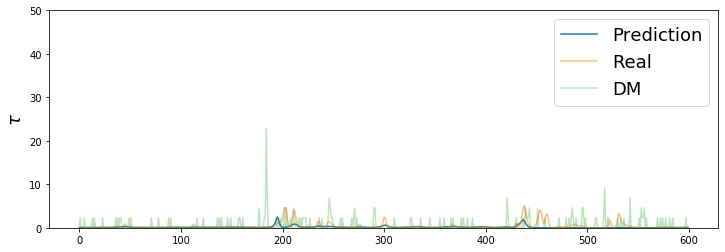

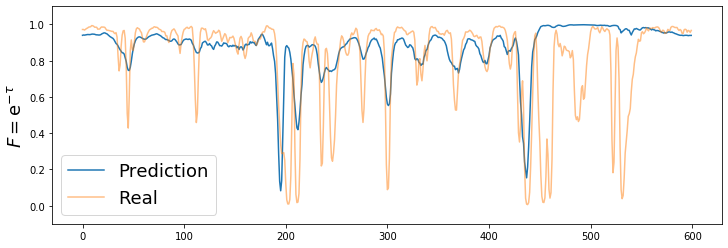

In [43]:
ii = np.random.randint(low=0, high=360000-1, size=1)[0].astype('int')
plt.figure(figsize=(12,4))
plt.plot( np.exp(outputs[ii]), label='Prediction' )
plt.plot( ske[ii], label='Real', alpha=0.5 )
plt.plot( DM_general[0, int(ii/600), int(ii%600), :], label='DM', alpha=0.3 )
plt.ylabel(r'$\tau$', fontsize=18)
plt.ylim([0,50])
#plt.yscale('log')
plt.legend(fontsize=18)

plt.figure(figsize=(12,4))
plt.plot( np.exp(-np.exp(outputs[ii])), label='Prediction' )
plt.plot( np.exp(-ske[ii]), label='Real', alpha=0.5 )
#plt.plot( DM_general[0, int(test_block[ii,0]/DM_reso), int(test_block[ii,1]/DM_reso), :].numpy(), label='DM', alpha=0.3 )
plt.ylabel(r'$F = \mathrm{e}^{-\tau}$', fontsize=18)
plt.ylim([-0.1,1.1])
#plt.yscale('log')
plt.legend(fontsize=18)